# 客户画像复赛 数据处理

In [1]:
!ls Data_Update/train/

01_arc_s_95598_wkst_train.tsv  06_cont_info.tsv		11_c_meter.tsv
02_s_comm_rec.tsv	       07_c_rca_cons.tsv	12_a_pay_flow.tsv
03_s_info_oversee.tsv	       08_a_rcved_flow.tsv	out
04_c_cons.tsv		       09_arc_a_rcvbl_flow.tsv	train_label.csv
05_c_cons_prc.tsv	       10_c_meter_read.tsv


## 1 导入必要的包和函数

In [1]:
%pdb 1
debug = 1
import pandas as pd
import numpy as np
import pickle
import re
import io 
import matplotlib.pyplot as plt
%matplotlib inline

# 加载预定义好的函数
# 预定义好的函数：
#    - load_data(file_name, header=0): 加载数据
#    - def show_attribute_detail( data=None, attribute_name=None): 显示数据某个属性的详情
%run data_util_func.py
# 选择过滤方案
PLAN_TYPE = 3

Automatic pdb calling has been turned ON


In [34]:
%who_ls

['FeatureEncoder',
 'data01_appno_contenttype_rdd',
 'data_feature_encoder',
 'debug',
 'extend_train_data',
 'get_accept_content_type',
 'get_highest_sensitive_workerid',
 'get_metrics',
 'io',
 'is_highest_sensitive_worker_dict',
 'load_data',
 'model_predict',
 'model_train',
 'np',
 'pd',
 'pickle',
 'plt',
 'print_function',
 're',
 'save_data',
 'seperate_data_to_classifier',
 'show_attribute_detail',
 'show_df_info',
 'test_data01_df',
 'test_data01_merge_label_df',
 'test_data_labels_df',
 'train_accept_content_type_count_df',
 'train_accept_content_type_sensitive_rate_series',
 'train_custno_in_season4_count_dict',
 'train_custno_in_season4_count_rdd',
 'train_custno_search_action_count_dict',
 'train_custno_search_action_count_rdd',
 'train_data01_a_worker_per_user',
 'train_data01_a_worker_per_user_accept_content_type_count_df',
 'train_data01_custno_handle_month_rdd',
 'train_data01_custno_issearchaction_rdd',
 'train_data01_merge_label_df',
 'train_data01_user_worker_count

In [36]:
del test_data_labels_df

##  2 加载数据 

### 2-1 用户列表

#### 2-1-1 训练集

##### 2-1-1-1  加载敏感用户标签 train_label.csv

In [2]:
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data_labels_df = load_data(file_name = 'Data_Update/train/train_label.csv',
                                 header=None,
                                 converters={0:unicode}
                                )
print(train_data_labels_df.shape)

(80025, 1)


##### 2-1-1-2  增加敏感标签字段，和 类型转换 

In [3]:
# 增加敏感标签字段，都是敏感用户，全部标为1
train_data_labels_df.columns = ['CUST_NO']
train_data_labels_df['TAG'] = 1
show_df_info(train_data_labels_df)

      CUST_NO  TAG
0  6028082372    1
1  6025004210    1
2  4415361544    1
3  1658079044    1
4  1658079045    1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80025 entries, 0 to 80024
Data columns (total 2 columns):
CUST_NO    80025 non-null object
TAG        80025 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.2+ MB
None


In [9]:
train_data_labels_df[train_data_labels_df['CUST_NO']=='1920004047']

,CUST_NO,TAG
424,1920004047,1


#### 2-1-2 测试集 

##### 2-1-2-1  加载待预测用户标签 test_to_predict.csv

In [4]:
# 要特别注意 统一设置 converters={'CUST_NO':unicode}，
# 避免后面连接错误
test_data_labels_df = load_data(file_name = 'Data_Update/test/test_to_predict.csv',
                                header=None,
                                converters={0:unicode}
                               )

test_data_labels_df.columns = ['CUST_NO']

show_df_info(test_data_labels_df)

      CUST_NO
0  6010419435
1  6310918440
2  4716029245
3  6010936575
4  3318025855
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370871 entries, 0 to 370870
Data columns (total 1 columns):
CUST_NO    370871 non-null object
dtypes: object(1)
memory usage: 2.8+ MB
None


#### 2-1-3  小结
- 训练数据敏感用户标签有：80,025 个
- 测试数据待预测用户有  ：370,871 个

### 2-2 工单数据

#### 2-2-1 训练集 

##### 2-2-1-1 加载数据 01_arc_s_95598_wkst_train.tsv

In [5]:
%%time
# 要特别注意 设置 converters={'CUST_NO':unicode}，
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
train_data01_df = load_data('Data_Update/train/01_arc_s_95598_wkst_train.tsv',converters={'CUST_NO':unicode}) 
print(train_data01_df.shape)

(1190198, 13)
CPU times: user 4.56 s, sys: 276 ms, total: 4.83 s
Wall time: 5.01 s


##### 2-2-1-2 数据摘要

In [41]:
show_df_info(data=train_data01_df)

             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280016584  1000000527201688               1               2.0   
1  2015101280016722  1000000527203612               3               2.0   
2  2015101280016734  1000000527203685               3               2.0   
3  2015101280019989  1000000527220221               3               1.0   
4  2015101280020073  1000000527220797               3               1.0   

      ORG_NO         HANDLE_TIME  \
0    3340501  2015/10/12 7:27:08   
1    3341020  2015/10/12 7:31:50   
2    3340670  2015/10/12 7:32:03   
3    3340401  2015/10/12 8:04:42   
4  334010101  2015/10/12 8:06:05   

                                    ACCEPT_CONTENT HANDLE_OPINION  CALLING_NO  \
0  【一户无电】非居民客户报修一户无电，经指导客户检查，无法判断设备故障及其资产归属，请现场查处。            NaN   1625671.0   
1                                 【银行代扣】客户咨询银行代扣事宜            NaN   1196922.0   
2                            【查询电费】客户查询本月电费金额，已告知。            NaN   1378624.0   
3       

In [12]:
%%time
# 将客户编号提取并去重，发现只有 658,374个用户编号
len(set(train_data01_df['CUST_NO']))

CPU times: user 436 ms, sys: 8 ms, total: 444 ms
Wall time: 443 ms


658374

#### 2-2-2 测试集 

##### 2-2-1-1 加载数据 01_arc_s_95598_wkst_test.tsv

In [6]:
%%time
# 要特别注意 设置 converters={'CUST_NO':unicode}，
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
test_data01_df = load_data('Data_Update/test/01_arc_s_95598_wkst_test.tsv',converters={'CUST_NO':unicode}) 
print(test_data01_df.shape)

(423728, 13)
CPU times: user 1.79 s, sys: 76 ms, total: 1.87 s
Wall time: 1.96 s


##### 2-2-1-2 数据摘要

In [48]:
show_df_info(data=test_data01_df)

             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280019632  1000000527215943               3               1.0   
1  2015101280019648  1000000527216033              10               2.0   
2  2015101280019680  1000000527216202               3               2.0   
3  2015101280019873  1000000527218491               3               1.0   
4  2015101280020130  1000000527221199               1               1.0   

      ORG_NO         HANDLE_TIME  \
0    3340780  2015/10/12 7:58:04   
1  334066001  2015/10/12 7:58:26   
2    3340690  2015/10/12 7:58:52   
3    3340810  2015/10/12 8:02:53   
4    3340501  2015/10/12 8:07:10   

                                      ACCEPT_CONTENT HANDLE_OPINION  \
0   【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。            NaN   
1  【退订】#2061584501；【退订】#2061584602；【退订】#406091928...            NaN   
2                                【查询电费】客户查询本月电费，已告知。            NaN   
3                           【咨询总户号】通过地址、户名查询户号信息

In [14]:
%%time
# 将客户编号提取并去重，发现只有 370,871个用户编号
len(set(test_data01_df['CUST_NO']))

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 127 ms


370871

#### 2-2-3 小结：
- 训练集有：1,190,198个工单数据
- 将训练集客户编号提取并去重，发现训练集只有 658,374用户编号
    - APP_NO              1190198 non-null int64
    - ID                  1190198 non-null int64    ---  **这里特别注意，ID不是唯一的，而说明文件说这个是唯一的**
    - BUSI_TYPE_CODE      1190198 non-null int64
    - URBAN_RURAL_FLAG    1189194 non-null float64
    - ORG_NO              1190198 non-null int64
    - HANDLE_TIME         1190198 non-null object
    - ACCEPT_CONTENT      1190198 non-null object
    - HANDLE_OPINION      6840 non-null object
    - CALLING_NO          1173909 non-null float64
    - ELEC_TYPE           936170 non-null float64
    - CUST_NO             1190198 non-null object
    - PROV_ORG_NO         1190198 non-null int64
    - CITY_ORG_NO         1190198 non-null int64

- 测试集有：  423,728个工单数据
- 将测试集客户编号提取并去重，发现测试集只有 370,871用户编号,跟 test_to_predict.csv 一样

### 2-3 将工单表和用户列表连接:
- 训练集 - 加上标签信息(0-不敏感，1-敏感)

#### 2-3-1训练集

##### 2-3-1-1 给工单添加上 是否敏感的 标签 TAG

In [7]:
%%time
# 利用和 敏感用户 表连接 来获取标签
train_data01_merge_label_df = train_data01_df.merge(train_data_labels_df,on=u'CUST_NO',how='left')
# 将没有连接上的工单设置为不敏感用户
train_data01_merge_label_df['TAG'] = train_data01_merge_label_df['TAG'].fillna(0)
train_data01_merge_label_df['TAG'] = train_data01_merge_label_df['TAG'].astype(int)

CPU times: user 1.09 s, sys: 44 ms, total: 1.14 s
Wall time: 1.14 s


In [16]:
len(train_data01_merge_label_df['CUST_NO'].unique()) == 658374

True

(2,)
CPU times: user 76 ms, sys: 4 ms, total: 80 ms
Wall time: 80 ms


0    895063
1    295135
Name: TAG, dtype: int64

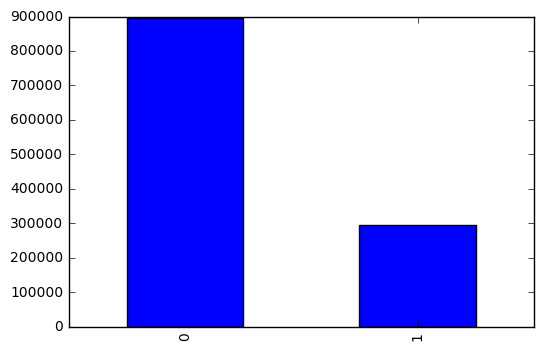

In [17]:
%%time
# 所有工单的统计
show_attribute_detail(train_data01_merge_label_df,u'TAG')

(2,)
CPU times: user 648 ms, sys: 340 ms, total: 988 ms
Wall time: 986 ms


0    578349
1     80025
Name: TAG, dtype: int64

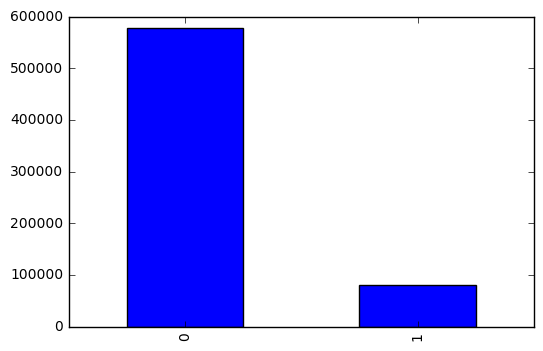

In [18]:
%%time
# 所有用户的统计
show_attribute_detail(train_data01_merge_label_df[['CUST_NO','TAG']].drop_duplicates(),u'TAG')

##### 2-3-1-2 保存 

###### 输出 训练集 中 敏感用户列表（sensitive.csv）和不敏感用户列表（nonsensitive.csv）

In [19]:
pd.DataFrame(
    data = {'CUST_NO':train_data01_merge_label_df.loc[train_data01_merge_label_df['TAG']==1,'CUST_NO'].unique()}
).to_csv('sensitive_users_list.csv',encoding='utf8',index=False)

pd.DataFrame(
    data = {'CUST_NO':train_data01_merge_label_df.loc[train_data01_merge_label_df['TAG']==0,'CUST_NO'].unique()}
).to_csv('nonsensitive_users_list.csv',encoding='utf8',index=False)

###### 输出 工单训练集中 所有用户和标签，共 658,374个用户

In [8]:
train_data01_cust_no_tag_df = \
    train_data01_merge_label_df[['CUST_NO','TAG']].drop_duplicates().sort_values(by='TAG')
save_data(
    train_data01_cust_no_tag_df,
    'train_data01_cust_no_tag_df.csv'
)
train_data01_cust_no_tag_df.shape

(658374, 2)

###### 从文件中恢复

In [5]:
# CONS_NO 全部转为字符串，否则在连接表的时候会出问题
train_data01_cust_no_tag_df = load_data('train_data01_cust_no_tag_df.csv',
                                        encoding='utf8',
                                        converters={'CUST_NO':unicode}
                                       )

#### 2-3-2 测试集

##### 2-3-2-1 将工单表 和 待预测用户表连接

In [8]:
%%time
# 利用和 敏感用户 表连接 来获取标签
test_data01_merge_label_df = test_data01_df.merge(test_data_labels_df,on=u'CUST_NO',how='left')

CPU times: user 692 ms, sys: 4 ms, total: 696 ms
Wall time: 696 ms


In [23]:
len(test_data01_merge_label_df['CUST_NO'].unique()) == 370871

True

#### 2-3-3 小结：
- 训练集有：1,190,198（有658,374个用户）个工单数据,其中不敏感用户的工单有 895,063 （有578,349个用户），而敏感用户的工单有 295,135（有80,025个用户(占总数的0.1215)，跟train_label.csv中给一模一样）————> 看出 敏感用户 的平均工单数比 不敏感用户 高很多
- 不敏感工单数： 895,063，敏感工单数：295,135，比例为 3.0327

### 2-4 08-实收电费信息表

#### 2-4-1 训练集 

##### 2-4-1-1 加载数据  train/08_a_rcved_flow.tsv

In [4]:
%%time
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
train_data08_df = load_data('Data_Update/train/08_a_rcved_flow.tsv', converters={'CONS_NO':unicode}) 

# 3,249,742 条记录
print(train_data08_df.shape)

(3249742, 9)
CPU times: user 4.58 s, sys: 192 ms, total: 4.77 s
Wall time: 4.96 s


In [73]:
show_df_info(train_data08_df)

    ORG_NO     CONS_NO  RCVED_YM  RCVED_DATE  THIS_RCVED_AMT  THIS_PENALTY  \
0  3340101  6011035199    201501    20150130      2143978.78           0.0   
1  3340101  1316023683    201501    20150128      2556221.39           0.0   
2  3340101  3190016243    201501    20150129      1607391.59           0.0   
3  3340101  6010496493    201501    20150107       153739.88           0.0   
4  3340101  1321072804    201501    20150107      3869548.04           0.0   

      OWE_AMT  RCVBL_YM  RCVBL_PENALTY  
0  2143978.78    201501            0.0  
1  2556221.39    201501            0.0  
2  1607391.59    201501            0.0  
3   153739.88    201501            0.0  
4  3869548.04    201501            0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3249742 entries, 0 to 3249741
Data columns (total 9 columns):
ORG_NO            int64
CONS_NO           object
RCVED_YM          int64
RCVED_DATE        int64
THIS_RCVED_AMT    float64
THIS_PENALTY      float64
OWE_AMT           float6

In [25]:
# data08 中 总用户数为：  282,152
len(train_data08_df['CONS_NO'].unique())

282152

##### 2-4-1-2 将数据连接上标签 

In [32]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data08_merge_label_df = train_data08_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_NO',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data08_merge_label_df['TAG'] = train_data08_merge_label_df['TAG'].fillna(0)
train_data08_merge_label_df['TAG'] = train_data08_merge_label_df['TAG'].astype(int)

CPU times: user 1.73 s, sys: 260 ms, total: 1.99 s
Wall time: 2.26 s


In [27]:
show_df_info(train_data08_merge_label_df)

    ORG_NO     CONS_NO  RCVED_YM  RCVED_DATE  THIS_RCVED_AMT  THIS_PENALTY  \
0  3340101  6011035199    201501    20150130      2143978.78           0.0   
1  3340101  1316023683    201501    20150128      2556221.39           0.0   
2  3340101  3190016243    201501    20150129      1607391.59           0.0   
3  3340101  6010496493    201501    20150107       153739.88           0.0   
4  3340101  1321072804    201501    20150107      3869548.04           0.0   

      OWE_AMT  RCVBL_YM  RCVBL_PENALTY     CUST_NO  TAG  
0  2143978.78    201501            0.0         NaN    0  
1  2556221.39    201501            0.0         NaN    0  
2  1607391.59    201501            0.0         NaN    0  
3   153739.88    201501            0.0  6010496493    1  
4  3869548.04    201501            0.0  1321072804    1  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3249742 entries, 0 to 3249741
Data columns (total 11 columns):
ORG_NO            int64
CONS_NO           object
RCVED_YM          int

###### 输出 训练集中 所有用户和标签，共 282,152个用户

In [33]:
train_data08_cust_no_tag_df = \
    train_data08_merge_label_df[['CONS_NO','TAG']].drop_duplicates().sort_values(by='TAG')
save_data(
    train_data08_cust_no_tag_df,
    'train_data08_cust_no_tag_df.csv'
)
train_data08_cust_no_tag_df.shape

(282152, 2)

###### 从文件中恢复

In [31]:
# 全部 CONS_NO 转为字符串，否则在连接表的时候会出问题
train_data08_cust_no_tag_df = load_data('train_data08_cust_no_tag_df.csv',
                                        encoding='utf8',
                                        converters={'CONS_NO':unicode}
                                       )



##### 2-4-1-3 统计敏感和不敏感的情况

###### 所有记录统计

###### 所有用户统计

(2,)


0    236493
1     45659
Name: TAG, dtype: int64

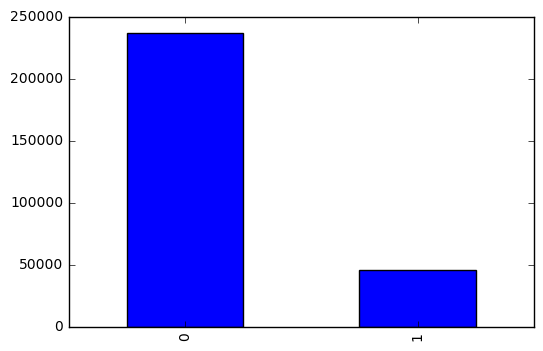

In [32]:
# 0    236,493
# 1     45,659
# 1/0 = 0.200263
show_attribute_detail(
    train_data08_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    'TAG'
)

(2,)


0    2707524
1     542218
Name: TAG, dtype: int64

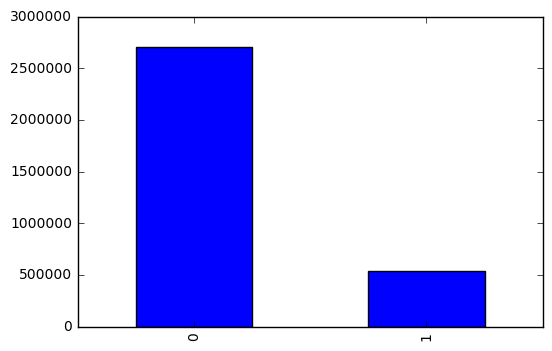

In [32]:
# 0    2,707,524
# 1     542,218
# 1/0 = 0.200263
show_attribute_detail(
    train_data08_merge_label_df,
    'TAG'
)

##### 和data01数据的用户列表比较

In [33]:
train_data01_data08_cust_no_tag_df = train_data01_cust_no_tag_df.merge(
    train_data08_cust_no_tag_df,
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 合并所有用户有：658374   ----  跟表1一样，即 表8和表9中所有用户都在表1中
# 在data01数据中，而不在data08数据中的用户数有：0
# 在data08数据中，而不在data01数据中的用户数有：376222
print '合并所有用户有：%d'%train_data01_data08_cust_no_tag_df.shape[0]
print '在data08数据中，而不在data01数据中的用户数有：%d'%sum(train_data01_data08_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data08数据中的用户数有：%d'%sum(train_data01_data08_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：658374
在data08数据中，而不在data01数据中的用户数有：0
在data01数据中，而不在data08数据中的用户数有：376222


In [34]:
train_data08_cust_no_tag_df[train_data08_cust_no_tag_df['CONS_NO']=='0002581851']

,CONS_NO,TAG
7918,0002581851,0


(658374, 4)
(2,)
0    578349
1     80025
Name: TAG_x, dtype: int64
(376222, 4)
(2,)
0    341856
1     34366
Name: TAG_x, dtype: int64
(282152, 4)
(2,)
0    236493
1     45659
Name: TAG_x, dtype: int64


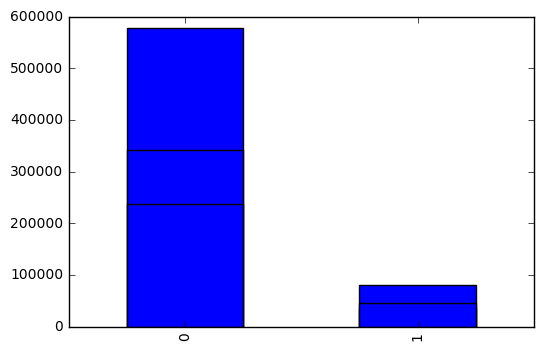

In [35]:
# 在data01数据中用户数有：658,374 ,其中不敏感有： 578,349，敏感有：80,025，1/0 比例为 0.1383680
print train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CUST_NO'].notnull()].shape
print show_attribute_detail(
    train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CUST_NO'].notnull()],
    'TAG_x'
)

# 在data01数据中，而不在data08数据中的用户数有：376,222,其中不敏感有： 341856，敏感有：34366，1/0 比例为 0.1005277
print train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CONS_NO'].isnull()].shape
print show_attribute_detail(
    train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CONS_NO'].isnull()],
    'TAG_x'
)
# 在data01数据中，也在data08数据中的用户数有：282,152,其中不敏感有： 236493，敏感有：45659，1/0 比例为 0.1930670252
print train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CONS_NO'].notnull()].shape
print show_attribute_detail(
    train_data01_data08_cust_no_tag_df[train_data01_data08_cust_no_tag_df['CONS_NO'].notnull()],
    'TAG_x'
)

#### 2-4-2 测试集 

##### 2-4-2-1 加载数据  test/08_a_rcved_flow_test.tsv

In [30]:
%%time
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
test_data08_df = load_data('Data_Update/test/08_a_rcved_flow_test.tsv',
                          converters={'CONS_NO':unicode}) 

# 3,710,654 条记录
print(test_data08_df.shape)

(3710654, 9)
CPU times: user 5.1 s, sys: 292 ms, total: 5.4 s
Wall time: 5.62 s


In [130]:
# 3,710,654 条记录
show_df_info(test_data08_df)

      CONS_NO   ORG_NO  RCVED_YM  RCVED_DATE  THIS_RCVED_AMT  THIS_PENALTY  \
0  6611825874  3340101    201501    20150113      1412988.62           0.0   
1  1321072599  3340101    201501    20150127    -16579561.98           0.0   
2  1321072599  3340101    201501    20150125       824632.00           0.0   
3  6611825874  3340101    201501    20150129      1755876.57           0.0   
4  1321072599  3340101    201501    20150114     16175368.00           0.0   

       OWE_AMT  RCVBL_YM  RCVBL_PENALTY  
0   1412988.62    201501            0.0  
1  17404193.98    201501            0.0  
2  17404193.98    201501            0.0  
3   1755876.57    201501            0.0  
4  16175368.00    201501            0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3710654 entries, 0 to 3710653
Data columns (total 9 columns):
CONS_NO           object
ORG_NO            int64
RCVED_YM          int64
RCVED_DATE        int64
THIS_RCVED_AMT    float64
THIS_PENALTY      float64
OWE_AMT           

In [17]:
# data08 中 总用户数为：  311,222
len(test_data08_df['CONS_NO'].unique())

311222

###### 输出 测试集中 所有用户，共311,222个用户

In [18]:
test_data08_cust_no_df = \
    test_data08_df['CONS_NO'].drop_duplicates()
save_data(
    test_data08_cust_no_df,
    'test_data08_cust_no_df.csv'
)
test_data08_cust_no_df.shape

(311222,)

###### 从文件中恢复

In [19]:
test_data08_cust_no_df = load_data('test_data08_cust_no_df.csv',
                                   encoding='utf8',
                                   converters={'CONS_NO':unicode}
                                   )
# 全部转为字符串，否则在连接表的时候会出问题


##### 2-4-2-2 将数据连接上待预测用户列表

In [9]:
%%time
test_data08_merge_label_df = test_data08_df.merge(
    test_data_labels_df,
    left_on='CONS_NO',
    right_on='CUST_NO',
    how='left'
)


NameError: name 'test_data08_df' is not defined

> <timed exec>(1)<module>()

ipdb> q


In [35]:
# 没在测试集中的数据有0,即全部都在测试集合
print sum(test_data08_merge_label_df['CUST_NO'].isnull())
# 总共用户数： 311222
print len(test_data08_merge_label_df['CONS_NO'].unique()) == 311222
# data01中用户 无 data08数据的 用户有 59,649
print 370871-len(test_data08_merge_label_df['CONS_NO'].unique())

NameError: name 'test_data08_merge_label_df' is not defined

> <ipython-input-35-a09d56ff09cf>(2)<module>()
      1 # 没在测试集中的数据有0,即全部都在测试集合
----> 2 print sum(test_data08_merge_label_df['CUST_NO'].isnull())
      3 # 总共用户数： 311222
      4 print len(test_data08_merge_label_df['CONS_NO'].unique()) == 311222
      5 # data01中用户 无 data08数据的 用户有 59,649

ipdb> q


#### 2-4-3 小结：
- 训练集有：3,249,742个实收电费信息数据
    - 不敏感：2,707,524;敏感：542,218,不敏感/敏感:0.200263
    - 将训练集客户编号提取并去重，发现训练集只有 282,152用户编号
           - 不敏感：236,493; 敏感：45,659, 不敏感/敏感:0.193067025
    - 与表1用户比较
        - 合并所有用户有：658374 (跟表1一样，即表8和表9中所有用户都在表1中)
        - 在data08数据中，而不在data01数据中的用户数有：0
        - 在data01数据中，而不在data08数据中的用户数有：376,222
        - 字段
            - ORG_NO            int64
            - CONS_NO           object
            - RCVED_YM          int64
            - RCVED_DATE        int64
            - THIS_RCVED_AMT    float64
            - THIS_PENALTY      float64
            - OWE_AMT           float64
            - RCVBL_YM          int64
            - RCVBL_PENALTY     float64
            
    - 在data01数据中用户数有：658,374 ,其中不敏感有： 578,349，敏感有：80,025，1/0 比例为 0.1383680
    - 在data01数据中，而不在data08数据中的用户数有：376,222,其中不敏感有： 341856，敏感有：34366，1/0 比例为 0.1005277
    - 在data01数据中，也在data08数据中的用户数有：282,152,其中不敏感有： 236493，敏感有：45659，1/0 比例为 0.1930670252
        - 连接上表的data01表用户的敏感度要高于连接不上表的
        
        
- 测试集有：  3,710,654个工单数据
- 将测试集客户编号提取并去重，发现训练集只有 311,222 用户编号，全部都在test_to_predict.csv（370871个用户）中，
    - 而 test_to_predict.csv 中有 59,649 个不在该表中


### 2-5 应收电费信息表  09_ARC_A_RCVBL_FLOW

#### 2-5-1 训练集 

##### 2-5-1-1 加载数据  train/09_arc_a_rcvbl_flow.tsv

In [17]:
%%time
# 这个类型转换非常重要，因为发现在和 train_label.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
train_data09_df = load_data('Data_Update/train/09_arc_a_rcvbl_flow.tsv',
                           converters={'CONS_NO':unicode,'PAY_MODE':unicode,'ORG_NO':unicode}) 

print(train_data09_df.shape)
# 555,748 个用户
print len(train_data09_df['CONS_NO'].unique())

(6466654, 15)
555748
CPU times: user 23.6 s, sys: 4.21 s, total: 27.8 s
Wall time: 44.5 s


##### 2-5-1-2 数据摘要

In [8]:
# 6,466,654条记录
show_df_info(train_data09_df)

      CONS_NO  RCVBL_YM       ORG_NO  PAY_MODE  T_PQ  RCVBL_AMT  RCVED_AMT  \
0  6010969031    201502  33401010130   10101.0  1869    1768.07    1768.07   
1  6010811670    201502  33401010130   10101.0  2791    2640.29    2640.29   
2  6010777305    201502  33401010130   20311.0  1883    1058.25    1058.25   
3  6010777296    201502  33401010130   20311.0  4279    3585.80    3585.80   
4  6010777190    201502  33401010130   20311.0  2514    1561.93    1561.93   

   STATUS_CODE  RCVBL_PENALTY  RCVED_PENALTY  RISK_LEVEL_CODE  OWE_AMT  \
0            1           0.00           0.00              NaN  1768.07   
1            1           0.00           0.00              NaN  2640.29   
2            1           2.12           2.12              NaN  1058.25   
3            1           0.00           0.00              NaN  3585.80   
4            1           0.00           0.00              NaN  1561.93   

   CONS_SORT_CODE  ELEC_TYPE_CODE  CTL_MODE  
0             2.0           403.0       

In [192]:
train_data09_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN


##### 2-5-1-3 将数据连接上标签 

In [18]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 5,531,189 个 data09记录， 47,5723个用户
train_data09_merge_label_df = train_data09_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_NO',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  935,465 个 data09记录,80,025个用户
train_data09_merge_label_df['TAG'] = train_data09_merge_label_df['TAG'].fillna(0)
train_data09_merge_label_df['TAG'] = train_data09_merge_label_df['TAG'].astype(int)
# 6,466,654条记录
print train_data09_merge_label_df.shape

(6466654, 17)
CPU times: user 3.84 s, sys: 1.45 s, total: 5.29 s
Wall time: 7.65 s


In [74]:
# 6,466,654条记录
show_df_info(train_data09_merge_label_df)

      CONS_NO  RCVBL_YM       ORG_NO  PAY_MODE  T_PQ  RCVBL_AMT  RCVED_AMT  \
0  6010969031    201502  33401010130   10101.0  1869    1768.07    1768.07   
1  6010811670    201502  33401010130   10101.0  2791    2640.29    2640.29   
2  6010777305    201502  33401010130   20311.0  1883    1058.25    1058.25   
3  6010777296    201502  33401010130   20311.0  4279    3585.80    3585.80   
4  6010777190    201502  33401010130   20311.0  2514    1561.93    1561.93   

   STATUS_CODE  RCVBL_PENALTY  RCVED_PENALTY  RISK_LEVEL_CODE  OWE_AMT  \
0            1           0.00           0.00              NaN  1768.07   
1            1           0.00           0.00              NaN  2640.29   
2            1           2.12           2.12              NaN  1058.25   
3            1           0.00           0.00              NaN  3585.80   
4            1           0.00           0.00              NaN  1561.93   

   CONS_SORT_CODE  ELEC_TYPE_CODE  CTL_MODE CUST_NO  TAG  
0             2.0          

###### 输出 训练集中 所有用户和标签，共 555,748个用户

In [7]:
train_data09_cust_no_tag_df = \
    train_data09_merge_label_df[['CONS_NO','TAG']].drop_duplicates().sort_values(by='TAG')
save_data(
    train_data09_cust_no_tag_df,
    'train_data09_cust_no_tag_df.csv'
)
train_data09_cust_no_tag_df.shape

(555748, 2)

###### 从文件中恢复

In [4]:
# 全部转为字符串，否则在连接表的时候会出问题
train_data09_cust_no_tag_df = load_data('train_data09_cust_no_tag_df.csv',
                                        encoding='utf8',
                                        converters={'CONS_NO':unicode}
                                       )


##### 2-5-1-4 统计敏感和不敏感的情况

(2,)


0    5531189
1     935465
Name: TAG, dtype: int64

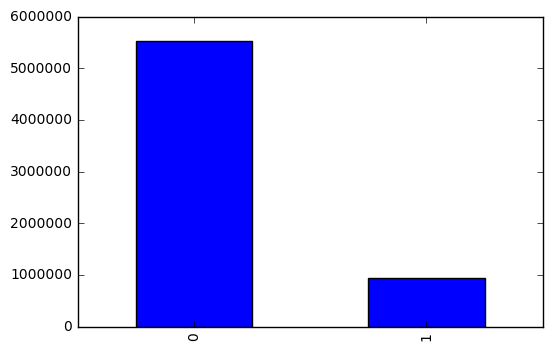

In [50]:
# 所有工单的统计
# 0    5,531,189
# 1     935,465
# 1/0   0.16912548
show_attribute_detail(train_data09_merge_label_df,'TAG')

(2,)


0    475723
1     80025
Name: TAG, dtype: int64

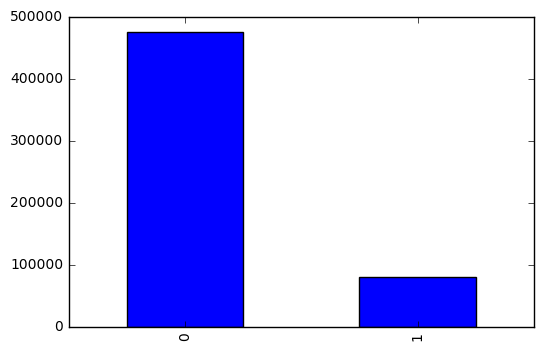

In [51]:
# 所有用户的统计
# 0    475,723
# 1     80,025   ---- 跟表1-data01 的敏感用户一样
# 1/0   0.1682176392
show_attribute_detail(train_data09_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),'TAG')

##### 和data01数据的用户列表比较

In [13]:
train_data01_data09_cust_no_tag_df = train_data01_cust_no_tag_df.merge(
    train_data09_cust_no_tag_df,
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 合并所有用户有：658,374   ----  跟表1一样，即 表8和表9中所有用户都在表1中
# 在data01数据中，而不在data09数据中的用户数有：0
# 在data09数据中，而不在data01数据中的用户数有：102,626
print '合并所有用户有：%d'%train_data01_data09_cust_no_tag_df.shape[0]
print '在data09数据中，而不在data01数据中的用户数有：%d'%sum(train_data01_data09_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data09数据中的用户数有：%d'%sum(train_data01_data09_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：658374
在data09数据中，而不在data01数据中的用户数有：0
在data01数据中，而不在data09数据中的用户数有：102626


(658374, 4)
(2,)
0    578349
1     80025
Name: TAG_x, dtype: int64
(102626, 4)
(1,)
0    102626
Name: TAG_x, dtype: int64
(555748, 4)
(2,)
0    475723
1     80025
Name: TAG_x, dtype: int64


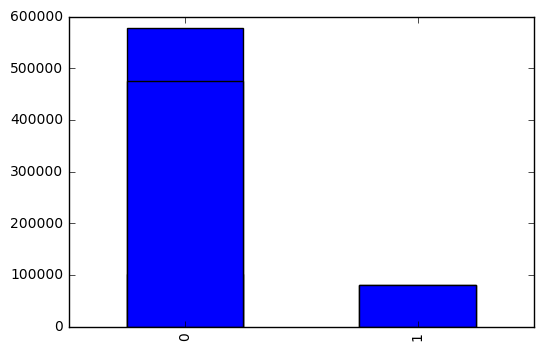

In [54]:
# 在data01数据中用户数有：658,374 ,其中不敏感有： 578,349，敏感有：80,025，1/0 比例为 0.138367
print train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CUST_NO'].notnull()].shape
print show_attribute_detail(
    train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CUST_NO'].notnull()],
    'TAG_x'
)

# 在data01数据中，而不在data09数据中的用户数有：102,626,其中不敏感有： 102,626，敏感有：0，1/0 比例为 
# 这是个关键信息，意味着连接不上 09表 的01表用户 都是非敏感的用户，可以拿去直接过滤测试数据
print train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CONS_NO'].isnull()].shape
print show_attribute_detail(
    train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CONS_NO'].isnull()],
    'TAG_x'
)
# 在data01数据中，也在data09数据中的用户数有：555,748,其中不敏感有： 475,723，敏感有：80,025，1/0 比例为 0.168217639
print train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CONS_NO'].notnull()].shape
print show_attribute_detail(
    train_data01_data09_cust_no_tag_df[train_data01_data09_cust_no_tag_df['CONS_NO'].notnull()],
    'TAG_x'
)

##### 和data08数据的用户列表比较

In [58]:
train_data08_data09_cust_no_tag_df = train_data08_cust_no_tag_df.merge(
    train_data09_cust_no_tag_df,
    how='outer',
    on='CONS_NO',
)
# 08表和09表合并后，所有用户有：556,844   ----  表8和表9的用户不一致，即各有自己的用户
# 在data01数据中，而不在data09数据中的用户数有：1
# 在data09数据中，而不在data01数据中的用户数有：376223
print '合并所有用户有：%d'%train_data08_data09_cust_no_tag_df.shape[0]
print '在data08数据中，而不在data09数据中的用户数有：%d'%sum(train_data08_data09_cust_no_tag_df['TAG_x'].isnull())
print '在data09数据中，而不在data08数据中的用户数有：%d'%sum(train_data08_data09_cust_no_tag_df['TAG_y'].isnull())


合并所有用户有：556844
在data08数据中，而不在data09数据中的用户数有：274692
在data09数据中，而不在data08数据中的用户数有：1096


In [92]:
train_data08_data09_cust_no_tag_df.head()

,CONS_NO,TAG_x,TAG_y
0,6011035199,0.0,0.0
1,6120351106,0.0,0.0
2,6120116008,0.0,0.0
3,6118024684,0.0,0.0
4,6111023661,0.0,0.0


#### 2-5-2 测试集 

##### 2-5-1-1 加载数据  test/09_arc_a_rcvbl_flow_test.tsv

In [19]:
%%time
# 这个类型转换非常重要，因为发现在和 test_to_predict.csv表 的 CUST_NO 连接时 ，如果不全部转为 字符串 ，会连接 不对，因为
# 在这个表里的 CUST_NO 字段出现 部分 字段是字符串，部分字段是整形，所以全部转为字符串
test_data09_df = load_data('Data_Update/test/09_arc_a_rcvbl_flow_test.tsv',
                           converters={'CONS_NO':unicode,'PAY_MODE':unicode,'ORG_NO':unicode}) 

print(test_data09_df.shape)

(2479469, 15)
CPU times: user 7.43 s, sys: 1.68 s, total: 9.1 s
Wall time: 16.8 s


##### 2-5-1-2 数据摘要

In [49]:
# 2,479,469条记录
show_df_info(test_data09_df)

      CONS_NO  RCVBL_YM       ORG_NO  PAY_MODE  T_PQ  RCVBL_AMT  RCVED_AMT  \
0  8602008462    201509    334019001   20311.0   169      90.92      90.92   
1  8664221007    201509  33401900101   20311.0   290     156.02     156.02   
2  8664221012    201509  33401900101   20311.0   110      59.18      59.18   
3  8602060747    201509    334019001   20311.0    25      13.64      13.64   
4  8660041104    201509  33401900101   20311.0    44      23.67      23.67   

   STATUS_CODE  RCVBL_PENALTY  RCVED_PENALTY  RISK_LEVEL_CODE  OWE_AMT  \
0            1            0.0            0.0              NaN    90.92   
1            1            0.0            0.0              NaN   156.02   
2            1            0.0            0.0              NaN    59.18   
3            1            0.0            0.0              NaN    13.64   
4            1            0.0            0.0              NaN    23.67   

   CONS_SORT_CODE  ELEC_TYPE_CODE  CTL_MODE  
0             3.0           201.0       

In [60]:
# 201,702 个用户
len(test_data09_df['CONS_NO'].unique())

201702

In [192]:
test_data09_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN


###### 输出 测试集中 所有用户，共 201,702个用户

In [61]:
test_data09_cust_no_df = \
    test_data09_df['CONS_NO'].drop_duplicates()
save_data(
    test_data09_cust_no_df,
    'test_data09_cust_no_df.csv'
)
test_data09_cust_no_df.shape

(201702,)

###### 从文件中恢复

In [13]:
test_data09_cust_no_df = load_data('test_data09_cust_no_df.csv',
                                   encoding='utf8',
                                   converters={'CONS_NO':unicode}
                                   )
# 全部转为字符串，否则在连接表的时候会出问题


##### 2-5-2-2 将数据连接上待预测用户列表

In [21]:
%%time
test_data09_merge_label_df = test_data09_df.merge(
    test_data_labels_df,
    left_on='CONS_NO',
    right_on='CUST_NO',
    how='left'
)
print test_data09_merge_label_df.shape

(2479469, 16)
CPU times: user 2.18 s, sys: 536 ms, total: 2.72 s
Wall time: 4.4 s


In [64]:
# 没在测试集中的数据有0,即全部都在测试集合
print sum(test_data09_merge_label_df['CUST_NO'].isnull())
# 总共用户数： 201,702
print len(test_data09_merge_label_df['CONS_NO'].unique()) 
# data01中用户 无 data09数据的 用户有 169,169 --- 根据训练集，连接不上09表的01表用户是否直接判为 非敏感
print 370871-len(test_data09_merge_label_df['CONS_NO'].unique())

0
201702
169169


#### 2-5-3 小结：
- 训练集有：6,466,654个 应收电费信息表 数据
       不敏感：5,531,189;敏感：935,465,不敏感/敏感:0.16912548
    - 将训练集客户编号提取并去重，发现训练集只有 555,748 个用户编号
       不敏感：475,723; 敏感：80,025（跟train_label.csv中敏感用户一样，意味着所有训练集中敏感用户都有表9）, 不敏感/敏感: 0.16912548

        - 合并所有用户有：658,374(跟表1一样，即表8和表9中所有用户都在表1中)
        - 在data09数据中，而不在data01数据中的用户数有：0
        - 在data01数据中，而不在data09数据中的用户数有：102,626
        - 字段
            - ORG_NO            int64
            - CONS_NO           object
            - RCVED_YM          int64
            - RCVED_DATE        int64
            - THIS_RCVED_AMT    float64
            - THIS_PENALTY      float64
            - OWE_AMT           float64
            - RCVBL_YM          int64
            - RCVBL_PENALTY     float64
            
    - 在data01数据中用户数有：658,374 ,其中不敏感有： 578,349，敏感有：80,025，1/0 比例为 0.138367
    - 在data01数据中，而不在data09数据中的用户数有：102,626,其中不敏感有： 102,626，敏感有：0，1/0 比例为 *（这是个关键信息，意味着连接不上 09表 的01表用户 都是非敏感的用户，可以拿去直接过滤测试数据）
    - 在data01数据中，也在data09数据中的用户数有：555,748,其中不敏感有： 475,723，敏感有：80,025，1/0 比例为 0.168217639


- 08表和09表合并后，所有用户有：556,844   ----  表8和表9的用户不一致，即各有自己的用户	
    - 在data08数据中，而不在data09数据中的用户数有：274692	
    - 在data09数据中，而不在data08数据中的用户数有：1096	


- 测试集有：  2,479,469 个工单数据
- 将测试集客户编号提取并去重，发现训练集只有 201,702 用户编号，全部都在test_to_predict.csv（370871个用户）中，
    - 而 test_to_predict.csv 中有 169,169 个不在该表中  --- **根据训练集，连接不上09表的01表用户是否直接判为 非敏感**



## 3 进行不同特征的探索

### 3-1 统计每个用户的 工单数


#### 3-1-1 训练集

##### 3-1-1-1 统计每个用户的工单数

In [6]:
%%time
# 统计每个用户的工单数
train_data01_user_worker_count_series = train_data01_merge_label_df['CUST_NO'].value_counts()

CPU times: user 1.04 s, sys: 4 ms, total: 1.04 s
Wall time: 1.04 s


In [66]:
train_data01_user_worker_count_series['6010052424']

83

In [68]:
# 检验总用户数是不是这个数字
len(train_data01_user_worker_count_series) ==  658374

True

##### 3-1-1-2 添加一个字段 工单数

In [7]:
%%time
# 添加一个字段 工单数
train_data01_merge_label_df['NUM_OF_WORKER'] = \
    train_data01_merge_label_df['CUST_NO'].map(train_data01_user_worker_count_series)

CPU times: user 756 ms, sys: 0 ns, total: 756 ms
Wall time: 755 ms


In [24]:
# 取出  'NUM_OF_WORKER','CUST_NO','TAGG' 这三个字段进行 统计
temp = train_data01_merge_label_df[['NUM_OF_WORKER','CUST_NO','TAG']].drop_duplicates()
print temp.shape

(658377, 3)


工单数分布情况
(59, 5)
      total      tag0  tag0/total     tag1  tag1/total
61       61       0.0    0.000000     61.0    1.000000
37      259       0.0    0.000000    259.0    1.000000
66       66       0.0    0.000000     66.0    1.000000
29      464       0.0    0.000000    464.0    1.000000
39      195       0.0    0.000000    195.0    1.000000
41       41       0.0    0.000000     41.0    1.000000
42       42       0.0    0.000000     42.0    1.000000
83       83       0.0    0.000000     83.0    1.000000
47       94       0.0    0.000000     94.0    1.000000
50       50       0.0    0.000000     50.0    1.000000
71      213       0.0    0.000000    213.0    1.000000
70       70       0.0    0.000000     70.0    1.000000
53      106       0.0    0.000000    106.0    1.000000
60       60       0.0    0.000000     60.0    1.000000
26      494      26.0    0.052632    468.0    0.947368
22      748      44.0    0.058824    704.0    0.941176
33      396      33.0    0.083333    363.0    0.9

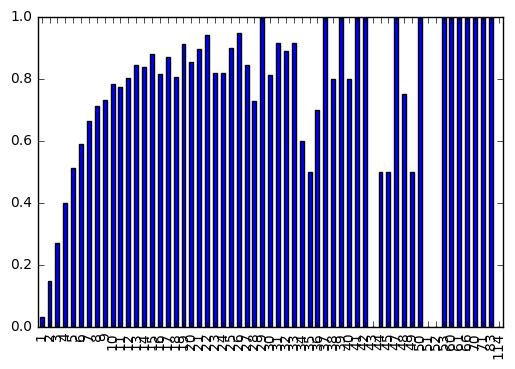

In [11]:
print '工单数分布情况'
temp = show_attribute_detail(train_data01_merge_label_df,
                      attribute_name='NUM_OF_WORKER',
                      split_by_tag=True,
                      tag_name='TAG').sort_values(by='tag1/total',ascending=False)
print temp

#### 3-1-2 测试集

##### 3-1-2-1 统计每个用户的工单数

In [37]:
%%time
# 统计每个用户的工单数
test_data01_user_worker_count_series = test_data01_merge_label_df['CUST_NO'].value_counts()

CPU times: user 392 ms, sys: 4 ms, total: 396 ms
Wall time: 393 ms


##### 3-1-2-2 添加一个字段 工单数

In [38]:
%%time
# 添加一个字段 工单数
test_data01_merge_label_df['NUM_OF_WORKER'] = \
    test_data01_merge_label_df['CUST_NO'].map(test_data01_user_worker_count_series)

CPU times: user 360 ms, sys: 4 ms, total: 364 ms
Wall time: 366 ms


#### 3-1-3 用户工单数初步结论
- 从训练集得出：工单数越多，敏感读越高，但是不是很明显


### 3-2 ACCEPT_CONTENT 工作单受理内容

#### 3-2-1 训练集

##### 3-2-1-1 增加字段 ACCEPT_CONTENT_TYPE

In [12]:
%%time
train_data01_merge_label_df['ACCEPT_CONTENT_TYPE'] = \
        train_data01_merge_label_df['ACCEPT_CONTENT'].apply(lambda x : get_accept_content_type(x,return_first1=True))
print train_data01_merge_label_df['ACCEPT_CONTENT_TYPE'][:5]

0    一户无电
1    银行代扣
2    查询电费
3    查询电费
4    查询电费
Name: ACCEPT_CONTENT_TYPE, dtype: object
CPU times: user 4.46 s, sys: 56 ms, total: 4.52 s
Wall time: 4.5 s


##### 3-3-1-2 统计 工单类型为空的 记录 的 敏感 /不敏感分布情况

(2,)


0    2155
1     570
Name: TAG, dtype: int64

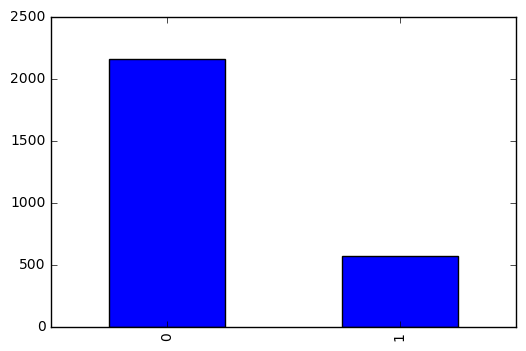

In [11]:
show_attribute_detail(
    train_data01_merge_label_df.loc[train_data01_merge_label_df['ACCEPT_CONTENT_TYPE'].isnull()],
    attribute_name='TAG',
)

##### 3-3-1-3 统计所有工单类别的敏感度（每个工单类别 tag1数量/总数）

In [10]:
# 在训练集上的所有工单上 统计
train_accept_content_type_count_df = show_attribute_detail(
    train_data01_merge_label_df,
    'ACCEPT_CONTENT_TYPE',
    split_by_tag=True, 
    tag_name='TAG',
    show_pic=False,
)
print train_accept_content_type_count_df.head()

# 取出敏感度统计量  tag1/total
train_accept_content_type_sensitive_rate_series = train_accept_content_type_count_df['tag1/total']


(1135, 5)
                total  tag0  tag0/total  tag1  tag1/total
2户无电                3   3.0         1.0   0.0         0.0
4404072760回呼电话      1   0.0         0.0   1.0         1.0
APP                 2   2.0         1.0   0.0         0.0
APP密码               1   1.0         1.0   0.0         0.0
app                 1   1.0         1.0   0.0         0.0


In [32]:
# 
save_data(
    train_accept_content_type_count_df,
    'train_accept_content_type_sensitive_rate_first1.csv',
    index=True
)

In [33]:
train_accept_content_type_sensitive_rate_series.get(u'4404072760回呼电话',0)

1.0

In [17]:
train_accept_content_type_count_df.shape

(1135, 5)

#### 3-3-2 测试集

##### 3-3-2-1 增加字段 ACCEPT_CONTENT_TYPE

In [13]:
%%time
test_data01_merge_label_df['ACCEPT_CONTENT_TYPE'] = \
        test_data01_merge_label_df['ACCEPT_CONTENT'].apply(lambda x : get_accept_content_type(x,return_first1=True))
print test_data01_merge_label_df['ACCEPT_CONTENT_TYPE'][:5]

0    客户咨询一户无电
1          退订
2        查询电费
3       咨询总户号
4        设备故障
Name: ACCEPT_CONTENT_TYPE, dtype: object
CPU times: user 1.58 s, sys: 56 ms, total: 1.64 s
Wall time: 1.62 s


In [19]:
show_attribute_detail(
    test_data01_merge_label_df,
    'ACCEPT_CONTENT_TYPE',
    show_pic=False
)

(664,)


2户无电                1
APP                 1
一户无电            27336
一户跳闸                4
一户频繁跳闸              3
三户无电                2
专业咨询               15
业务办理超时限             1
业务变更                7
业务超时                1
业扩变更              252
业扩报装              100
业扩报装加速              1
业扩超时               19
两户无电               13
中介                 11
中介咨询总户号            50
中介来电               92
中介查户号               3
中介查询电费              3
临时停电信息              1
临时用电                1
二户无电                1
交费售电网点             13
交费差错更正             19
交错费                 1
人员态度               46
人员违规               65
人身伤亡                2
代征电费                2
                ...  
错发短信               29
闪断                  2
阶梯电价             3057
青苗赔偿               29
非供企业维护              1
非供电业务             656
非供电业务咨询             1
非供电公司业务             1
非供电公司抢修范围           1
非供电公司维护范围          11
非供电维修               1
非南方供电业务             1
非家电设备损坏            11
非居民内部故障             8
非用电业务咨询   

#### 3-3-3 小结
- 在训练集所有工单上 总共 1,135 个 工单类型
- 在测试集所有工单上 总共   664 个 工单类型
- 回访类型相关的都敏感度不高，比如 网站回访等
- 跟电量相关的敏感度高点

### 3-3 用户查询次数

#### 3-4-1 训练集

##### 3-4-1-1 新增字段 IS_SEARCH_ACTION 标识 当前 小工单类型 是否 查询电费的动作

In [14]:
%%time
# 是 查询电费 ，则设置为1
train_data01_merge_label_df.loc[train_data01_merge_label_df['ACCEPT_CONTENT_TYPE'] == u'查询电费',
                                'IS_SEARCH_ACTION'] = 1
# 不是 查询电费 ，则设置为1
train_data01_merge_label_df.loc[train_data01_merge_label_df['IS_SEARCH_ACTION'].isnull(),'IS_SEARCH_ACTION']=0


CPU times: user 352 ms, sys: 36 ms, total: 388 ms
Wall time: 394 ms


In [56]:
train_data01_merge_label_df[train_data01_merge_label_df['CUST_NO']=='0002582056']

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,PROV_ORG_NO,CITY_ORG_NO,TAG,HANDLE_HOUR,HANDLE_YEAR,HANDLE_MONTH,HANDLE_DAY,ACCEPT_CONTENT_TYPE,IS_SEARCH_ACTION,NUM_OF_HANDLE_MONTH
544330,2015090474784841,1000000491321402,3,2.0,3340140,2015/9/4 12:14:50,【查询电费】客户查询9月是否欠费,NaN,1701598.0,200.0,...,33101,33401,0,12,2015,9,4,查询电费,1.0,2
901508,2015031446543827,1000000298302237,3,2.0,3340101,2015/3/14 16:35:03,【查询电费】客户查询是否欠费，欠费金额，已告知,NaN,1701598.0,200.0,...,33101,33401,0,16,2015,3,14,查询电费,1.0,2
921891,2015031847091845,1000000302024005,1,1.0,3340140,2015/3/18 13:36:23,【一户无电】低压居民客户报修一户无电，经指导客户检查，无法判断设备故障及其资产归属，请现场查处,NaN,1701598.0,NaN,...,33101,33401,0,13,2015,3,18,一户无电,0.0,2
921906,2015031847093472,1000000302032462,3,2.0,334014001,2015/3/18 13:44:50,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1701598.0,200.0,...,33101,33401,0,13,2015,3,18,客户咨询一户无电,0.0,2
930563,2015031346386197,1000000297252445,3,1.0,3340101,2015/3/13 12:44:00,【查询电费】客户查询电费相关信息，已告知。,NaN,1701598.0,NaN,...,33101,33401,0,12,2015,3,13,查询电费,1.0,2
933414,2015031346398822,1000000297335673,3,2.0,334014001,2015/3/13 14:13:34,【查询电费】客户查询电费，已告知,NaN,1701598.0,200.0,...,33101,33401,0,14,2015,3,13,查询电费,1.0,2


##### 3-4-1-2 统计 每个用户的查询电费次数

In [12]:
train_data01_custno_issearchaction_rdd = \
    sc.parallelize(train_data01_merge_label_df[['CUST_NO','IS_SEARCH_ACTION']].as_matrix())
train_data01_custno_issearchaction_rdd.cache()

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:475

In [13]:
%%time
train_custno_search_action_count_rdd = train_data01_custno_issearchaction_rdd.groupBy(lambda x:x[0]).mapValues(
    lambda items: sum([x[1] for x in items ])
)
train_custno_search_action_count_dict = train_custno_search_action_count_rdd.collectAsMap()

CPU times: user 456 ms, sys: 40 ms, total: 496 ms
Wall time: 26 s


In [19]:
len(train_custno_search_action_count_dict) == 658374

True

##### 3-4-1-3 新增字段 NUM_OF_SEARCH_ACTION 标识 用户 是否 查询电费的次数

In [14]:
train_data01_merge_label_df['NUM_OF_SEARCH_ACTION'] = \
    train_data01_merge_label_df['CUST_NO'].map(train_custno_search_action_count_dict)

In [26]:
train_data01_merge_label_df.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,CUST_NO,PROV_ORG_NO,CITY_ORG_NO,TAG,ACCEPT_CONTENT_TYPE,IS_SEARCH_ACTION,NUM_OF_SEARCH_ACTION
0,2015101280016584,1000000527201688,1,2.0,3340501,2015/10/12 7:27:08,【一户无电】非居民客户报修一户无电，经指导客户检查，无法判断设备故障及其资产归属，请现场查处。,NaN,1625671.0,405.0,5115500151,33101,33405,0,一户无电,0.0,0.0
1,2015101280016722,1000000527203612,3,2.0,3341020,2015/10/12 7:31:50,【银行代扣】客户咨询银行代扣事宜,NaN,1196922.0,202.0,5720017228,33101,33410,0,银行代扣,0.0,0.0
2,2015101280016734,1000000527203685,3,2.0,3340670,2015/10/12 7:32:03,【查询电费】客户查询本月电费金额，已告知。,NaN,1378624.0,201.0,6911007734,33101,33406,0,查询电费,1.0,3.0
3,2015101280019989,1000000527220221,3,1.0,3340401,2015/10/12 8:04:42,【查询电费】客户查询本月电费金额。,NaN,1149071.0,202.0,4400013050,33101,33404,1,查询电费,1.0,12.0
4,2015101280020073,1000000527220797,3,1.0,334010101,2015/10/12 8:06:05,【查询电费】客户查询电费是否欠费，已告知。,NaN,1052032.0,100.0,6023002461,33101,33401,1,查询电费,1.0,31.0


##### 3-4-1-4 分布情况

查询电费的次数
(51, 5)
       total      tag0  tag0/total   tag1  tag1/total
25.0     336       0.0    0.000000    336    1.000000
42.0      95       0.0    0.000000     95    1.000000
34.0     110       0.0    0.000000    110    1.000000
36.0      81       0.0    0.000000     81    1.000000
37.0     109       0.0    0.000000    109    1.000000
38.0     128       0.0    0.000000    128    1.000000
39.0      40       0.0    0.000000     40    1.000000
40.0      44       0.0    0.000000     44    1.000000
45.0     102       0.0    0.000000    102    1.000000
26.0     151       0.0    0.000000    151    1.000000
48.0      71       0.0    0.000000     71    1.000000
50.0     103       0.0    0.000000    103    1.000000
60.0      70       0.0    0.000000     70    1.000000
61.0      61       0.0    0.000000     61    1.000000
64.0      66       0.0    0.000000     66    1.000000
68.0      71       0.0    0.000000     71    1.000000
29.0      65       0.0    0.000000     65    1.000000
75.0      83

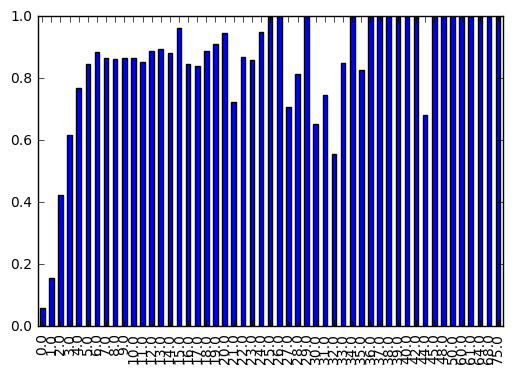

In [43]:
print '查询电费的次数'
train_data01_merge_label_num_of_search_action_count_df = show_attribute_detail(train_data01_merge_label_df,
                      attribute_name='NUM_OF_SEARCH_ACTION',
                      split_by_tag=True,
                      tag_name='TAG').sort_values(by='tag1/total',ascending=False)
print train_data01_merge_label_num_of_search_action_count_df

##### 添加字段  用户 最高 月[查询电费]的数量

In [39]:
%%time
def get_max_num_of_search_action(x):
#     用户月最大查询电费次数
    result = max(x.groupby('HANDLE_MONTH')['IS_SEARCH_ACTION'].apply(lambda x:sum(x)))
    return pd.Series(result)


train_data01_cust_no_max_num_of_search_action_df = \
    train_data01_merge_label_df.groupby('CUST_NO')['HANDLE_MONTH','IS_SEARCH_ACTION'].apply(get_max_num_of_search_action)

CPU times: user 11min 59s, sys: 3.48 s, total: 12min 2s
Wall time: 12min 2s


In [61]:
train_data01_cust_no_max_num_of_search_action_dict = \
    train_data01_cust_no_max_num_of_search_action_df[0].to_dict()

In [66]:
train_data01_a_worker_per_user['MAX_NUM_MONTH_SEARCH_ACTION'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data01_cust_no_max_num_of_search_action_dict)

(18, 5)


,total,tag0,tag0/total,tag1,tag1/total
0.0,377156,362534.0,0.961231,14622,0.038769
1.0,234882,199186.0,0.848026,35696,0.151974
2.0,36480,14833.0,0.406606,21647,0.593394
3.0,7196,1516.0,0.210673,5680,0.789327
4.0,1797,211.0,0.117418,1586,0.882582
5.0,542,45.0,0.083026,497,0.916974
6.0,171,12.0,0.070175,159,0.929825
7.0,74,7.0,0.094595,67,0.905405
8.0,37,2.0,0.054054,35,0.945946
9.0,18,2.0,0.111111,16,0.888889


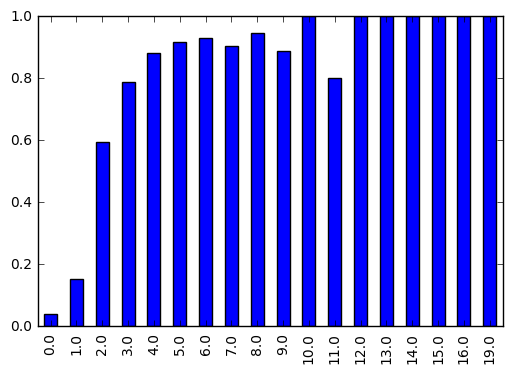

In [4]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'MAX_NUM_MONTH_SEARCH_ACTION',
    True,
    'TAG'
)

(51, 5)


,total,tag0,tag0/total,tag1,tag1/total
0.0,377156,362534.0,0.961231,14622,0.038769
1.0,195872,174487.0,0.890822,21385,0.109178
2.0,50712,30836.0,0.608061,19876,0.391939
3.0,17657,7241.0,0.410092,10416,0.589908
4.0,7522,1888.0,0.250997,5634,0.749003
5.0,3488,578.0,0.165711,2910,0.834289
6.0,1809,226.0,0.124931,1583,0.875069
7.0,1124,163.0,0.145018,961,0.854982
8.0,651,93.0,0.142857,558,0.857143
9.0,509,69.0,0.135560,440,0.864440


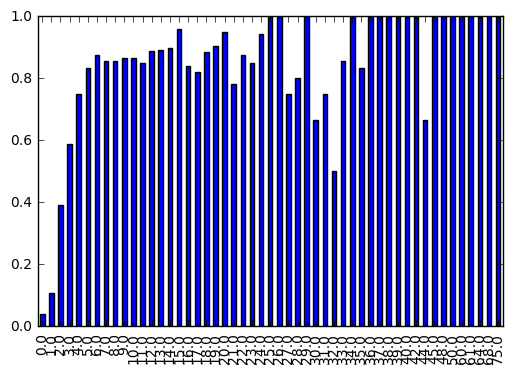

In [5]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'NUM_OF_SEARCH_ACTION',
    True,
    'TAG'
)

#### 3-4-2 测试集

##### 3-4-2-1 新增字段 IS_SEARCH_ACTION 标识 当前 小工单类型 是否 查询电费的动作

In [74]:
%%time
# 是 查询电费 ，则设置为1
test_data01_merge_label_df.loc[test_data01_merge_label_df['ACCEPT_CONTENT_TYPE'] == u'查询电费',
                                'IS_SEARCH_ACTION'] = 1
# 不是 查询电费 ，则设置为1
test_data01_merge_label_df.loc[test_data01_merge_label_df['IS_SEARCH_ACTION'].isnull(),'IS_SEARCH_ACTION']=0


CPU times: user 156 ms, sys: 4 ms, total: 160 ms
Wall time: 160 ms


##### 3-4-2-2 统计 每个用户的查询电费次数

In [41]:
test_data01_custno_issearchaction_rdd = \
    sc.parallelize(test_data01_merge_label_df[['CUST_NO','IS_SEARCH_ACTION']].as_matrix())
test_data01_custno_issearchaction_rdd.cache()

ParallelCollectionRDD[18] at parallelize at PythonRDD.scala:475

In [42]:
%%time
test_custno_search_action_count_rdd = test_data01_custno_issearchaction_rdd.groupBy(lambda x:x[0]).mapValues(
    lambda items: sum([x[1] for x in items ])
)
test_custno_search_action_count_dict = test_custno_search_action_count_rdd.collectAsMap()

CPU times: user 248 ms, sys: 36 ms, total: 284 ms
Wall time: 8.46 s


In [39]:
len(test_custno_search_action_count_dict) == 370871

True

##### 3-4-2-3 新增字段 NUM_OF_SEARCH_ACTION 标识 用户 是否 查询电费的次数

In [43]:
test_data01_merge_label_df['NUM_OF_SEARCH_ACTION'] = \
    test_data01_merge_label_df['CUST_NO'].map(test_custno_search_action_count_dict)

In [41]:
test_data01_merge_label_df.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,CUST_NO,PROV_ORG_NO,CITY_ORG_NO,ACCEPT_CONTENT_TYPE,IS_SEARCH_ACTION,NUM_OF_SEARCH_ACTION
0,2015101280019632,1000000527215943,3,1.0,3340780,2015/10/12 7:58:04,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1628699.0,202.0,9400029736,33101,33407,客户咨询一户无电,0.0,0.0
1,2015101280019648,1000000527216033,10,2.0,334066001,2015/10/12 7:58:26,【退订】#2061584501；【退订】#2061584602；【退订】#406091928...,NaN,1260775.0,201.0,6851831254,33101,33406,退订,0.0,0.0
2,2015101280019680,1000000527216202,3,2.0,3340690,2015/10/12 7:58:52,【查询电费】客户查询本月电费，已告知。,NaN,1536321.0,201.0,7312218251,33101,33406,查询电费,1.0,1.0
3,2015101280019873,1000000527218491,3,1.0,3340810,2015/10/12 8:02:53,【咨询总户号】通过地址、户名查询户号信息，已告知,NaN,1576698.0,NaN,3330149860,33101,33408,咨询总户号,0.0,0.0
4,2015101280020130,1000000527221199,1,1.0,3340501,2015/10/12 8:07:10,【设备故障】客户报修此处线路打火，请处理。客户只能提供此地址，烦请电话联系057486581...,NaN,1089990.0,201.0,5210210735,33101,33405,设备故障,0.0,0.0


##### 3-4-2-4 分布情况

查询电费的次数
(9,)
0.0    269135
1.0    130555
2.0     19173
3.0      3753
4.0       835
5.0       219
6.0        19
7.0        29
9.0        10
Name: NUM_OF_SEARCH_ACTION, dtype: int64


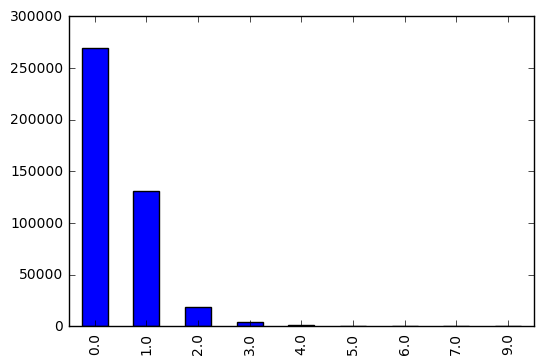

In [25]:
print '查询电费的次数'
test_data01_merge_label_num_of_search_action_count_df = show_attribute_detail(test_data01_merge_label_df,
                      attribute_name='NUM_OF_SEARCH_ACTION',
                      )
print test_data01_merge_label_num_of_search_action_count_df

##### 添加字段  用户 最高 月[查询电费]的数量

In [92]:
%%time
def get_max_num_of_search_action(x):
#     用户月最大查询电费次数
    result = max(x.groupby('HANDLE_MONTH').apply(lambda y:sum(y['IS_SEARCH_ACTION'])))
    return result


test_data01_cust_no_max_num_of_search_action_df = \
    test_data01_merge_label_df.groupby('CUST_NO').apply(get_max_num_of_search_action)

CPU times: user 13min 31s, sys: 3.59 s, total: 13min 35s
Wall time: 13min 55s


In [83]:
test_data01_cust_no_max_num_of_search_action_dict = \
    test_data01_cust_no_max_num_of_search_action_df[0].to_dict()

In [84]:
test_data01_a_worker_per_user['MAX_NUM_MONTH_SEARCH_ACTION'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data01_cust_no_max_num_of_search_action_dict)

(6,)


0.0    246199
1.0    119977
2.0      4382
3.0       284
4.0        27
5.0         2
Name: MAX_NUM_MONTH_SEARCH_ACTION, dtype: int64

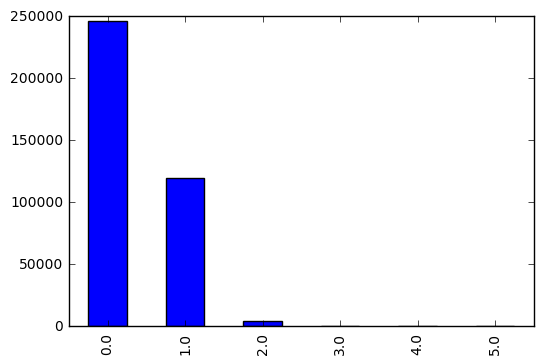

In [88]:
show_attribute_detail(
    test_data01_a_worker_per_user,
    'MAX_NUM_MONTH_SEARCH_ACTION'
)

#### 3-4-3 合并结果

In [45]:
temp = train_data01_merge_label_num_of_search_action_count_df.join(
    test_data01_merge_label_num_of_search_action_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['NUM_OF_SEARCH_ACTION']
temp = temp.drop(labels = [u'NUM_OF_SEARCH_ACTION'],axis=1)
temp

,total,tag0,tag0/total,tag1,tag1/total,test_total
25.0,336,0.0,0.000000,336,1.000000,0.0
42.0,95,0.0,0.000000,95,1.000000,0.0
34.0,110,0.0,0.000000,110,1.000000,0.0
36.0,81,0.0,0.000000,81,1.000000,0.0
37.0,109,0.0,0.000000,109,1.000000,0.0
38.0,128,0.0,0.000000,128,1.000000,0.0
39.0,40,0.0,0.000000,40,1.000000,0.0
40.0,44,0.0,0.000000,44,1.000000,0.0
45.0,102,0.0,0.000000,102,1.000000,0.0
26.0,151,0.0,0.000000,151,1.000000,0.0


### 3-4 代表工单(每个用户只取敏感度最高的订单作为代表工单) &&  添加新字段- ACCEPT_CONTENT_TYPE 的统计情况 添加到代表工单中

#### 3-5-1 训练集

#### 3-5-1-1 添加字段 IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE 是否高敏感工单类型 的工单

In [20]:
%%time
# 新增字段 - 是否高敏感工单
data01_appno_contenttype_rdd = \
    sc.parallelize(train_data01_merge_label_df[['APP_NO','CUST_NO','ACCEPT_CONTENT_TYPE']].as_matrix())
     
user_highest_sensitive_worker_rdd = \
        data01_appno_contenttype_rdd.groupBy(lambda x : x[1]).mapValues(
                                lambda x : get_highest_sensitive_workerid(x,
                                                                          train_accept_content_type_sensitive_rate_series))

user_highest_sensitive_worker_dict = user_highest_sensitive_worker_rdd.collectAsMap()

# 新增字段 - 是否高敏感工单
is_highest_sensitive_worker_dict = {i:1 for i in user_highest_sensitive_worker_dict.values()}

train_data01_merge_label_df['IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE'] = \
        train_data01_merge_label_df['APP_NO'].map(is_highest_sensitive_worker_dict)

CPU times: user 3.04 s, sys: 512 ms, total: 3.56 s
Wall time: 31.5 s


##### 3-5-1-2 生成代表工单 train_data01_a_worker_per_user

In [21]:
# data01数据的 只留下 每个用户一条最高敏感工单，剩下 658,377条
train_data01_a_worker_per_user = \
    train_data01_merge_label_df.loc[train_data01_merge_label_df['IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE'].notnull()]
train_data01_a_worker_per_user.shape

(658374, 24)

In [39]:
len(train_data01_a_worker_per_user['CUST_NO'].unique()) == 658377

True

In [18]:
show_df_info(train_data01_a_worker_per_user)

              APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
1   2015101280016722  1000000527203612               3               2.0   
6   2015101280031388  1000000527304861               3               1.0   
8   2015101280031680  1000000527300870               3               2.0   
12  2015101280032506  1000000527305664               3               1.0   
13  2015101280032529  1000000527305820               3               2.0   

       ORG_NO         HANDLE_TIME                ACCEPT_CONTENT  \
1     3341020  2015/10/12 7:31:50              【银行代扣】客户咨询银行代扣事宜   
6     3340901  2015/10/12 9:14:03  【咨询总户号】通过地址（户名、表号）查询户号信息，已告知   
8   334020106  2015/10/12 9:11:37        【咨询总户号】通过地址（户名）查询户号信息。   
12    3340101  2015/10/12 9:14:48  【咨询总户号】通过地址（户名、表号）查询户号信息，已告知   
13  334104001  2015/10/12 9:14:58                  【咨询总户号】中介查户号   

   HANDLE_OPINION  CALLING_NO  ELEC_TYPE     CUST_NO  PROV_ORG_NO  \
1             NaN   1196922.0      202.0  5720017228        33101   
6 

(2,)


0    578352
1     80025
Name: TAG, dtype: int64

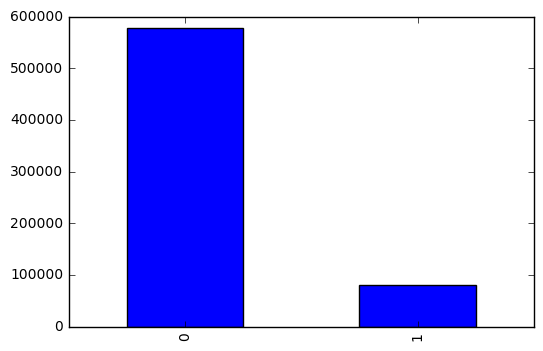

In [67]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'TAG'
)

##### 3-5-1-3 统计 代表工单 上工单类别的情况

###### 统计 代表工单 上所有工单类别的情况

In [4]:
# 训练集 代表工单 ACCEPT_CONTENT_TYPE
# 有799条工单类型
train_data01_a_worker_per_user_accept_content_type_count_df = show_attribute_detail(
    train_data01_a_worker_per_user,
    'ACCEPT_CONTENT_TYPE',
    split_by_tag=True, 
    tag_name='TAG',
    show_pic=False,
)

(799, 5)


###### 统计 经过09表规则 过滤之后的 代表工单 上所有工单类别的情况

In [30]:
# 训练集 代表工单 ACCEPT_CONTENT_TYPE
# 有749条工单类型
train_data01_a_worker_per_user_after09table_accept_content_type_count_df = show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'ACCEPT_CONTENT_TYPE',
    split_by_tag=True, 
    tag_name='TAG',
    show_pic=False,
)

(749, 5)


###### 空工单类型的 用户情况

(2,)


0    495
1     71
Name: TAG, dtype: int64

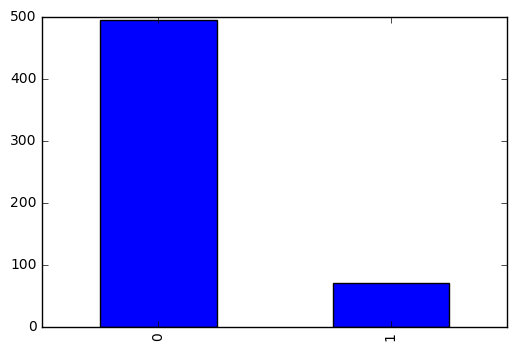

In [31]:
# 有715个记录无工单类型
show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['ACCEPT_CONTENT_TYPE'].isnull()],
    'TAG',
)

In [29]:
save_data(
    train_data01_a_worker_per_user_accept_content_type_count_df,
    'train_accept_content_type_first1.csv',
    index=True
)

#### 3-5-2 测试集

##### 3-5-2-1 添加字段 IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE 是否高敏感工单类型 的工单

In [48]:
%%time
# 新增字段 - 是否高敏感工单
data01_appno_contenttype_rdd = \
    sc.parallelize(test_data01_merge_label_df[['APP_NO','CUST_NO','ACCEPT_CONTENT_TYPE']].as_matrix())
     
user_highest_sensitive_worker_rdd = \
        data01_appno_contenttype_rdd.groupBy(lambda x : x[1]).mapValues(
                                lambda x : get_highest_sensitive_workerid(x,
                                                                          train_accept_content_type_sensitive_rate_series))
# is_leave = []
user_highest_sensitive_worker_dict = user_highest_sensitive_worker_rdd.collectAsMap()

# 新增字段 - 是否高敏感工单
is_highest_sensitive_worker_dict = {i:1 for i in user_highest_sensitive_worker_dict.values()}

test_data01_merge_label_df['IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE'] = \
        test_data01_merge_label_df['APP_NO'].map(is_highest_sensitive_worker_dict)

CPU times: user 1.51 s, sys: 176 ms, total: 1.68 s
Wall time: 13 s


##### 3-5-2-2 生成代表工单 test_data01_a_worker_per_user

In [49]:
# data01数据的 只留下 每个用户一条最高敏感工单，剩下 370,871条
test_data01_a_worker_per_user = \
    test_data01_merge_label_df.loc[test_data01_merge_label_df['IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE'].notnull()]
test_data01_a_worker_per_user.shape

(370871, 23)

In [40]:
test_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,CUST_NO,PROV_ORG_NO,CITY_ORG_NO,ACCEPT_CONTENT_TYPE,IS_HIGHEST_SENSITIVE_ACCEPT_CONTENT_TYPE,HANDLE_HOUR,HANDLE_YEAR,HANDLE_MONTH,HANDLE_DAY
0,2015101280019632,1000000527215943,3,1.0,3340780,2015/10/12 7:58:04,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1628699.0,202.0,9400029736,33101,33407,客户咨询一户无电,1.0,7,2015,10,12
1,2015101280019648,1000000527216033,10,2.0,334066001,2015/10/12 7:58:26,【退订】#2061584501；【退订】#2061584602；【退订】#406091928...,NaN,1260775.0,201.0,6851831254,33101,33406,退订,1.0,7,2015,10,12
2,2015101280019680,1000000527216202,3,2.0,3340690,2015/10/12 7:58:52,【查询电费】客户查询本月电费，已告知。,NaN,1536321.0,201.0,7312218251,33101,33406,查询电费,1.0,7,2015,10,12
3,2015101280019873,1000000527218491,3,1.0,3340810,2015/10/12 8:02:53,【咨询总户号】通过地址、户名查询户号信息，已告知,NaN,1576698.0,NaN,3330149860,33101,33408,咨询总户号,1.0,8,2015,10,12
4,2015101280020130,1000000527221199,1,1.0,3340501,2015/10/12 8:07:10,【设备故障】客户报修此处线路打火，请处理。客户只能提供此地址，烦请电话联系057486581...,NaN,1089990.0,201.0,5210210735,33101,33405,设备故障,1.0,8,2015,10,12


##### 3-5-2-3 统计 代表工单 上所有工单类别的情况

###### 统计 代表工单 上所有工单类别的情况

In [38]:
# 无工单类型用户数量有 578 个
test_data01_a_worker_per_user[test_data01_a_worker_per_user['ACCEPT_CONTENT_TYPE'].isnull()].shape

(353, 30)

In [35]:
# 测试集 代表工单 有工单类型 ACCEPT_CONTENT_TYPE 的统计情况
# 总共有 591 个工单类型
test_data01_a_worker_per_user_accept_content_type_count_df = show_attribute_detail(
    test_data01_a_worker_per_user,
    'ACCEPT_CONTENT_TYPE',
    show_pic=False,
)

(450,)


###### 统计 经过09表规则 过滤之后的 代表工单 上所有工单类别的情况

In [31]:
# 测试集 代表工单 ACCEPT_CONTENT_TYPE
# 有450条工单类型

test_data01_a_worker_per_user_after09table_accept_content_type_count_df = show_attribute_detail(
    test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'ACCEPT_CONTENT_TYPE',
    show_pic=False,
)

(450,)


###### 保存

In [34]:
save_data(
    test_data01_a_worker_per_user_accept_content_type_count_df,
    'test_accept_content_type_first1.csv',
    index=True
)

#### 3-5-3 小结
- 在训练集代表工单上，不敏感工单数： 578,352，敏感工单数：80,025，比例为 7.227
- 在训练集代表工单上 总共 799 个 工单类型，其余有 715条记录无工单类型（其中不敏感用户：644,敏感：71）
- 在测试集代表工单上 总共 591 个 工单类型, 其余有 578条记录无工单类型


#### 3-5-4 合并 训练集和测试集的 代表工单 的 工单处理内容类型 的 统计情况

##### 3-5-4-1 训练集和测试集的 工单处理内容类型 连接

In [36]:
# 训练集和测试集的 工单处理内容类型 连接
train_test_a_worker_per_user_accept_content_type_count_df = \
    train_data01_a_worker_per_user_accept_content_type_count_df.join(
        test_data01_a_worker_per_user_accept_content_type_count_df,
        how='outer',
    )
# 更改字段名
train_test_a_worker_per_user_accept_content_type_count_df['test_total'] = \
    train_test_a_worker_per_user_accept_content_type_count_df['ACCEPT_CONTENT_TYPE']
train_test_a_worker_per_user_accept_content_type_count_df = \
    train_test_a_worker_per_user_accept_content_type_count_df.drop(['ACCEPT_CONTENT_TYPE'], axis=1)
# 将空值 填充为 0
train_test_a_worker_per_user_accept_content_type_count_df = \
    train_test_a_worker_per_user_accept_content_type_count_df.fillna(0)
# 总共951个工单类型
show_df_info(train_test_a_worker_per_user_accept_content_type_count_df)

                  total   tag1  tag1/total     tag0  tag0/total  test_total
2户无电                1.0    0.0    0.000000      1.0    1.000000         1.0
4404072760回呼电话      1.0    1.0    1.000000      0.0    0.000000         0.0
APP                 1.0    0.0    0.000000      1.0    1.000000         0.0
一户报修                1.0    1.0    1.000000      0.0    0.000000         0.0
一户无电            23287.0  148.0    0.006355  23139.0    0.993645     13158.0
<class 'pandas.core.frame.DataFrame'>
Index: 827 entries, 2户无电 to 验表超时
Data columns (total 6 columns):
total         827 non-null float64
tag1          827 non-null float64
tag1/total    827 non-null float64
tag0          827 non-null float64
tag0/total    827 non-null float64
test_total    827 non-null float64
dtypes: float64(6)
memory usage: 45.2+ KB
None


In [32]:
# 训练集和测试集的 工单处理内容类型 连接
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df = \
    train_data01_a_worker_per_user_after09table_accept_content_type_count_df.join(
        test_data01_a_worker_per_user_after09table_accept_content_type_count_df,
        how='outer',
    )
# 更改字段名
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df['test_total'] = \
    train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df['ACCEPT_CONTENT_TYPE']
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df = \
    train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df.drop(['ACCEPT_CONTENT_TYPE'], axis=1)
# 将空值 填充为 0
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df = \
    train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df.fillna(0)
# 总共951个工单类型
show_df_info(train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df)

                  total   tag1  tag1/total     tag0  tag0/total  test_total
2户无电                1.0    0.0    0.000000      1.0    1.000000         1.0
4404072760回呼电话      1.0    1.0    1.000000      0.0    0.000000         0.0
APP                 1.0    0.0    0.000000      1.0    1.000000         0.0
一户报修                1.0    1.0    1.000000      0.0    0.000000         0.0
一户无电            23287.0  148.0    0.006355  23139.0    0.993645     13158.0
<class 'pandas.core.frame.DataFrame'>
Index: 827 entries, 2户无电 to 验表超时
Data columns (total 6 columns):
total         827 non-null float64
tag1          827 non-null float64
tag1/total    827 non-null float64
tag0          827 non-null float64
tag0/total    827 non-null float64
test_total    827 non-null float64
dtypes: float64(6)
memory usage: 45.2+ KB
None


In [33]:
show_df_info(train_test_a_worker_per_user_accept_content_type_count_df)

                total  tag0  tag0/total  tag1  tag1/total  test_total
2户无电              3.0   3.0         1.0   0.0         0.0         1.0
4404072760回呼电话    1.0   0.0         0.0   1.0         1.0         0.0
APP               1.0   1.0         1.0   0.0         0.0         1.0
一户停电              1.0   1.0         1.0   0.0         0.0         0.0
一户报修              1.0   0.0         0.0   1.0         1.0         0.0
<class 'pandas.core.frame.DataFrame'>
Index: 951 entries, 2户无电 to 验表超时
Data columns (total 6 columns):
total         951 non-null float64
tag0          951 non-null float64
tag0/total    951 non-null float64
tag1          951 non-null float64
tag1/total    951 non-null float64
test_total    951 non-null float64
dtypes: float64(6)
memory usage: 52.0+ KB
None


##### 3-5-4-2 保存到文件

In [22]:
save_data(train_test_a_worker_per_user_accept_content_type_count_df,
          'train&test_a_worker_per_user_accept_content_type_first1-20161206.csv',
          index=True
         )

NameError: name 'train_test_a_worker_per_user_accept_content_type_count_df' is not defined

> <ipython-input-22-dd420e9e5966>(1)<module>()
----> 1 save_data(train_test_a_worker_per_user_accept_content_type_count_df,
      2           'train&test_a_worker_per_user_accept_content_type_first1-20161206.csv',
      3           index=True
      4          )

ipdb> q


In [23]:
save_data(train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df,
          'train&test_a_worker_per_user_after09table_accept_content_type_first1-20161206.csv',
          index=True
         )

In [13]:
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df.shape

(827, 6)

##### 3-5-4-3 直接从文件中加载 ACCEPT_CONTENT_TYPE 的统计情况， train_test_a_worker_per_user_accept_content_type_count_df

In [52]:
train_test_a_worker_per_user_accept_content_type_count_df = \
    load_data(
#         'train&test_a_worker_per_user_accept_content_type_first1-20161204.csv',
        'train&test_a_worker_per_user_accept_content_type_first1-20161206.csv',
        encoding='utf8')
    
train_test_a_worker_per_user_accept_content_type_count_df.columns = ['ACCEPT_CONTENT_TYPE',
                                                                   'total',
                                                                   'tag0',
                                                                   'tag0/total',
                                                                   'tag1',
                                                                   'tag1/total',
                                                                   'test_total'
                                                                  ]

In [27]:
train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df = \
    load_data(
        'train&test_a_worker_per_user_after09table_accept_content_type_first1-20161206.csv',
        encoding='utf8')

train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df.columns = ['ACCEPT_CONTENT_TYPE',
                                                                   'total_after09table',
                                                                   'tag1_after09table',
                                                                   'tag1/total_after09table',
                                                                   'tag0_after09table',
                                                                   'tag0/total_after09table',
                                                                   'test_total_after09table'
                                                                  ]

##### 3-5-4-4 添加新字段： ACCEPT_CONTENT_TYPE 的统计情况 添加到 train_data01_a_worker_per_user 
##### 以及 test_data01_a_worker_per_user 中

In [53]:
train_data01_a_worker_per_user = train_data01_a_worker_per_user.merge(
                                train_test_a_worker_per_user_accept_content_type_count_df,
                                how='left',
                                on = 'ACCEPT_CONTENT_TYPE'
                               )

In [54]:
test_data01_a_worker_per_user = test_data01_a_worker_per_user.merge(
                                train_test_a_worker_per_user_accept_content_type_count_df,
                                how='left',
                                on = 'ACCEPT_CONTENT_TYPE'
                               )

In [34]:
train_data01_a_worker_per_user = train_data01_a_worker_per_user.merge(
                                train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df,
                                how='left',
                                on = 'ACCEPT_CONTENT_TYPE'
                               )

In [28]:
test_data01_a_worker_per_user = test_data01_a_worker_per_user.merge(
                                train_test_data01_a_worker_per_user_after09table_accept_content_type_count_df,
                                how='left',
                                on = 'ACCEPT_CONTENT_TYPE'
                               )

In [29]:
test_data01_a_worker_per_user.iloc[0]

APP_NO                                                                      2015101280019632
ID                                                                          1000000527215943
BUSI_TYPE_CODE                                                                             3
URBAN_RURAL_FLAG                                                                           1
ORG_NO                                                                               3340780
HANDLE_TIME                                                               2015/10/12 7:58:04
ACCEPT_CONTENT                              【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。
HANDLE_OPINION                                                                           NaN
CALLING_NO                                                                        1.6287e+06
ELEC_TYPE                                                                                202
CUST_NO                                                               

### 3-6 业务类型编码 BUSI_TYPE_CODE


#### 3-7-1所有工单下

#### 3-7-1-1 训练集

In [21]:
# 当该字段为空情况下，有 0个工单
print train_data01_merge_label_df.loc[train_data01_merge_label_df['BUSI_TYPE_CODE'].isnull()].shape

(0, 16)


In [24]:
len(train_data01_merge_label_df['BUSI_TYPE_CODE'].unique())

10

(10, 5)


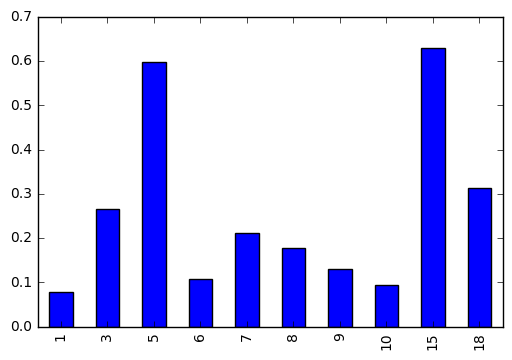

In [30]:
train_data01_merge_label_busi_type_code_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'BUSI_TYPE_CODE',split_by_tag=True,tag_name='TAG')

##### 3-7-1-2 测试集

In [26]:
# 当该字段为空情况下，有 0个工单
print test_data01_merge_label_df.loc[test_data01_merge_label_df['BUSI_TYPE_CODE'].isnull()].shape

(0, 15)


(10,)


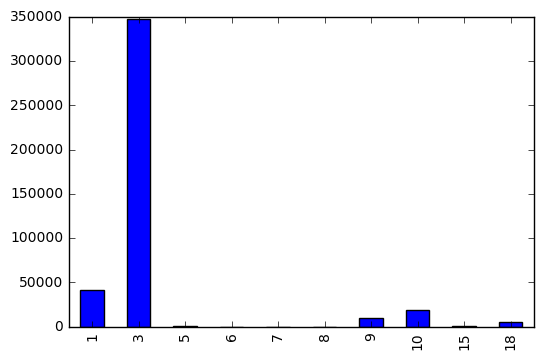

In [31]:
test_data01_merge_label_busi_type_code_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'BUSI_TYPE_CODE')

##### 3-7-1-3 合并结果

In [32]:
temp = train_data01_merge_label_busi_type_code_count_df.join(
    test_data01_merge_label_busi_type_code_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['BUSI_TYPE_CODE']
temp = temp.drop(labels = [u'BUSI_TYPE_CODE'],axis=1)
print '所有工单 - 业务类型编码 BUSI_TYPE_CODE'
print temp

所有工单 - 业务类型编码 BUSI_TYPE_CODE
      total    tag0  tag0/total    tag1  tag1/total  test_total
15     4286    1592    0.371442    2694    0.628558         506
5      2339     943    0.403164    1396    0.596836         762
18    12982    8923    0.687336    4059    0.312664        4857
3   1027793  753862    0.733476  273931    0.266524      347084
7        85      67    0.788235      18    0.211765          24
8       147     121    0.823129      26    0.176871          50
9     25230   21934    0.869362    3296    0.130638       10085
6       187     167    0.893048      20    0.106952          80
10    33498   30322    0.905188    3176    0.094812       18535
1     83651   77132    0.922069    6519    0.077931       41745


#### 3-7-2 代表工单下

##### 3-7-2-1 训练集

In [33]:
# 当该字段为空情况下，有 0个工单
print train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['BUSI_TYPE_CODE'].isnull()].shape

(0, 16)


(10, 5)


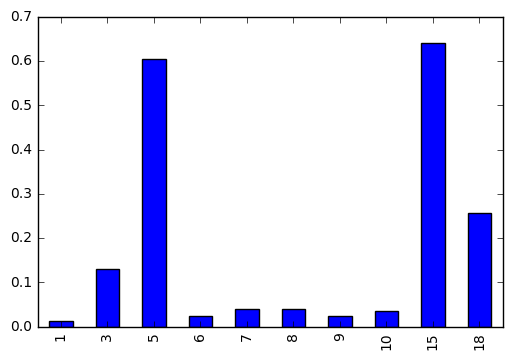

In [39]:
# 当该字段为不空情况下
train_data01_a_worker_per_user_busi_type_code_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'BUSI_TYPE_CODE',split_by_tag=True,tag_name='TAG')

##### 3-7-2-2 测试集

In [35]:
# 当该字段为空情况下，有 0个工单
print test_data01_a_worker_per_user.loc[test_data01_a_worker_per_user['BUSI_TYPE_CODE'].isnull()].shape

(0, 15)


(10,)


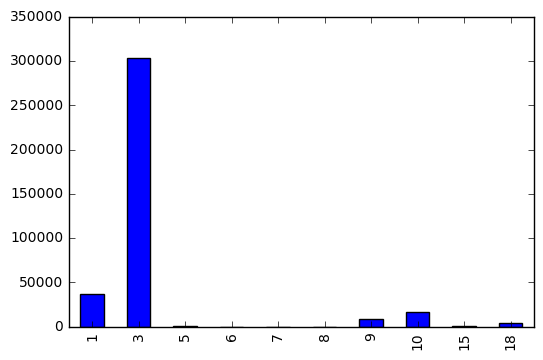

In [40]:
test_data01_a_worker_per_user_busi_type_code_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'BUSI_TYPE_CODE')

##### 3-7-2-3 合并结果

In [41]:
temp = train_data01_a_worker_per_user_busi_type_code_count_df.join(
    test_data01_a_worker_per_user_busi_type_code_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['BUSI_TYPE_CODE']
temp = temp.drop(labels = [u'BUSI_TYPE_CODE'],axis=1)
print '代表工单 -业务类型编码 BUSI_TYPE_CODE'
print temp

代表工单 -业务类型编码 BUSI_TYPE_CODE
     total    tag0  tag0/total   tag1  tag1/total  test_total
15    3456    1245    0.360243   2211    0.639757         455
5     1905     754    0.395801   1151    0.604199         724
18    7838    5834    0.744323   2004    0.255677        4231
3   560528  487620    0.869930  72908    0.130070      303447
7       49      47    0.959184      2    0.040816          24
8       75      72    0.960000      3    0.040000          40
10   23261   22451    0.965178    810    0.034822       16979
9    11771   11477    0.975023    294    0.024977        8242
6       82      80    0.975610      2    0.024390          74
1    49412   48772    0.987048    640    0.012952       36655


##### 业务类型编码 初步结论
- 类型    15、5（投诉）               可能有价值，因为 敏感度最高
- 类型    1（故障报修）、10（订阅信息）  可能有价值，因为 不敏感度最高


### 3-6 所属省（市）公司供电单位编码 PROV_ORG_NO

In [ ]:
show_attribute_detail(data01_train_merge_label_df,'PROV_ORG_NO',split_by_tag=True,tag_name='TAG')

In [ ]:
len(data01_train_merge_label_df['PROV_ORG_NO'].unique())

###### 小结
- 所有工单都是一个单位编号，价值不大

### 3-7 所属市（区）公司供电单位编码 CITY_ORG_NO

#### 3-7-1所有工单下

#### 3-7-1-1 训练集

In [80]:
# 当该字段为空情况下，有 0个工单
print train_data01_merge_label_df.loc[train_data01_merge_label_df['CITY_ORG_NO'].isnull()].shape

(0, 16)


In [ ]:
show_attribute_detail(data01_train_merge_label_df,'CITY_ORG_NO',split_by_tag=True,tag_name='TAG')

In [ ]:
len(data01_train_merge_label_df['CITY_ORG_NO'].unique())

(12, 5)


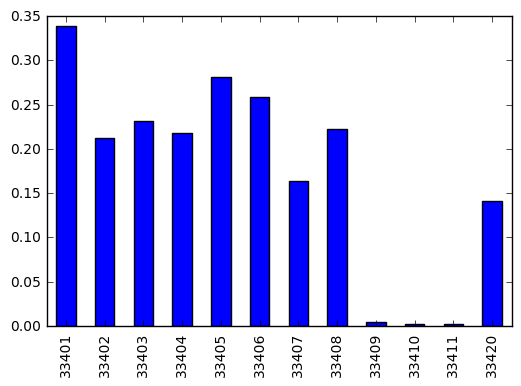

In [81]:
train_data01_merge_label_city_org_no_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'CITY_ORG_NO',split_by_tag=True,tag_name='TAG')

##### 3-7-1-2 测试集

In [82]:
# 当该字段为空情况下，有 0个工单
print test_data01_merge_label_df.loc[test_data01_merge_label_df['CITY_ORG_NO'].isnull()].shape

(0, 15)


(12,)


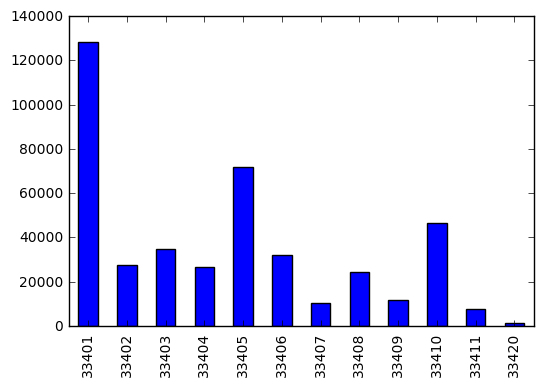

In [83]:
test_data01_merge_label_city_org_no_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'CITY_ORG_NO')

##### 3-7-1-3 合并结果

In [86]:
temp = train_data01_merge_label_city_org_no_count_df.join(
    test_data01_merge_label_city_org_no_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['CITY_ORG_NO']
temp = temp.drop(labels = [u'CITY_ORG_NO'],axis=1)
print '所有工单 - 所属市（区）公司供电单位编码 CITY_ORG_NO'
print temp

所有工单 - 所属市（区）公司供电单位编码 CITY_ORG_NO
        total    tag0  tag0/total    tag1  tag1/total  test_total
33401  432944  286104    0.660834  146840    0.339166      128475
33405  203431  146238    0.718858   57193    0.281142       71736
33406   84775   62893    0.741881   21882    0.258119       32190
33403   86659   66633    0.768910   20026    0.231090       34724
33408   65184   50703    0.777844   14481    0.222156       24574
33404   67020   52413    0.782050   14607    0.217950       26752
33402   72912   57393    0.787154   15519    0.212846       27700
33407   21298   17806    0.836041    3492    0.163959       10360
33420    5237    4500    0.859271     737    0.140729        1451
33409   25903   25785    0.995445     118    0.004555       11754
33411   17842   17804    0.997870      38    0.002130        7689
33410  106993  106791    0.998112     202    0.001888       46323


#### 3-7-2 代表工单下

##### 3-7-2-1 训练集

In [101]:
# 当该字段为空情况下，有 0个工单
print train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['CITY_ORG_NO'].isnull()].shape

(0, 16)


(12, 5)


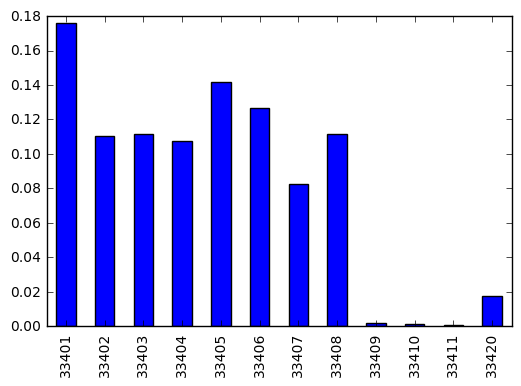

In [106]:
# 当该字段为不空情况下
train_data01_a_worker_per_user_city_org_no_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'CITY_ORG_NO',split_by_tag=True,tag_name='TAG')

##### 3-7-2-2 测试集

In [103]:
# 当该字段为空情况下，有 0个工单
print test_data01_a_worker_per_user.loc[test_data01_a_worker_per_user['CITY_ORG_NO'].isnull()].shape

(0, 15)


(12,)


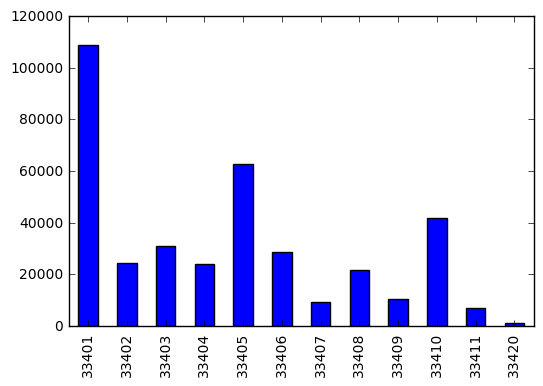

In [104]:
test_data01_a_worker_per_user_city_org_no_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'CITY_ORG_NO')

##### 3-7-2-3 合并结果

In [108]:
temp = train_data01_a_worker_per_user_city_org_no_count_df.join(
    test_data01_a_worker_per_user_city_org_no_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['CITY_ORG_NO']
temp = temp.drop(labels = [u'CITY_ORG_NO'],axis=1)
print '代表工单 -所属市（区）公司供电单位编码 CITY_ORG_NO'
print temp

代表工单 -所属市（区）公司供电单位编码 CITY_ORG_NO
        total    tag0  tag0/total   tag1  tag1/total  test_total
33401  213976  176303    0.823938  37673    0.176062      108752
33405  112184   96258    0.858037  15926    0.141963       62553
33406   48440   42314    0.873534   6126    0.126466       28622
33403   51437   45701    0.888485   5736    0.111515       30863
33408   38071   33826    0.888498   4245    0.111502       21720
33402   42215   37563    0.889802   4652    0.110198       24545
33404   40391   36062    0.892823   4329    0.107177       23953
33407   14672   13464    0.917666   1208    0.082334        9452
33420    1561    1534    0.982703     27    0.017297        1064
33409   16785   16758    0.998391     27    0.001609       10615
33410   67441   67375    0.999021     66    0.000979       41823
33411   11204   11194    0.999107     10    0.000893        6909


###### 小结
- 有价值
- 比如 33410、33409、33411 -- 显然都是不敏感用户的关键信息

### 3-8 受理意见 HANDLE_OPINION

In [ ]:
# 当该字段为空情况下
show_attribute_detail(
    data01_train_merge_label_df.loc[data01_train_merge_label_df['HANDLE_OPINION'].isnull()],
    attribute_name='TAG',
);

In [ ]:
# 数量比较多，导出分析
save_data(
    data01_train_merge_label_df.loc[data01_train_merge_label_df['HANDLE_OPINION'].notnull(),['HANDLE_OPINION','TAG']],
    'handle_opinion.csv'
)

###### 小结
- 经表格分析，没发现规律

### 3-9 受理时间 HANDLE_TIME

#### 3-9-1 所有工单下

#### 3-9-1-1 训练集

In [10]:
%%time
# 将受理时间进行编码，映射到 年 月 日 小时

# 时
train_data01_merge_label_df.loc[:,'HANDLE_HOUR'] = \
    train_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='hour'))
# 年
train_data01_merge_label_df.loc[:,'HANDLE_YEAR'] = \
    train_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='year'))
# 月
train_data01_merge_label_df.loc[:,'HANDLE_MONTH'] = \
    train_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='month'))
# 日
train_data01_merge_label_df.loc[:,'HANDLE_DAY'] = \
    train_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='day'))
print train_data01_merge_label_df.head()

             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280016584  1000000527201688               1               2.0   
1  2015101280016722  1000000527203612               3               2.0   
2  2015101280016734  1000000527203685               3               2.0   
3  2015101280019989  1000000527220221               3               1.0   
4  2015101280020073  1000000527220797               3               1.0   

      ORG_NO         HANDLE_TIME  \
0    3340501  2015/10/12 7:27:08   
1    3341020  2015/10/12 7:31:50   
2    3340670  2015/10/12 7:32:03   
3    3340401  2015/10/12 8:04:42   
4  334010101  2015/10/12 8:06:05   

                                    ACCEPT_CONTENT HANDLE_OPINION  CALLING_NO  \
0  【一户无电】非居民客户报修一户无电，经指导客户检查，无法判断设备故障及其资产归属，请现场查处。            NaN   1625671.0   
1                                 【银行代扣】客户咨询银行代扣事宜            NaN   1196922.0   
2                            【查询电费】客户查询本月电费金额，已告知。            NaN   1378624.0   
3       

In [ ]:
show_attribute_detail(train_data01_merge_label_df,'HANDLE_HOUR',split_by_tag=True,tag_name='TAG')

In [ ]:
show_attribute_detail(train_data01_merge_label_df,'HANDLE_YEAR',split_by_tag=True,tag_name='TAG')

(12, 5)


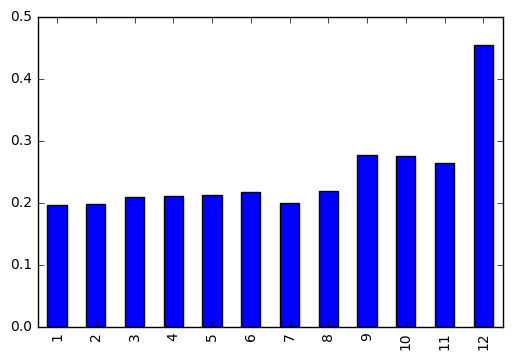

In [33]:
train_data01_merge_label_handle_month_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'HANDLE_MONTH',split_by_tag=True,tag_name='TAG')

In [ ]:
show_attribute_detail(data01_train_merge_label_df,'HANDLE_DAY',split_by_tag=True,tag_name='TAG')

##### 3-9-1-1-2 统计 每个用户的 出现在 第4季度（9-12） 的次数

In [17]:
train_data01_custno_handle_month_rdd = \
    sc.parallelize(train_data01_merge_label_df[['CUST_NO','HANDLE_MONTH']].as_matrix())
train_data01_custno_handle_month_rdd.cache()

ParallelCollectionRDD[6] at parallelize at PythonRDD.scala:475

In [18]:
%%time
train_custno_in_season4_count_rdd = train_data01_custno_handle_month_rdd.groupBy(lambda x:x[0]).mapValues(
    lambda items: sum([x[1]>=9 for x in items ])
)
train_custno_in_season4_count_dict = train_custno_in_season4_count_rdd.collectAsMap()

CPU times: user 448 ms, sys: 28 ms, total: 476 ms
Wall time: 16.4 s


In [54]:
len(train_custno_in_season4_count_dict) == 658374

True

##### 3-9-1-1-3 新增字段 NUM_OF_IN_SEASON4 标识 用户 第4季度（9-12） 的记录个数

In [19]:
train_data01_merge_label_df['NUM_OF_IN_SEASON4'] = \
    train_data01_merge_label_df['CUST_NO'].map(train_custno_in_season4_count_dict)

###### 3-9-1-1-4 统计

(31, 5)


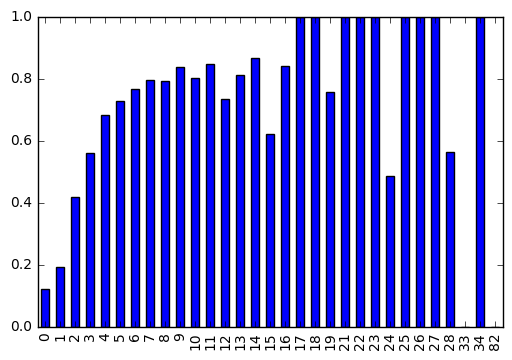

In [45]:
train_data01_merge_label_num_of_season4_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'NUM_OF_IN_SEASON4',split_by_tag=True,tag_name='TAG').sort_values(by='tag1/total',ascending=False)

In [49]:
save_data(
    train_data01_merge_label_df[train_data01_merge_label_df['TAG']==1][['APP_NO','CUST_NO','HANDLE_TIME','HANDLE_MONTH']].sort_values(by='CUST_NO')[:1000],
    'handle_time.csv'
)

#### 3-9-1-2 测试集

In [76]:
%%time
# 将受理时间进行编码，映射到 年 月 日 小时

# 时
test_data01_merge_label_df.loc[:,'HANDLE_HOUR'] = \
    test_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='hour'))
# 年
test_data01_merge_label_df.loc[:,'HANDLE_YEAR'] = \
    test_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='year'))
# 月
test_data01_merge_label_df.loc[:,'HANDLE_MONTH'] = \
    test_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='month'))
# 日
test_data01_merge_label_df.loc[:,'HANDLE_DAY'] = \
    test_data01_merge_label_df['HANDLE_TIME'].apply(lambda x: data_feature_encoder.get_date(x,type='day'))
print test_data01_merge_label_df.head()

             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280019632  1000000527215943               3               1.0   
1  2015101280019648  1000000527216033              10               2.0   
2  2015101280019680  1000000527216202               3               2.0   
3  2015101280019873  1000000527218491               3               1.0   
4  2015101280020130  1000000527221199               1               1.0   

      ORG_NO         HANDLE_TIME  \
0    3340780  2015/10/12 7:58:04   
1  334066001  2015/10/12 7:58:26   
2    3340690  2015/10/12 7:58:52   
3    3340810  2015/10/12 8:02:53   
4    3340501  2015/10/12 8:07:10   

                                      ACCEPT_CONTENT HANDLE_OPINION  \
0   【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。            NaN   
1  【退订】#2061584501；【退订】#2061584602；【退订】#406091928...            NaN   
2                                【查询电费】客户查询本月电费，已告知。            NaN   
3                           【咨询总户号】通过地址、户名查询户号信息

(12,)


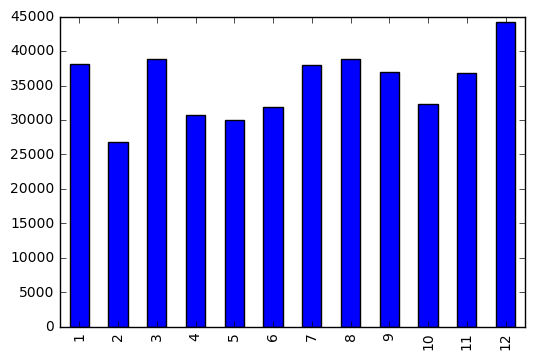

In [37]:
test_data01_merge_label_handle_month_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'HANDLE_MONTH')

##### 3-9-1-2-1 统计 每个用户的 出现在 第4季度（9-12） 的次数

In [45]:
test_data01_custno_handle_month_rdd = \
    sc.parallelize(test_data01_merge_label_df[['CUST_NO','HANDLE_MONTH']].as_matrix())
test_data01_custno_handle_month_rdd.cache()

ParallelCollectionRDD[24] at parallelize at PythonRDD.scala:475

In [46]:
%%time
test_custno_in_season4_count_rdd = test_data01_custno_handle_month_rdd.groupBy(lambda x:x[0]).mapValues(
    lambda items: sum([x[1]>=9 for x in items ])
)
test_custno_in_season4_count_dict = test_custno_in_season4_count_rdd.collectAsMap()

CPU times: user 312 ms, sys: 28 ms, total: 340 ms
Wall time: 8.17 s


In [62]:
len(test_custno_in_season4_count_dict)

370871

##### 3-9-1-2-3 新增字段 NUM_OF_IN_SEASON4 标识 用户 第4季度（9-12） 的记录个数

In [47]:
test_data01_merge_label_df['NUM_OF_IN_SEASON4'] = \
    test_data01_merge_label_df['CUST_NO'].map(test_custno_in_season4_count_dict)

(8,)


0    262157
1    135137
2     21165
3      4150
4       829
5       242
6        33
7        15
Name: NUM_OF_IN_SEASON4, dtype: int64

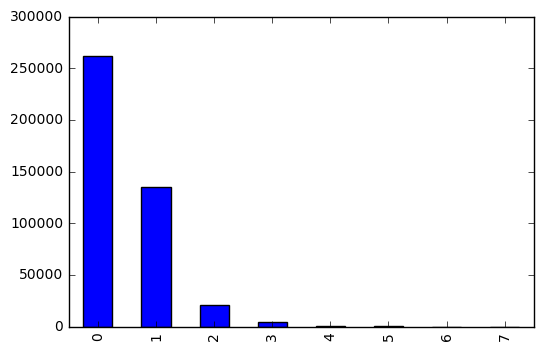

In [66]:
show_attribute_detail(test_data01_merge_label_df,'NUM_OF_IN_SEASON4')

(8,)


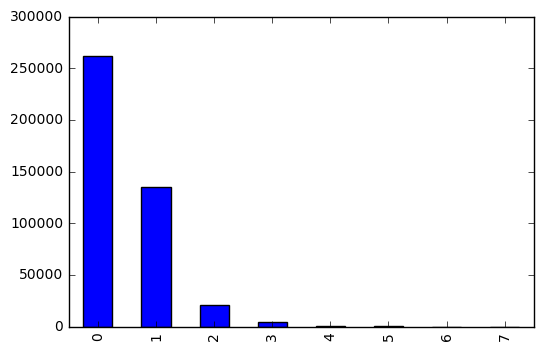

In [41]:
test_data01_merge_label_num_of_season4_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'NUM_OF_IN_SEASON4')

In [46]:
temp = train_data01_merge_label_num_of_season4_count_df.join(
    test_data01_merge_label_num_of_season4_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['NUM_OF_IN_SEASON4']
temp = temp.drop(labels = [u'NUM_OF_IN_SEASON4'],axis=1)
print '所有工单 -受理时间 NUM_OF_IN_SEASON4'
print temp

所有工单 -受理时间 NUM_OF_IN_SEASON4
     total      tag0  tag0/total     tag1  tag1/total  test_total
22      81       0.0    0.000000     81.0    1.000000         0.0
23      82       0.0    0.000000     82.0    1.000000         0.0
27     125       0.0    0.000000    125.0    1.000000         0.0
26      90       0.0    0.000000     90.0    1.000000         0.0
21      42       0.0    0.000000     42.0    1.000000         0.0
18     139       0.0    0.000000    139.0    1.000000         0.0
17     205       0.0    0.000000    205.0    1.000000         0.0
25      70       0.0    0.000000     70.0    1.000000         0.0
34      83       0.0    0.000000     83.0    1.000000         0.0
14     562      74.0    0.131673    488.0    0.868327         0.0
11    1535     235.0    0.153094   1300.0    0.846906         0.0
16     362      57.0    0.157459    305.0    0.842541         0.0
9     3149     510.0    0.161956   2639.0    0.838044         0.0
13     818     155.0    0.189487    663.0    0.

#### 3-9-2 代表工单下

#### 3-9-2-1 训练集

###### 3-9-2-1-1 月份统计

(12, 5)


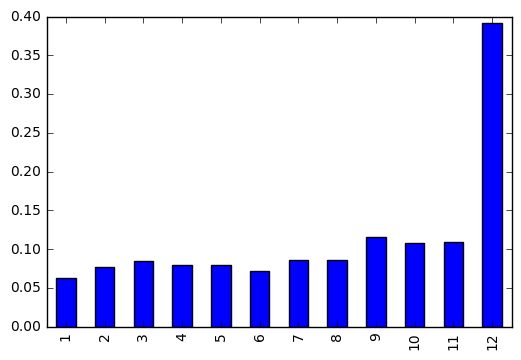

In [43]:
train_data01_a_worker_per_user_handle_month_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'HANDLE_MONTH',split_by_tag=True,tag_name='TAG')

###### 3-9-2-1-1 第4季度记录数统计

(31, 5)


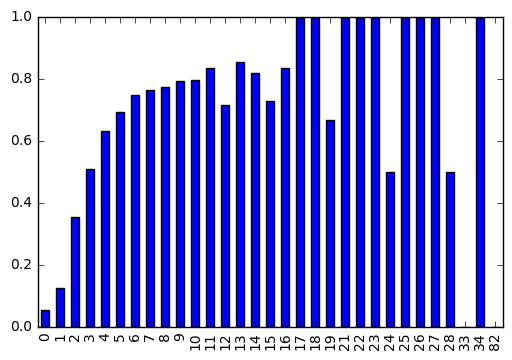

In [51]:
train_data01_a_worker_per_user_num_of_season4_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'NUM_OF_IN_SEASON4',split_by_tag=True,tag_name='TAG')

#### 3-9-2-2 测试集

###### 3-9-2-2-1 月份统计

(12,)


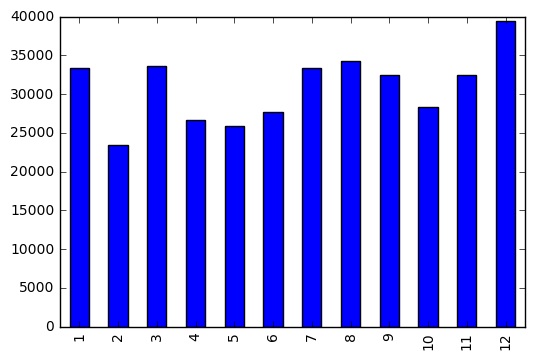

In [44]:
test_data01_a_worker_per_user_handle_month_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'HANDLE_MONTH')

###### 3-9-2-2-2 第4季度记录数统计

(8,)


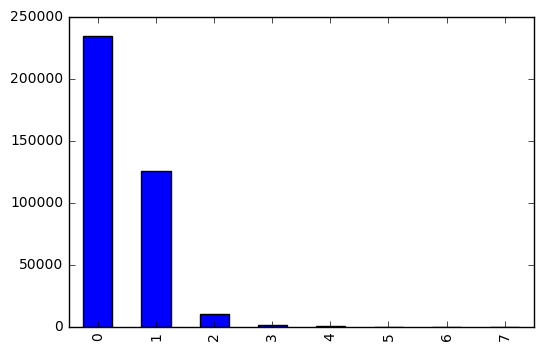

In [52]:
test_data01_a_worker_per_user_num_of_season4_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'NUM_OF_IN_SEASON4')

##### 3-9-2-3 合并结果

###### 3-9-2-3-1 月份统计

In [45]:
temp = train_data01_a_worker_per_user_handle_month_count_df.join(
    test_data01_a_worker_per_user_handle_month_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['HANDLE_MONTH']
temp = temp.drop(labels = [u'HANDLE_MONTH'],axis=1)
print '代表工单 -受理时间 HANDLE_TIME'
print temp

代表工单 -受理时间 HANDLE_TIME
    total   tag0  tag0/total   tag1  tag1/total  test_total
12  73884  44933    0.608156  28951    0.391844       39385
9   54781  48414    0.883774   6367    0.116226       32418
11  53990  48108    0.891054   5882    0.108946       32415
10  46807  41747    0.891897   5060    0.108103       28286
7   61924  56591    0.913878   5333    0.086122       33410
8   60301  55138    0.914380   5163    0.085620       34245
3   62724  57373    0.914690   5351    0.085310       33674
5   47590  43819    0.920761   3771    0.079239       25844
4   49081  45192    0.920764   3889    0.079236       26645
2   43026  39722    0.923209   3304    0.076791       23501
6   48162  44716    0.928450   3446    0.071550       27730
1   56107  52599    0.937477   3508    0.062523       33318


###### 3-9-2-2-2 第4季度记录数统计

In [53]:
temp = train_data01_a_worker_per_user_num_of_season4_count_df.join(
    test_data01_a_worker_per_user_num_of_season4_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['NUM_OF_IN_SEASON4']
temp = temp.drop(labels = [u'NUM_OF_IN_SEASON4'],axis=1)
print '代表工单 -受理时间 NUM_OF_IN_SEASON4'
print temp

代表工单 -受理时间 NUM_OF_IN_SEASON4
     total      tag0  tag0/total     tag1  tag1/total  test_total
17       8       0.0    0.000000      8.0    1.000000         0.0
22       2       0.0    0.000000      2.0    1.000000         0.0
27       3       0.0    0.000000      3.0    1.000000         0.0
26       3       0.0    0.000000      3.0    1.000000         0.0
25       1       0.0    0.000000      1.0    1.000000         0.0
23       2       0.0    0.000000      2.0    1.000000         0.0
21       1       0.0    0.000000      1.0    1.000000         0.0
34       1       0.0    0.000000      1.0    1.000000         0.0
18       4       0.0    0.000000      4.0    1.000000         0.0
13      34       5.0    0.147059     29.0    0.852941         0.0
11      85      14.0    0.164706     71.0    0.835294         0.0
16      12       2.0    0.166667     10.0    0.833333         0.0
14      22       4.0    0.181818     18.0    0.818182         0.0
10     123      25.0    0.203252     98.0    0.

###### 小结
- 全部数据都是 2015 年
- 第4季度的敏感度高很多，可能 HANDLE_MONTH 有价值
- 每天的数据都很均匀，没有多大价值

- 训练数据集上  月份的分布差异很大 ——> 所以可能月份是个非常重要的特征

### 3-10 城乡类别标志 URBAN_RURAL_FLAG

#### 3-10-1所有工单下

#### 3-10-1-1 训练集

(1004, 17)
(2,)


0    570
1     18
Name: TAG, dtype: int64

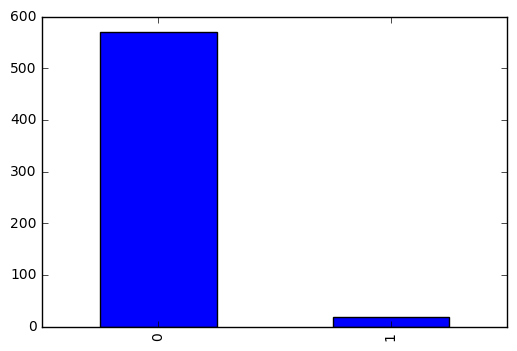

In [110]:
# 当该字段为空情况下，有 1004个工单，其中非敏感570,敏感 18
print train_data01_merge_label_df.loc[train_data01_merge_label_df['URBAN_RURAL_FLAG'].isnull()].shape
show_attribute_detail(
    train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['URBAN_RURAL_FLAG'].isnull()],
    attribute_name='TAG',
)

(3, 5)


,total,tag0,tag0/total,tag1,tag1/total
1.0,396883,343008,0.864255,53875,0.135745
2.0,259578,233488,0.899491,26090,0.100509
3.0,1328,1286,0.968373,42,0.031627


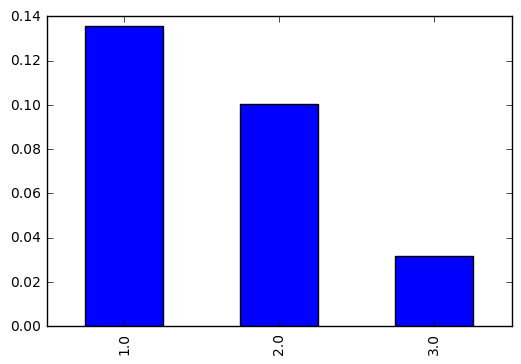

In [112]:
show_attribute_detail(train_data01_a_worker_per_user,'URBAN_RURAL_FLAG',split_by_tag=True,tag_name='TAG')

In [ ]:
len(data01_train_merge_label_df['URBAN_RURAL_FLAG'].unique())

(3, 5)


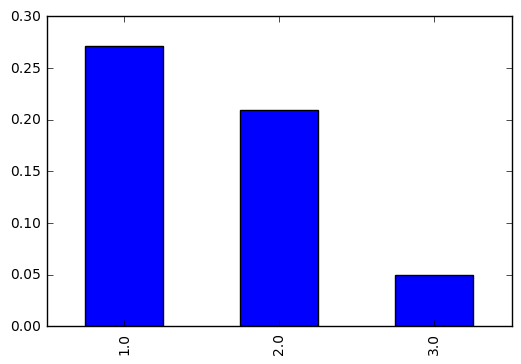

In [113]:
train_data01_merge_label_urban_rural_flag_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'URBAN_RURAL_FLAG',split_by_tag=True,tag_name='TAG')

##### 3-10-1-2 测试集

In [114]:
# 当该字段为空情况下，有 448个工单
print test_data01_merge_label_df.loc[test_data01_merge_label_df['URBAN_RURAL_FLAG'].isnull()].shape

(448, 15)


(3,)


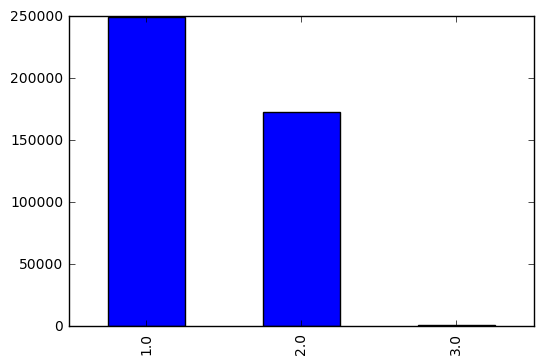

In [115]:
test_data01_merge_label_urban_rural_flag_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'URBAN_RURAL_FLAG')

##### 3-10-1-3 合并结果

In [118]:
temp = train_data01_merge_label_urban_rural_flag_count_df.join(
    test_data01_merge_label_urban_rural_flag_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['URBAN_RURAL_FLAG']
temp = temp.drop(labels = [u'URBAN_RURAL_FLAG'],axis=1)
print '所有工单 - 城乡类别标志 URBAN_RURAL_FLAG'
print temp

所有工单 - 城乡类别标志 URBAN_RURAL_FLAG
      total    tag0  tag0/total    tag1  tag1/total  test_total
1.0  745444  543091    0.728547  202353    0.271453      249416
2.0  441830  349262    0.790490   92568    0.209510      172920
3.0    1920    1824    0.950000      96    0.050000         944


#### 3-10-2 代表工单下

##### 3-10-2-1 训练集

(588, 16)
(2,)


0    570
1     18
Name: TAG, dtype: int64

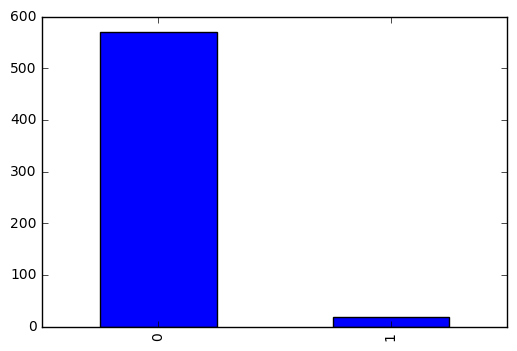

In [119]:
# 当该字段为空情况下，有 588个工单，不敏感570,敏感18
print train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['URBAN_RURAL_FLAG'].isnull()].shape
show_attribute_detail(
    train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['URBAN_RURAL_FLAG'].isnull()],
    attribute_name='TAG',
)

(3, 5)


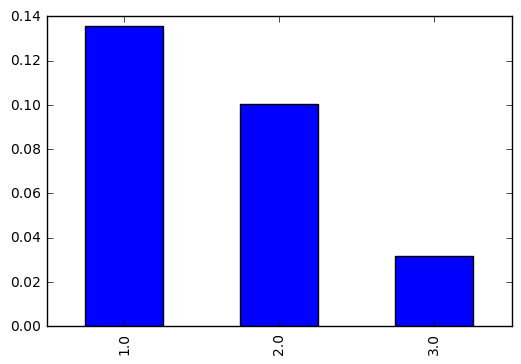

In [120]:
# 当该字段为不空情况下
train_data01_a_worker_per_user_urban_rural_flag_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'URBAN_RURAL_FLAG',split_by_tag=True,tag_name='TAG')

##### 3-10-2-2 测试集

In [121]:
# 当该字段为空情况下，有 401个工单
print test_data01_a_worker_per_user.loc[test_data01_a_worker_per_user['URBAN_RURAL_FLAG'].isnull()].shape

(401, 15)


(3,)


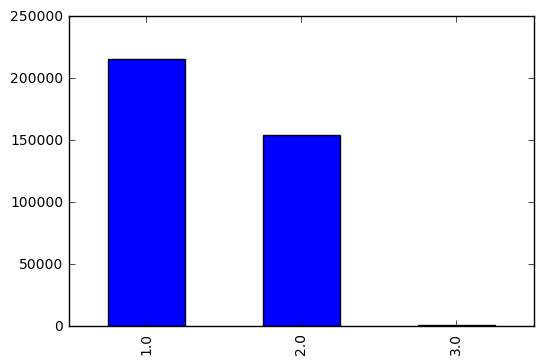

In [122]:
test_data01_a_worker_per_user_urban_rural_flag_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'URBAN_RURAL_FLAG')

##### 3-10-2-3 合并结果

In [123]:
temp = train_data01_a_worker_per_user_urban_rural_flag_count_df.join(
    test_data01_a_worker_per_user_urban_rural_flag_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['URBAN_RURAL_FLAG']
temp = temp.drop(labels = [u'URBAN_RURAL_FLAG'],axis=1)
print '代表工单 -城乡类别标志 URBAN_RURAL_FLAG'
print temp

代表工单 -城乡类别标志 URBAN_RURAL_FLAG
      total    tag0  tag0/total   tag1  tag1/total  test_total
1.0  396883  343008    0.864255  53875    0.135745      215343
2.0  259578  233488    0.899491  26090    0.100509      154263
3.0    1328    1286    0.968373     42    0.031627         864


###### 小结
- 类别3（特殊边远山区）  的敏感度最低 ， 有价值

### 3-11 用电类别 ELEC_TYPE

#### 3-11-1 所有工单下

##### 3-11-1-1 训练集

(254028, 16)
(2,)


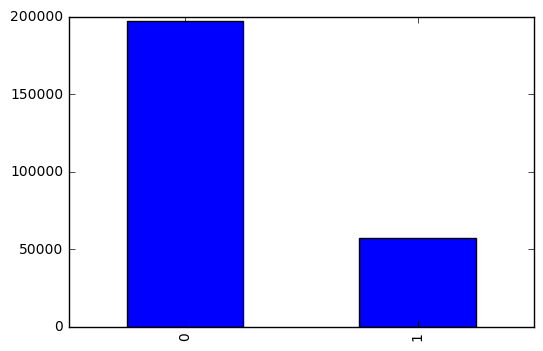

In [60]:
# 当该字段为空情况下，有 254028个工单，其中 196990个不敏感，57038个敏感
print train_data01_merge_label_df.loc[train_data01_merge_label_df['ELEC_TYPE'].isnull()].shape
show_attribute_detail(
    train_data01_merge_label_df.loc[train_data01_merge_label_df['ELEC_TYPE'].isnull()],
    attribute_name='TAG',
)

(19, 5)


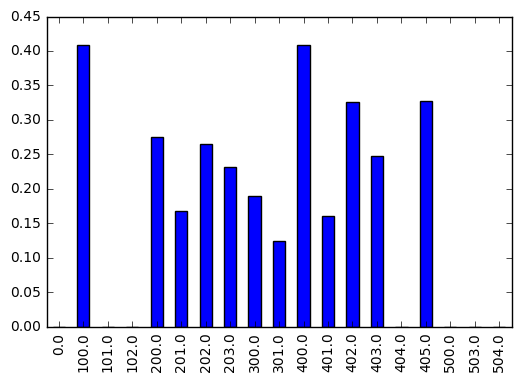

In [64]:
train_data01_merge_label_elec_type_count_df = \
    show_attribute_detail(train_data01_merge_label_df,'ELEC_TYPE',split_by_tag=True,tag_name='TAG')

##### 3-11-1-2 测试集

In [58]:
# 当该字段为空情况下，有 89812个工单
print test_data01_merge_label_df.loc[test_data01_merge_label_df['ELEC_TYPE'].isnull()].shape

(89812, 15)


(18,)


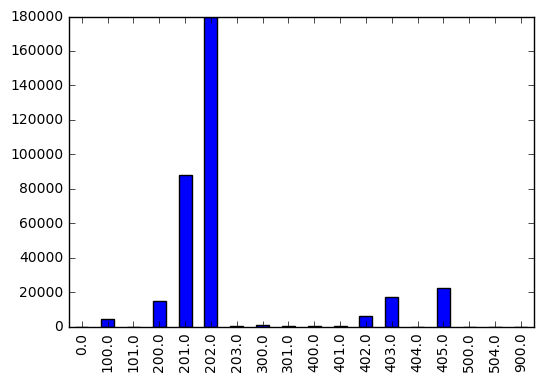

In [62]:
test_data01_merge_label_elec_type_count_df = \
    show_attribute_detail(test_data01_merge_label_df,'ELEC_TYPE')

##### 3-11-1-3 合并结果

In [78]:
temp = train_data01_merge_label_elec_type_count_df.join(
    test_data01_merge_label_elec_type_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['ELEC_TYPE']
temp = temp.drop(labels = [u'ELEC_TYPE'],axis=1)
temp

,total,tag0,tag0/total,tag1,tag1/total,test_total
100.0,26773.0,15820.0,0.590894,10953.0,0.409106,4372.0
400.0,186.0,110.0,0.591398,76.0,0.408602,42.0
405.0,72102.0,48535.0,0.673144,23567.0,0.326856,22276.0
402.0,20667.0,13922.0,0.673634,6745.0,0.326366,5989.0
200.0,42112.0,30525.0,0.724853,11587.0,0.275147,14576.0
202.0,519338.0,381384.0,0.734366,137954.0,0.265634,179996.0
403.0,55050.0,41404.0,0.752116,13646.0,0.247884,17291.0
203.0,407.0,313.0,0.769042,94.0,0.230958,162.0
300.0,2483.0,2014.0,0.811116,469.0,0.188884,1099.0
201.0,196417.0,163493.0,0.832377,32924.0,0.167623,87808.0


#### 3-11-2 代表工单下

##### 3-11-2-1 训练集

(137439, 16)
(2,)


0    122466
1     14973
Name: TAG, dtype: int64

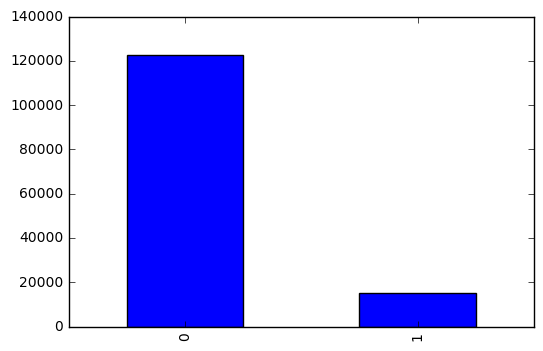

In [55]:
# 当该字段为空情况下，有 137439个工单，其中 122466个不敏感，14973个敏感
print train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['ELEC_TYPE'].isnull()].shape
show_attribute_detail(
    train_data01_a_worker_per_user.loc[train_data01_a_worker_per_user['ELEC_TYPE'].isnull()],
    attribute_name='TAG',
)

(19, 5)


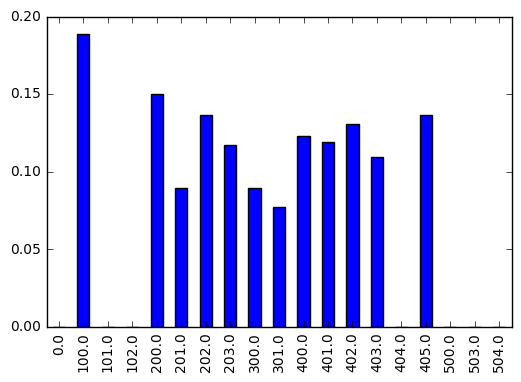

In [61]:
train_data01_a_worker_per_user_elec_type_count_df = \
    show_attribute_detail(train_data01_a_worker_per_user,'ELEC_TYPE',split_by_tag=True,tag_name='TAG')

##### 3-11-2-2 测试集

In [95]:
# 当该字段为空情况下，有 78122个工单
print test_data01_a_worker_per_user.loc[test_data01_a_worker_per_user['ELEC_TYPE'].isnull()].shape

(78122, 15)


(18,)


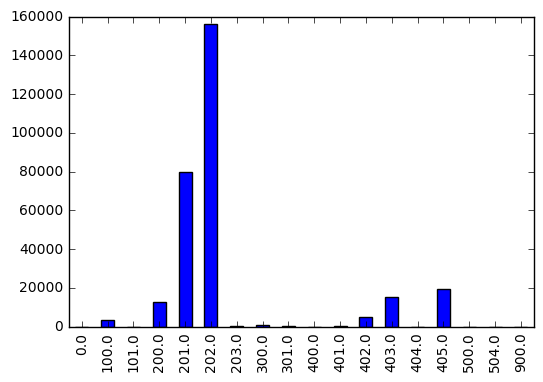

In [97]:
test_data01_a_worker_per_user_elec_type_count_df = \
    show_attribute_detail(test_data01_a_worker_per_user,'ELEC_TYPE')

##### 3-11-2-3 合并结果

In [99]:
temp = train_data01_a_worker_per_user_elec_type_count_df.join(
    test_data01_a_worker_per_user_elec_type_count_df,
    how='outer',
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['ELEC_TYPE']
temp = temp.drop(labels = [u'ELEC_TYPE'],axis=1)
print '代表工单 -用电类别 ELEC_TYPE'
print temp

代表工单 -用电类别 ELEC_TYPE
          total      tag0  tag0/total     tag1  tag1/total  test_total
100.0    8532.0    6920.0    0.811064   1612.0    0.188936      3459.0
200.0   23228.0   19742.0    0.849923   3486.0    0.150077     12597.0
202.0  286239.0  247094.0    0.863244  39145.0    0.136756    155912.0
405.0   35136.0   30342.0    0.863559   4794.0    0.136441     19418.0
402.0    9640.0    8379.0    0.869191   1261.0    0.130809      5174.0
400.0      65.0      57.0    0.876923      8.0    0.123077        34.0
401.0      84.0      74.0    0.880952     10.0    0.119048        47.0
203.0     239.0     211.0    0.882845     28.0    0.117155       143.0
403.0   28267.0   25171.0    0.890473   3096.0    0.109527     15188.0
201.0  127640.0  116190.0    0.910295  11450.0    0.089705     79539.0
300.0    1506.0    1371.0    0.910359    135.0    0.089641       995.0
301.0     351.0     324.0    0.923077     27.0    0.076923       234.0
504.0       4.0       4.0    1.000000      0.0    0.0000

###### 小结
- 工业性的用电 敏感度高，比如 400（一般工商业）、100（大工业用电）、405（商业用电）、402（非工业）

---------
### 实收电费信息表 和 应收电费信息表  09_ARC_A_RCVBL_FLOW - 特征探索

### 3-12 供电单位编号 ORG_NO     

#### 3-12-1 所有记录统计

##### 3-12-1-1 训练集

In [9]:
train_data09_merge_label_df_org_no_count_df = show_attribute_detail(
    train_data09_merge_label_df,
    'ORG_NO',
    split_by_tag=True, 
    tag_name='TAG', 
    show_pic=False
)
train_data09_merge_label_df_org_no_count_df.shape

(754, 5)


(754, 5)

##### 3-12-1-2 测试集

In [10]:
test_data09_merge_label_df_org_no_count_df = show_attribute_detail(
    test_data09_merge_label_df,
    'ORG_NO',
    show_pic=False
)

(621,)


##### 3-12-1-3 合并结果

In [16]:
temp = train_data09_merge_label_df_org_no_count_df.join(
    test_data09_merge_label_df_org_no_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['ORG_NO']
temp = temp.drop(labels = [u'ORG_NO'],axis=1)
print '所有data09 -供电单位编号 ORG_NO'
print temp
# 数据太多了，输出分析
save_data(
    temp,
    'train&test_data09_merge_label_df_org_no_count.csv',
    index=True
)

所有data09 -供电单位编号 ORG_NO
              total    tag0  tag0/total    tag1  tag1/total  test_total
33406800136    49.0     0.0    0.000000    49.0    1.000000        66.0
3340901        20.0     7.0    0.350000    13.0    0.650000        13.0
33406600107   561.0   290.0    0.516934   271.0    0.483066       212.0
3340201       483.0   267.0    0.552795   216.0    0.447205        95.0
33401010911  6017.0  3357.0    0.557919  2660.0    0.442081         0.0
3340601        75.0    43.0    0.573333    32.0    0.426667        24.0
33406600130  4223.0  2436.0    0.576841  1787.0    0.423159      2165.0
3340501       884.0   512.0    0.579186   372.0    0.420814       487.0
33401010912  1911.0  1168.0    0.611198   743.0    0.388802         0.0
33410400160    34.0    21.0    0.617647    13.0    0.382353         5.0
33406600190  1030.0   637.0    0.618447   393.0    0.381553       543.0
33406600180  1615.0  1012.0    0.626625   603.0    0.373375       588.0
33401010530  3022.0  1904.0    0.630046 

#### 3-12-1 按用户统计 (因为 一个用户会有多个org_no，所以这里做截断处理，剩下7位，保证 一个用户只有一个org_no)

##### 3-12-1-1 训练集

In [37]:
%%time
# 尝试
truncate_len = 9
temp = train_data09_merge_label_df.groupby(
    by='CONS_NO',axis=0)['ORG_NO'].apply(
    lambda x :len(set([unicode(item)[:truncate_len] for item in x 
                      ]))
)
# 仍然有两个 
print temp[temp>1].shape
pd.Series.str.slice()

(2,)
CPU times: user 35 s, sys: 740 ms, total: 35.8 s
Wall time: 35.6 s


In [23]:
train_data09_merge_label_df['ORG_NO'].dtypes

dtype('O')

In [30]:
save_data(
    train_data01_a_worker_per_user[['ORG_NO','CITY_ORG_NO','ORG_NO_7bit']],
    'temp.csv'
)


In [32]:
%%time
truncate_len = 8
train_data09_merge_label_df['ORG_NO_%dbit'%truncate_len] = \
    train_data09_merge_label_df['ORG_NO'].str.slice(0,truncate_len)

CPU times: user 3.33 s, sys: 1.77 s, total: 5.1 s
Wall time: 14.4 s


In [34]:
train_data09_merge_label_df[['CONS_NO','ORG_NO_8bit']].drop_duplicates().shape

(645179, 2)

In [35]:
%%time
temp = train_data09_merge_label_df.groupby('CONS_NO')['ORG_NO_8bit'].apply(lambda x :len(set(x)))

CPU times: user 1min 19s, sys: 1.66 s, total: 1min 20s
Wall time: 1min 21s


In [36]:
temp.head()

CONS_NO
0002471802    2
0002471815    2
0002476706    2
0002506278    1
0002507444    1
Name: ORG_NO_8bit, dtype: int64

In [37]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='0002471802']

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG,ORG_NO_8bit
527695,0002471802,201501,33401010428,020311,275,260.15,260.15,1,0.0,0.0,NaN,260.15,2.0,405.0,NaN,NaN,0,33401010
536396,0002471802,201502,33401010428,020311,134,126.76,126.76,1,0.0,0.0,NaN,126.76,2.0,405.0,NaN,NaN,0,33401010
571747,0002471802,201503,33401010428,020311,141,133.39,133.39,1,0.0,0.0,NaN,133.39,2.0,405.0,NaN,NaN,0,33401010
632700,0002471802,201504,33401010428,020311,57,53.92,53.92,1,0.0,0.0,NaN,53.92,2.0,405.0,NaN,NaN,0,33401010
644171,0002471802,201505,33401010428,020311,0,0.00,0.00,1,0.0,0.0,NaN,0.00,2.0,405.0,NaN,NaN,0,33401010
679049,0002471802,201506,33401010428,020311,0,0.00,0.00,1,0.0,0.0,NaN,0.00,2.0,405.0,NaN,NaN,0,33401010
1150637,0002471802,201507,33401011025,020311,0,0.00,0.00,1,0.0,0.0,NaN,0.00,2.0,405.0,NaN,NaN,0,33401011
1292008,0002471802,201508,33401011025,020311,0,0.00,0.00,1,0.0,0.0,NaN,0.00,2.0,405.0,NaN,NaN,0,33401011


In [39]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['CUST_NO']=='0002471802'].iloc[0]

APP_NO                                        2015010938128126
ID                                            1000000240301872
BUSI_TYPE_CODE                                               3
URBAN_RURAL_FLAG                                             1
ORG_NO                                                 3340140
HANDLE_TIME                                  2015/1/9 14:31:53
ACCEPT_CONTENT                              【查询电费】客户查询当月电费，已告知
HANDLE_OPINION                                             NaN
CALLING_NO                                         1.73623e+06
ELEC_TYPE                                                  NaN
CUST_NO                                             0002471802
PROV_ORG_NO                                              33101
CITY_ORG_NO                                              33401
TAG                                                          0
NUM_OF_WORKER                                                1
ACCEPT_CONTENT_TYPE                                    

In [41]:
%%time
%store train_data01_a_worker_per_user 
# del data # This has deleted the variable

Stored 'train_data01_a_worker_per_user' (DataFrame)


##### 增加字段 ORG_NO_7bit

In [40]:
%%time
truncate_len = 7
train_data09_cons_no_truncate_org_no_series = train_data09_merge_label_df.groupby(
        by='CONS_NO',axis=0)['ORG_NO'].apply(lambda x : truncate_org_no(x, truncate_len=7))

# train_data08_merge_label_df['ORG_NO_7bit']

CPU times: user 42.4 s, sys: 1.46 s, total: 43.9 s
Wall time: 44.3 s


In [42]:
train_data09_merge_label_df['ORG_NO_7bit'] = \
    train_data09_merge_label_df['CONS_NO'].map(train_data09_cons_no_truncate_org_no_series)

In [43]:
train_data09_merge_label_df[['CONS_NO','ORG_NO_7bit','TAG']].drop_duplicates().shape

(555748, 3)

###### 统计

In [44]:
train_a_worker_per_user_org_no_count_df = show_attribute_detail(
    train_data09_merge_label_df[['ORG_NO_7bit','CONS_NO','TAG']].drop_duplicates(),
    'ORG_NO_7bit',
    split_by_tag=True, 
    tag_name='TAG', 
    show_pic=False
)
train_a_worker_per_user_org_no_count_df

(75, 5)


,total,tag0,tag0/total,tag1,tag1/total
3340101,148484,117890,0.793958,30594.0,0.206042
3340130,19044,16768,0.880487,2276.0,0.119513
3340140,21607,18997,0.879206,2610.0,0.120794
3340150,3521,3222,0.915081,299.0,0.084919
3340160,5022,4516,0.899243,506.0,0.100757
3340170,7242,6503,0.897956,739.0,0.102044
3340180,3019,2764,0.915535,255.0,0.084465
3340190,2756,2497,0.906023,259.0,0.093977
3340201,19955,17506,0.877274,2449.0,0.122726
3340210,5347,4747,0.887788,600.0,0.112212


##### 添加到 train_data01_a_worker_per_user中

In [51]:
%%time
temp = train_data01_a_worker_per_user.merge(
    train_data09_merge_label_df[['ORG_NO_7bit','CONS_NO']].drop_duplicates(),
    how='left', 
    left_on='CUST_NO',
    right_on='CONS_NO',
)
print temp.shape,sum(temp['ORG_NO_7bit'].isnull())

(658374, 47)
CPU times: user 3.61 s, sys: 476 ms, total: 4.08 s
Wall time: 4.16 s


In [59]:
train_data01_a_worker_per_user['ORG_NO_7bit'] = temp['ORG_NO_7bit']

##### 3-12-1-1 测试集

In [62]:
truncate_len = 7
temp = test_data09_merge_label_df.groupby(
    by='CONS_NO',axis=0)['ORG_NO'].apply(
    lambda x :len(set([unicode(item)[:truncate_len] for item in x 
                      ]))
)
# 无，全部用户都可以截断成功，且对应一个org_no
print temp[temp>1].shape

(0,)


##### 增加字段 ORG_NO_7bit

In [88]:
%%time
truncate_len = 7
test_data09_merge_label_df['ORG_NO_7bit'] = \
    test_data09_merge_label_df['ORG_NO'].apply(lambda x:unicode(x)[:truncate_len])

CPU times: user 1.72 s, sys: 100 ms, total: 1.82 s
Wall time: 1.82 s


In [63]:
%%time
truncate_len = 7
test_data09_cons_no_truncate_org_no_series = test_data09_merge_label_df.groupby(
        by='CONS_NO',axis=0)['ORG_NO'].apply(lambda x : truncate_org_no(x, truncate_len=7))

# train_data08_merge_label_df['ORG_NO_7bit']

CPU times: user 15.8 s, sys: 124 ms, total: 15.9 s
Wall time: 15.9 s


In [64]:
test_data09_merge_label_df['ORG_NO_7bit'] = \
    test_data09_merge_label_df['CONS_NO'].map(test_data09_cons_no_truncate_org_no_series)

In [66]:
test_data09_merge_label_df[['CONS_NO','ORG_NO_7bit']].drop_duplicates().shape

(201702, 2)

In [67]:
test_a_worker_per_user_org_no_count_df = show_attribute_detail(
    test_data09_merge_label_df[['ORG_NO_7bit','CONS_NO']].drop_duplicates(),
    'ORG_NO_7bit',
    show_pic=False
)
test_a_worker_per_user_org_no_count_df.head()

(67,)


3340190     1744
3340201    11356
3340210     3028
3340220     4164
3340230     2641
Name: ORG_NO_7bit, dtype: int64

##### 添加到 test_data01_a_worker_per_user中

In [68]:
%%time
temp = test_data01_a_worker_per_user.merge(
    test_data09_merge_label_df[['ORG_NO_7bit','CONS_NO']].drop_duplicates(),
    how='left', 
    left_on='CUST_NO',
    right_on='CONS_NO',
)
print temp.shape,sum(temp['ORG_NO_7bit'].isnull())

(370871, 46) 169169
CPU times: user 2.02 s, sys: 304 ms, total: 2.32 s
Wall time: 5.04 s


In [69]:
test_data01_a_worker_per_user['ORG_NO_7bit'] = temp['ORG_NO_7bit']

#### 3-12-4 小结
- 不同供电单位，敏感度差异挺大，可以考虑进一步研究

### 3-13 实收年月 RCVED_YM     

#### 3-13-1 训练集

(12, 5)
         total    tag0  tag0/total   tag1  tag1/total
201501  246178  206355    0.838235  39823    0.161765
201502  222141  187005    0.841830  35136    0.158170
201503  288639  238481    0.826226  50158    0.173774
201504  264855  220453    0.832354  44402    0.167646
201505  270376  224940    0.831953  45436    0.168047
201506  267961  223466    0.833950  44495    0.166050
201507  275888  229281    0.831066  46607    0.168934
201508  278303  232139    0.834123  46164    0.165877
201509  279637  233244    0.834096  46393    0.165904
201510  275274  229767    0.834685  45507    0.165315
201511  274438  229987    0.838029  44451    0.161971
201512  306052  252406    0.824716  53646    0.175284


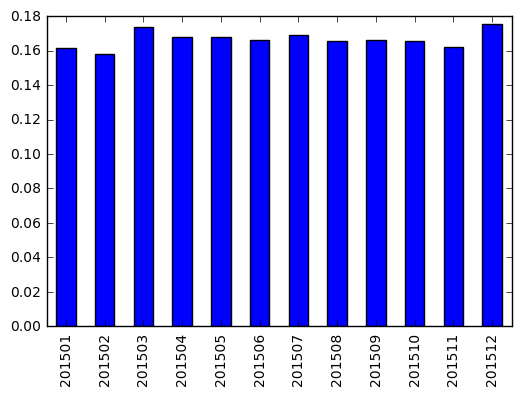

In [160]:
train_data08_merge_label_df_rcved_ym_count_df = show_attribute_detail(
    train_data08_merge_label_df,
    'RCVED_YM',
    split_by_tag=True, 
    tag_name='TAG', 
    show_pic=True
)
print train_data08_merge_label_df_rcved_ym_count_df

#### 3-13-2 测试集

(12,)
201501    291799
201502    266335
201503    325630
201504    305061
201505    308561
201506    306030
201507    311867
201508    316573
201509    318191
201510    312335
201511    312782
201512    335490
Name: RCVED_YM, dtype: int64


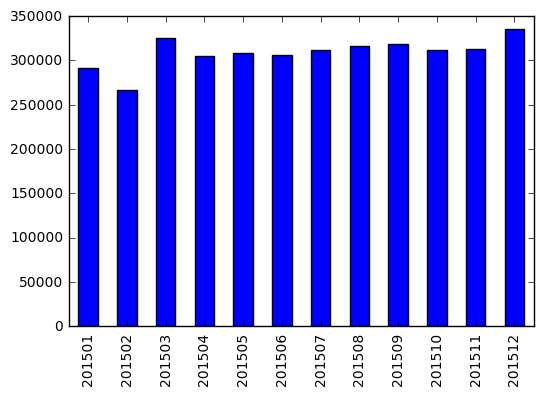

In [161]:
test_data08_merge_label_df_rcved_ym_count_df = show_attribute_detail(
    test_data08_merge_label_df,
    'RCVED_YM',
    show_pic=True
)
print test_data08_merge_label_df_rcved_ym_count_df

#### 3-13-3 小结
- 每个月份都差不多，无价值

### 3-14 应收金额 RCVBL_AMT  ---- > 月平均电费

#### 3-13-1 训练集

In [82]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='6023211298'].sort_values(by='RCVBL_YM')

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,...,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG,ORG_NO_7bit,NUM_OF_MONTHS,RCVBL_AMT_SUM,AVERAGE_RCVBL_AMT
13650,6023211298,201501,334010101,10101.0,45,24.21,24.21,1,0.22,1.0,...,24.21,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
4710,6023211298,201502,334010101,10101.0,44,23.67,23.67,1,0.00,0.0,...,23.67,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
29279,6023211298,201503,334010101,10101.0,12,6.46,6.46,1,0.00,0.0,...,6.46,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
29497,6023211298,201503,334010101,10101.0,-262,-140.96,-140.96,1,0.00,0.0,...,-140.96,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
29498,6023211298,201503,334010101,10101.0,-101,-54.34,-54.34,1,0.00,0.0,...,-54.34,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
48499,6023211298,201504,334010101,10101.0,-36,-19.37,-19.37,1,0.00,0.0,...,-19.37,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
72900,6023211298,201504,334010101,10101.0,0,0.00,0.00,1,0.00,0.0,...,0.00,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
93890,6023211298,201505,334010101,10101.0,0,0.00,0.00,1,0.00,0.0,...,0.00,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
87031,6023211298,201506,334010101,10101.0,0,0.00,0.00,1,0.00,0.0,...,0.00,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833
114294,6023211298,201507,33401010141,10101.0,0,0.00,0.00,1,0.00,0.0,...,0.00,3.0,202.0,NaN,NaN,0,3340101,12,-160.33,-13.360833


In [85]:
train_data08_df[train_data08_df['CONS_NO']=='6023211298']

,ORG_NO,CONS_NO,RCVED_YM,RCVED_DATE,THIS_RCVED_AMT,THIS_PENALTY,OWE_AMT,RCVBL_YM,RCVBL_PENALTY
20025,334010101,6023211298,201502,20150210,24.21,1.0,24.21,201501,0.22
20026,334010101,6023211298,201502,20150210,23.67,0.0,23.67,201502,0.00
31230,334010101,6023211298,201503,20150313,-54.34,0.0,-54.34,201503,0.00
33187,334010101,6023211298,201503,20150313,6.46,0.0,6.46,201503,0.00
44644,334010101,6023211298,201503,20150324,-140.96,0.0,-140.96,201503,0.00
58002,334010101,6023211298,201504,20150423,-19.37,0.0,-19.37,201504,0.00


In [73]:
%%time
# 统计每个用户的 月份数
train_data09_cons_no_rcvbl_ym_count_series = \
    train_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_YM'].apply(lambda x: len(set(x)))

CPU times: user 26.2 s, sys: 1.64 s, total: 27.9 s
Wall time: 35.1 s


In [74]:
%%time
# 统计每个用户的所有 电费总额
train_data09_cons_no_rcvbl_amt_sum_series = train_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_AMT'].sum()

CPU times: user 2.14 s, sys: 144 ms, total: 2.29 s
Wall time: 2.45 s


In [75]:
%%time
# 添加字段 交了多少个月 的电费
train_data09_merge_label_df['NUM_OF_MONTHS'] = \
    train_data09_merge_label_df['CONS_NO'].map(train_data09_cons_no_rcvbl_ym_count_series)
# 添加字段 总电量
train_data09_merge_label_df['RCVBL_AMT_SUM'] = \
    train_data09_merge_label_df['CONS_NO'].map(train_data09_cons_no_rcvbl_amt_sum_series)

CPU times: user 5.26 s, sys: 44 ms, total: 5.3 s
Wall time: 5.34 s


In [78]:
# 添加字段 用户的平均电费 AVERAGE_OWE_AMT
train_data09_merge_label_df['AVERAGE_RCVBL_AMT'] = \
    train_data09_merge_label_df['RCVBL_AMT_SUM']/train_data09_merge_label_df['NUM_OF_MONTHS']
train_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,...,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG,ORG_NO_7bit,NUM_OF_MONTHS,RCVBL_AMT_SUM,AVERAGE_RCVBL_AMT
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,...,1768.07,2.0,403.0,NaN,NaN,0,3340101,8,21116.31,2639.53875
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,...,2640.29,2.0,403.0,NaN,NaN,0,3340101,8,16806.61,2100.82625
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,...,1058.25,3.0,202.0,NaN,NaN,0,3340101,8,9416.90,1177.11250
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,...,3585.80,3.0,201.0,NaN,NaN,0,3340101,8,27228.58,3403.57250
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,...,1561.93,3.0,202.0,NaN,NaN,0,3340101,8,15037.73,1879.71625


(2,)


0    71819
1     8544
Name: TAG, dtype: int64

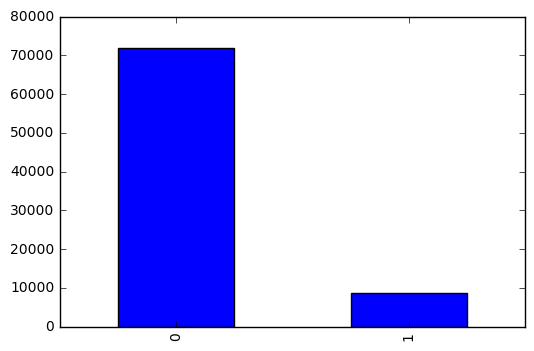

In [86]:
show_attribute_detail(
        train_data09_merge_label_df[train_data09_merge_label_df['AVERAGE_RCVBL_AMT']==0],
    'TAG'
    )

In [97]:
train_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,IS_CONNECT_TO_08TABLE,NUM_OF_RCVBL_PENALTY,IS_CONNECT_TO_06TABLE,CONT_TYPE,IS_CONNECT_TO_07TABLE,CONS_STATUS,STATUS,RCA_FLAG,ORG_NO_7bit,AVERAGE_RCVBL_AMT
0,2015101280016722,1000000527203612,3,2.0,3341020,2015/10/12 7:31:50,【银行代扣】客户咨询银行代扣事宜,NaN,1196922.0,202.0,...,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2015101280031388,1000000527304861,3,1.0,3340901,2015/10/12 9:14:03,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1005636.0,NaN,...,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2015101280031424,1000000527305097,3,2.0,33401,2015/10/12 9:14:16,【查询电费】客户查询电费，已告知。,NaN,1007513.0,405.0,...,1,0.0,0,NaN,0,NaN,NaN,NaN,3340101.0,1652.304167
3,2015101280031680,1000000527300870,3,2.0,334020106,2015/10/12 9:11:37,【咨询总户号】通过地址（户名）查询户号信息。,NaN,1073266.0,202.0,...,1,0.0,0,NaN,0,NaN,NaN,NaN,3340201.0,51.961667
4,2015101280032506,1000000527305664,3,1.0,3340101,2015/10/12 9:14:48,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1433592.0,NaN,...,1,0.0,0,NaN,0,NaN,NaN,NaN,3340150.0,121.936250


##### 添加到 train_data01_a_worker_per_user中

In [94]:
%%time
temp = train_data01_a_worker_per_user.merge(
    train_data09_merge_label_df[['AVERAGE_RCVBL_AMT','CONS_NO']].drop_duplicates(),
    how='left', 
    left_on='CUST_NO',
    right_on='CONS_NO',
)
print temp.shape,sum(temp['AVERAGE_RCVBL_AMT'].isnull())

(658374, 48) 102626
CPU times: user 6.32 s, sys: 376 ms, total: 6.69 s
Wall time: 7.16 s


In [96]:
train_data01_a_worker_per_user['AVERAGE_RCVBL_AMT'] = temp['AVERAGE_RCVBL_AMT']

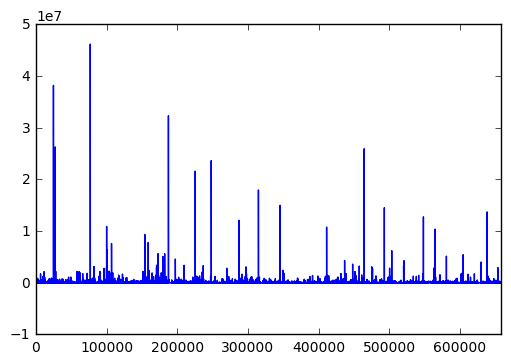

In [98]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['TAG']==1]['AVERAGE_RCVBL_AMT'].plot.line()

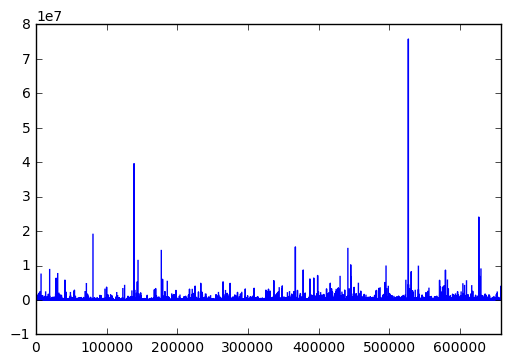

In [99]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['TAG']==0]['AVERAGE_RCVBL_AMT'].plot.line()

#### 3-13-1 测试集

In [71]:
test_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,ORG_NO_7bit
0,8602008462,201509,334019001,20311.0,169,90.92,90.92,1,0.0,0.0,NaN,90.92,3.0,201.0,NaN,8602008462,3340190
1,8664221007,201509,33401900101,20311.0,290,156.02,156.02,1,0.0,0.0,NaN,156.02,3.0,201.0,NaN,8664221007,3340190
2,8664221012,201509,33401900101,20311.0,110,59.18,59.18,1,0.0,0.0,NaN,59.18,3.0,201.0,NaN,8664221012,3340190
3,8602060747,201509,334019001,20311.0,25,13.64,13.64,1,0.0,0.0,NaN,13.64,3.0,202.0,NaN,8602060747,3340190
4,8660041104,201509,33401900101,20311.0,44,23.67,23.67,1,0.0,0.0,NaN,23.67,3.0,201.0,NaN,8660041104,3340190


In [100]:
%%time
# 统计每个用户的 月份数
test_data09_cons_no_rcvbl_ym_count_series = \
    test_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_YM'].apply(lambda x: len(set(x)))

CPU times: user 10.4 s, sys: 580 ms, total: 10.9 s
Wall time: 16.5 s


In [101]:
%%time
# 统计每个用户的所有 电费总额
test_data09_cons_no_rcvbl_amt_sum_series = test_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_AMT'].sum()

CPU times: user 708 ms, sys: 16 ms, total: 724 ms
Wall time: 949 ms


In [102]:
%%time
# 添加字段 交了多少个月 的电费
test_data09_merge_label_df['NUM_OF_MONTHS'] = \
    test_data09_merge_label_df['CONS_NO'].map(test_data09_cons_no_rcvbl_ym_count_series)
# 添加字段 总电量
test_data09_merge_label_df['RCVBL_AMT_SUM'] = \
    test_data09_merge_label_df['CONS_NO'].map(test_data09_cons_no_rcvbl_amt_sum_series)

CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.07 s


In [103]:
# 添加字段 用户的平均电量 AVERAGE_OWE_AMT
test_data09_merge_label_df['AVERAGE_RCVBL_AMT'] = \
    test_data09_merge_label_df['RCVBL_AMT_SUM']/test_data09_merge_label_df['NUM_OF_MONTHS']
test_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,ORG_NO_7bit,NUM_OF_MONTHS,RCVBL_AMT_SUM,AVERAGE_RCVBL_AMT
0,8602008462,201509,334019001,20311.0,169,90.92,90.92,1,0.0,0.0,NaN,90.92,3.0,201.0,NaN,8602008462,3340190,6,451.39,75.231667
1,8664221007,201509,33401900101,20311.0,290,156.02,156.02,1,0.0,0.0,NaN,156.02,3.0,201.0,NaN,8664221007,3340190,7,704.77,100.681429
2,8664221012,201509,33401900101,20311.0,110,59.18,59.18,1,0.0,0.0,NaN,59.18,3.0,201.0,NaN,8664221012,3340190,7,463.21,66.172857
3,8602060747,201509,334019001,20311.0,25,13.64,13.64,1,0.0,0.0,NaN,13.64,3.0,202.0,NaN,8602060747,3340190,5,82.97,16.594000
4,8660041104,201509,33401900101,20311.0,44,23.67,23.67,1,0.0,0.0,NaN,23.67,3.0,201.0,NaN,8660041104,3340190,7,153.86,21.980000


##### 添加到 test_data01_a_worker_per_user中

In [104]:
%%time
temp = test_data01_a_worker_per_user.merge(
    test_data09_merge_label_df[['AVERAGE_RCVBL_AMT','CONS_NO']].drop_duplicates(),
    how='left', 
    left_on='CUST_NO',
    right_on='CONS_NO',
)
print temp.shape,sum(temp['AVERAGE_RCVBL_AMT'].isnull())

(370871, 48) 169169
CPU times: user 2.83 s, sys: 1.26 s, total: 4.09 s
Wall time: 11.6 s


In [105]:
test_data01_a_worker_per_user['AVERAGE_RCVBL_AMT'] = temp['AVERAGE_RCVBL_AMT']

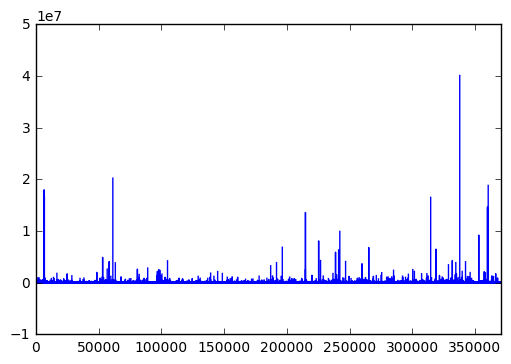

In [106]:
test_data01_a_worker_per_user['AVERAGE_RCVBL_AMT'].plot.line()

### 3-14 8表 违约时间   RCVED_YM(实收日期) - RCVBL_YM(RCVBL_YM)

#### 3-13-1 训练集

In [17]:
train_data08_df[train_data08_df['CONS_NO']=='6010564379']

,ORG_NO,CONS_NO,RCVED_YM,RCVED_DATE,THIS_RCVED_AMT,THIS_PENALTY,OWE_AMT,RCVBL_YM,RCVBL_PENALTY,EXCEEDING_RCVBL_YM
414952,334010102,6010564379,201510,20151021,5.98,0.0,5.98,201504,0.0,6
414953,334010102,6010564379,201510,20151021,7.98,0.0,7.98,201502,0.0,8
1384722,33401011021,6010564379,201510,20151021,4.85,1.0,4.85,201509,0.1,1
1507535,33401011021,6010564379,201511,20151126,18.23,0.0,18.23,201511,0.0,0
1579476,33401011021,6010564379,201512,20151210,149.19,0.0,149.19,201512,0.0,0


##### 超出 应收时间的月数  EXCEEDING_RCVBL_YM

In [6]:
train_data08_df['EXCEEDING_RCVBL_YM'] = train_data08_df['RCVED_YM']-train_data08_df['RCVBL_YM']

In [24]:
%%time
# 统计是否有 违约1个月以上
train_data08_cons_no_exceeding_rcvbl_ge1_series = \
    train_data08_df.groupby('CONS_NO')['EXCEEDING_RCVBL_YM'].apply(lambda x : int(sum(x>1)>0))

CPU times: user 53.3 s, sys: 208 ms, total: 53.5 s
Wall time: 53.3 s


In [25]:
train_data08_cons_no_exceeding_rcvbl_ge1_series.head()

CONS_NO
0002471802    0
0002471815    0
0002476706    1
0002506278    0
0002557351    0
Name: EXCEEDING_RCVBL_YM, dtype: int64

In [ ]:
train_data01_

In [22]:
train_data08_df[train_data08_df['EXCEEDING_RCVBL_YM']>2].head()

,ORG_NO,CONS_NO,RCVED_YM,RCVED_DATE,THIS_RCVED_AMT,THIS_PENALTY,OWE_AMT,RCVBL_YM,RCVBL_PENALTY,EXCEEDING_RCVBL_YM
833,3340101,1321042853,201510,20151016,-315203.64,-49171.77,315203.64,201507,-49171.77,3
834,3340101,1321042853,201510,20151016,-510247.01,-67352.61,510247.01,201507,-67352.61,3
835,3340101,1321042853,201510,20151016,315203.64,55475.84,315203.64,201507,55475.84,3
836,3340101,1321042853,201510,20151016,285868.50,43452.02,510247.01,201507,43452.01,3
837,3340101,1321042853,201510,20151006,315203.64,49171.77,315203.64,201507,49171.77,3


##### 是否违约超过一个月 ----添加到 train_data01_a_worker_per_user中

In [26]:
# 是否违约超过一个月
train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data08_cons_no_exceeding_rcvbl_ge1_series)


In [17]:
# 连接不上的用户 设置为2
train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'] = \
    train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'].fillna(2)

In [29]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON']>0].iloc[0]

APP_NO                                        2015101280034874
ID                                            1000000527323992
BUSI_TYPE_CODE                                               3
URBAN_RURAL_FLAG                                             1
ORG_NO                                                   33401
HANDLE_TIME                                 2015/10/12 9:25:31
ACCEPT_CONTENT                               【查询电费】客户查询电费，已告知。
HANDLE_OPINION                                             NaN
CALLING_NO                                         1.71473e+06
ELEC_TYPE                                                  202
CUST_NO                                             6010564379
PROV_ORG_NO                                              33101
CITY_ORG_NO                                              33401
TAG                                                          0
NUM_OF_WORKER                                                1
ACCEPT_CONTENT_TYPE                                    

(2,)


0    9155
1    4112
Name: TAG, dtype: int64

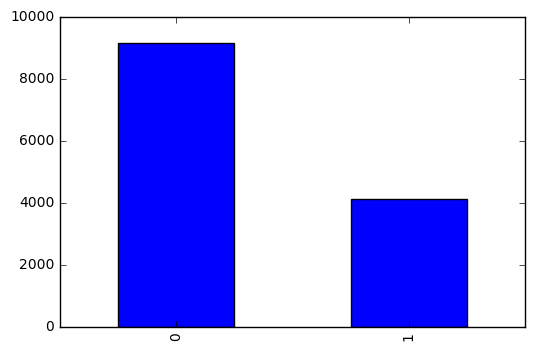

In [20]:
show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON']>0],
    'TAG'
)

#### 3-13-1 测试集

##### 超出 应收时间的月数  EXCEEDING_RCVBL_YM

In [31]:
test_data08_df['EXCEEDING_RCVBL_YM'] = test_data08_df['RCVED_YM']-test_data08_df['RCVBL_YM']

In [32]:
%%time
# 统计是否有 违约1个月以上
test_data08_cons_no_exceeding_rcvbl_ge1_series = \
    test_data08_df.groupby('CONS_NO')['EXCEEDING_RCVBL_YM'].apply(lambda x : int(sum(x>1)>0))

CPU times: user 54.1 s, sys: 284 ms, total: 54.4 s
Wall time: 54.2 s


In [33]:
test_data08_cons_no_exceeding_rcvbl_ge1_series.head()

CONS_NO
0002460938    0
0002506210    0
0002581691    0
0002581910    0
0002582157    0
Name: EXCEEDING_RCVBL_YM, dtype: int64

In [34]:
test_data08_df[test_data08_df['EXCEEDING_RCVBL_YM']>2].head()

,CONS_NO,ORG_NO,RCVED_YM,RCVED_DATE,THIS_RCVED_AMT,THIS_PENALTY,OWE_AMT,RCVBL_YM,RCVBL_PENALTY,EXCEEDING_RCVBL_YM
22958,6023006132,334010101,201504,20150401,37.02,2.18,37.02,201501,2.18,3
22989,6023181182,334010101,201504,20150402,76.93,4.62,76.93,201501,4.62,3
23057,6023116123,334010101,201504,20150401,186.14,10.98,186.14,201501,10.98,3
23066,6023132626,334010101,201504,20150401,68.29,4.03,68.29,201501,4.03,3
23110,6011056875,334010101,201504,20150401,76.62,4.52,76.62,201501,4.52,3


##### 是否违约超过一个月 ----添加到 train_data01_a_worker_per_user中

In [35]:
# 是否违约超过一个月
test_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data08_cons_no_exceeding_rcvbl_ge1_series)


In [18]:
# 连接不上的用户 设置为2
test_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'] = \
    test_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON'].fillna(2)

In [38]:
test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_EXCEEDING_RCVBL_YM_GE_1MON']>0].shape

(6081, 47)

### 3-14 本次实收电费 THIS_RCVED_AMT     

#### 3-13-1 训练集

In [12]:
train_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN,NaN,0
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN,NaN,0
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN,NaN,0
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN,NaN,0
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN,NaN,0


In [130]:
%%time
train_data08_merge_label_this_reved_amt_sum_df = \
    train_data08_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['THIS_RCVED_AMT'].sum()

CPU times: user 2.84 s, sys: 748 ms, total: 3.58 s
Wall time: 4.58 s


In [130]:
%%time
train_data08_merge_label_this_reved_amt_sum_df = \
    train_data08_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['THIS_PENALTY'].sum()

CPU times: user 2.84 s, sys: 748 ms, total: 3.58 s
Wall time: 4.58 s


In [125]:
%%time
train_data09_merge_label_reved_amt_sum_df = \
    train_data09_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['RCVED_AMT'].sum()

CPU times: user 5.29 s, sys: 2.43 s, total: 7.72 s
Wall time: 10.6 s


In [125]:
%%time
train_data09_merge_label_reved_amt_sum_df = \
    train_data09_merge_label_df.groupby(by=['CONS_NO','RCVBL_YM'],as_index=False)['RCVED_PENALTY'].sum()

CPU times: user 5.29 s, sys: 2.43 s, total: 7.72 s
Wall time: 10.6 s


In [131]:
print train_data08_merge_label_this_reved_amt_sum_df.head()
print train_data09_merge_label_reved_amt_sum_df.head()

      CONS_NO  RCVBL_YM  THIS_RCVED_AMT
0  1081380222    201502          201.75
1  1100506263    201505           16.50
2  1100506385    201501           55.10
3  1100507494    201509           19.92
4  1100508075    201503           60.79
      CONS_NO  RCVBL_YM   RCVED_AMT
0  1000101001    201501  5301415.41
1  1000101001    201502  4372080.02
2  1000101001    201503  4829490.74
3  1000101001    201504  5375305.81
4  1000101001    201505  5294991.89


In [ ]:
train_data08_reved_amt_sum_df = pd.DataFrame(train_data08_merge_label_this_reved_amt_sum_df)
train_data09_reved_amt_sum_df = pd.DataFrame(train_data09_merge_label_reved_amt_sum_df)
print train_data08_reved_amt_sum_df.head()
print train_data09_reved_amt_sum_df.head()
# print train_data08_reved_amt_sum_df[u'1100565675']
save_data(
    train_data08_reved_amt_sum_df.merge(
        train_data09_merge_label_reved_amt_sum_df,
        how='outer',
        on=['CONS_NO','RCVBL_YM']),
    'temp.csv',
)

      CONS_NO  RCVBL_YM  THIS_RCVED_AMT
0  1081380222    201502          201.75
1  1100506263    201505           16.50
2  1100506385    201501           55.10
3  1100507494    201509           19.92
4  1100508075    201503           60.79
      CONS_NO  RCVBL_YM   RCVED_AMT
0  1000101001    201501  5301415.41
1  1000101001    201502  4372080.02
2  1000101001    201503  4829490.74
3  1000101001    201504  5375305.81
4  1000101001    201505  5294991.89


In [37]:
train_data09_merge_label_reved_amt_sum_df.head()

CONS_NO
1000101001    66434070.00
1000104008         143.10
1000108003      995971.48
1000108017     4749925.38
1000108020     5873519.25
Name: RCVED_AMT, dtype: float64

In [27]:
train_data08_merge_label_this_reved_amt_sum_df.head()

CONS_NO
1081380222    201.75
1100506263     16.50
1100506385     55.10
1100507494     19.92
1100508075     60.79
Name: THIS_RCVED_AMT, dtype: float64

In [39]:
train_data09_merge_label_reved_amt_sum_df.shape,train_data08_merge_label_this_reved_amt_sum_df.shape

((555748,), (282152,))

In [25]:
%%time
train_data08_merge_label_this_penalty_sum_df = \
    train_data08_merge_label_df.groupby(by='CONS_NO')['THIS_PENALTY'].sum()

CPU times: user 1.42 s, sys: 180 ms, total: 1.6 s
Wall time: 1.6 s


In [26]:
train_data08_merge_label_this_penalty_sum_df.head()

CONS_NO
1081380222    1.0
1100506263    0.0
1100506385    0.0
1100507494    0.0
1100508075    0.0
Name: THIS_PENALTY, dtype: float64

### 3-15 表1用户能否连接上09表

#### 3-13-1 训练集

In [5]:
%%time
temp = train_data01_a_worker_per_user.merge(
    train_data09_cust_no_tag_df,
    how='left',
    left_on='CUST_NO', 
    right_on='CONS_NO'
)
# 全部先设置 为 0
temp['IS_CONNECT_TO_09TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_09TABLE']=0


CPU times: user 1.14 s, sys: 160 ms, total: 1.3 s
Wall time: 1.3 s


In [8]:
# 修改
train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE'] = temp['IS_CONNECT_TO_09TABLE']

In [28]:
sum(temp['CONS_NO'].isnull()) == 102626,sum(train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==0) == 102626

NameError: name 'temp' is not defined

> <ipython-input-28-cd28c9f1fd8a>(1)<module>()
----> 1 sum(temp['CONS_NO'].isnull()) == 102626,sum(train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==0) == 102626

ipdb> q


#### 3-13-2 测试集

In [14]:
%%time
temp = test_data01_a_worker_per_user.merge(
    test_data09_cust_no_df,
    how='left',
    left_on='CUST_NO', 
    right_on='CONS_NO'
)

# 全部先设置 为 0
temp['IS_CONNECT_TO_09TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_09TABLE']=0


CPU times: user 620 ms, sys: 156 ms, total: 776 ms
Wall time: 777 ms


In [15]:
# 修改
test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE'] = temp['IS_CONNECT_TO_09TABLE']

In [18]:
sum(test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==0) ==169169

True

### 3-15 表1用户能否连接上08表

#### 3-13-1 训练集

In [33]:
%%time
temp = train_data01_a_worker_per_user.merge(
    train_data08_cust_no_tag_df,
    how='left',
    left_on='CUST_NO', 
    right_on='CONS_NO'
)
# 全部先设置 为 0
temp['IS_CONNECT_TO_08TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_08TABLE']=0


CPU times: user 968 ms, sys: 296 ms, total: 1.26 s
Wall time: 1.36 s


In [36]:
# 修改
train_data01_a_worker_per_user['IS_CONNECT_TO_08TABLE'] = temp['IS_CONNECT_TO_08TABLE']

In [38]:
sum(temp['CONS_NO'].isnull()) == 376222,sum(train_data01_a_worker_per_user['IS_CONNECT_TO_08TABLE']==0) == 376222

(True, True)

#### 3-13-2 测试集

In [39]:
%%time
temp = test_data01_a_worker_per_user.merge(
    test_data08_cust_no_df,
    how='left',
    left_on='CUST_NO', 
    right_on='CONS_NO'
)

# 全部先设置 为 0
temp['IS_CONNECT_TO_08TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_08TABLE']=0


CPU times: user 740 ms, sys: 16 ms, total: 756 ms
Wall time: 757 ms


In [43]:
# 修改
test_data01_a_worker_per_user['IS_CONNECT_TO_08TABLE'] = temp['IS_CONNECT_TO_08TABLE']

In [44]:
# 59649
sum(test_data01_a_worker_per_user['IS_CONNECT_TO_08TABLE']==0) 

59649

### 3-15 09表 应收违约金 RCVBL_PENALTY 的次数

#### 3-13-1 训练集

In [19]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='0002476706']

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG,ORG_NO_7bit
524654,0002476706,201501,33401010428,10101.0,0,0.00,0.00,1,0.00,0.00,NaN,0.00,2.0,405.0,NaN,NaN,0,3340101
536370,0002476706,201502,33401010428,10101.0,0,0.00,0.00,1,0.00,0.00,NaN,0.00,2.0,405.0,NaN,NaN,0,3340101
571758,0002476706,201503,33401010428,10101.0,0,0.00,0.00,1,0.00,0.00,NaN,0.00,2.0,405.0,NaN,NaN,0,3340101
632733,0002476706,201504,33401010428,10101.0,86,81.36,81.36,1,0.00,0.00,NaN,81.36,2.0,405.0,NaN,NaN,0,3340101
644199,0002476706,201505,33401010428,10101.0,88,82.92,82.92,1,0.00,0.00,NaN,82.92,2.0,405.0,NaN,NaN,0,3340101
679047,0002476706,201506,33401010428,10101.0,46,43.13,43.13,1,1.38,1.38,NaN,43.13,2.0,405.0,NaN,NaN,0,3340101
1149332,0002476706,201507,33401011025,10101.0,31,29.07,29.07,1,0.00,0.00,NaN,29.07,2.0,405.0,NaN,NaN,0,3340101


In [14]:
%%time
def count_num_of_rcvbl_amt(x):
    ym_set=set()
    for item in x.values:
        if item[0]>0:
            if not ym_set.__contains__(item[1]):
                ym_set.add(item[1])
    
#     print len(ym_set)


    return pd.Series(len(ym_set))

# 计算应收违约金 RCVBL_PENALTY 的次数
train_data09_rcvbl_amt_count_series = \
    train_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_PENALTY','RCVBL_YM'].apply(count_num_of_rcvbl_amt)

CPU times: user 1min 34s, sys: 808 ms, total: 1min 35s
Wall time: 1min 35s


In [36]:
train_data09_rcvbl_amt_count_dict = {i:j[0] for i,j in zip(train_data09_rcvbl_amt_count_series.index,train_data09_rcvbl_amt_count_series.values)}

In [37]:
train_data09_rcvbl_amt_count_dict['0002476706']

1

In [43]:
train_data01_a_worker_per_user['NUM_OF_RCVBL_PENALTY'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_rcvbl_amt_count_dict)

(13, 5)


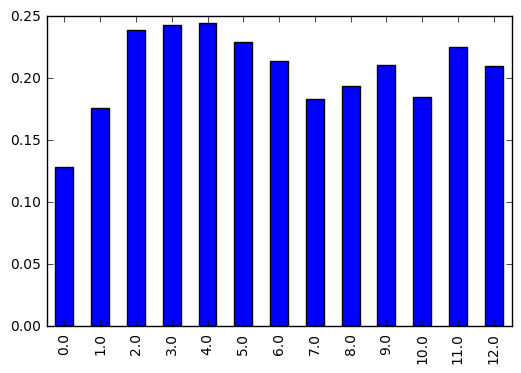

In [44]:
train_data01_a_worker_per_user_num_of_rcvbl_count_df = show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'NUM_OF_RCVBL_PENALTY',
    split_by_tag=True, tag_name='TAG'
).sort_values(by='tag1/total',ascending=False)

#### 3-13-1 测试集

In [45]:
%%time
def count_num_of_rcvbl_amt(x):
    ym_set=set()
    for item in x.values:
        if item[0]>0:
            if not ym_set.__contains__(item[1]):
                ym_set.add(item[1])
    
#     print len(ym_set)


    return pd.Series(len(ym_set))

# 计算应收违约金 RCVBL_PENALTY 的次数
test_data09_rcvbl_amt_count_series = \
    test_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_PENALTY','RCVBL_YM'].apply(count_num_of_rcvbl_amt)
    
test_rcvbl_amt_count_series = test_data09_merge_label_df.groupby(by='CONS_NO')['RCVBL_AMT'].apply(lambda x : sum([item>0 for item in x]))

CPU times: user 48.4 s, sys: 480 ms, total: 48.9 s
Wall time: 48.8 s
CPU times: user 48.4 s, sys: 484 ms, total: 48.9 s
Wall time: 48.8 s


In [46]:
test_data09_rcvbl_amt_count_dict = {i:j[0] for i,j in zip(test_data09_rcvbl_amt_count_series.index,test_data09_rcvbl_amt_count_series.values)}

##### 添加到 test_data01_a_worker_per_user中

In [51]:
test_data01_a_worker_per_user['NUM_OF_RCVBL_PENALTY'] = test_data01_a_worker_per_user['CUST_NO'].map(test_data09_rcvbl_amt_count_dict)

(13,)


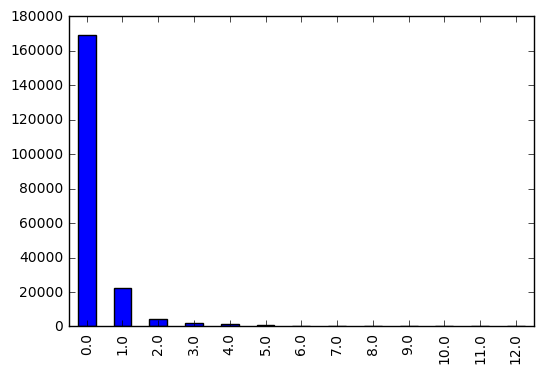

In [48]:
test_data01_a_worker_per_user_num_of_rcvbl_count_df = show_attribute_detail(
    test_data01_a_worker_per_user[test_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'NUM_OF_RCVBL_PENALTY',
)

In [43]:
test_data01_a_worker_per_user['NUM_OF_RCVBL_PENALTY'] = temp['NUM_OF_RCVBL_PENALTY']

##### 3-12-1-3 合并结果

In [49]:
temp = train_data01_a_worker_per_user_num_of_rcvbl_count_df.join(
    test_data01_a_worker_per_user_num_of_rcvbl_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['NUM_OF_RCVBL_PENALTY']
temp = temp.drop(labels = [u'NUM_OF_RCVBL_PENALTY'],axis=1)
print '代表工单 -应收违约金 RCVBL_PENALTY 的次数'
print temp
# 数据太多了，输出分析
save_data(
    temp,
    'train&test_data01_a_worker_per_user_num_of_rcvbl_count_df.csv',
    index=True
)

代表工单 -应收违约金 RCVBL_PENALTY 的次数
       total   tag1  tag1/total    tag0  tag0/total  test_total
4.0     4775   1168    0.244607    3607    0.755393        1151
3.0     9806   2382    0.242913    7424    0.757087        2088
2.0    22187   5313    0.239465   16874    0.760535        4506
5.0     2429    558    0.229724    1871    0.770276         750
11.0     408     92    0.225490     316    0.774510         143
6.0     1381    296    0.214337    1085    0.785663         471
9.0      479    101    0.210856     378    0.789144         213
12.0     295     62    0.210169     233    0.789831         119
8.0      731    142    0.194254     589    0.805746         303
10.0     416     77    0.185096     339    0.814904         207
7.0      922    169    0.183297     753    0.816703         382
1.0    78203  13749    0.175812   64454    0.824188       22049
0.0   433716  55916    0.128923  377800    0.871077      169320


### 3-15 06表 低保户信息表 06_CONT_INFO  部分特征

#### 2-1-1 训练集

##### 2-1-1-1  加载数据 train/06_cont_info.tsv

In [30]:
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data06_df = load_data(file_name = 'Data_Update/train/06_cont_info.tsv',
                                 converters={0:unicode}
# 7386                             )
print(train_data06_df.shape)
# 2455
print '用户数：%d'%len(train_data06_df['CONS_NO'].unique())

(7386, 4)
用户数：2455


##### 增加特征 - 是否连接上表6

In [62]:
temp = train_data01_a_worker_per_user.merge(
    train_data06_df[['CONS_NO','CONT_TYPE']].drop_duplicates(),
    how='left', left_on='CUST_NO', right_on='CONS_NO', 
)
# 全部先设置 为 1
temp['IS_CONNECT_TO_06TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_06TABLE']=0
print sum(temp['CONS_NO'].notnull()),sum(temp['IS_CONNECT_TO_06TABLE']==1)
print temp.head(),temp.shape

2455 2455
             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280016722  1000000527203612               3               2.0   
1  2015101280031388  1000000527304861               3               1.0   
2  2015101280031424  1000000527305097               3               2.0   
3  2015101280031680  1000000527300870               3               2.0   
4  2015101280032506  1000000527305664               3               1.0   

      ORG_NO         HANDLE_TIME                ACCEPT_CONTENT HANDLE_OPINION  \
0    3341020  2015/10/12 7:31:50              【银行代扣】客户咨询银行代扣事宜            NaN   
1    3340901  2015/10/12 9:14:03  【咨询总户号】通过地址（户名、表号）查询户号信息，已告知            NaN   
2      33401  2015/10/12 9:14:16             【查询电费】客户查询电费，已告知。            NaN   
3  334020106  2015/10/12 9:11:37        【咨询总户号】通过地址（户名）查询户号信息。            NaN   
4    3340101  2015/10/12 9:14:48  【咨询总户号】通过地址（户名、表号）查询户号信息，已告知            NaN   

   CALLING_NO  ELEC_TYPE          ...           IS_C

In [20]:
train_data01_a_worker_per_user = train_data01_a_worker_per_user.drop('STATUS',axis=1)

In [64]:
train_data01_a_worker_per_user['IS_CONNECT_TO_06TABLE'] = temp['IS_CONNECT_TO_06TABLE']

In [65]:
sum(train_data01_a_worker_per_user['IS_CONNECT_TO_06TABLE']==1)

2455

In [66]:
train_data01_a_worker_per_user['CONT_TYPE'] = temp['CONT_TYPE']

In [23]:
# 暂时不要，因为现在
# train_data01_a_worker_per_user['STATUS'] = temp['STATUS']

In [67]:
temp = train_data06_df.groupby('CONS_NO')['STATUS'].apply(lambda x: len(set(x)))
temp[temp>1]

CONS_NO
6010276428    2
6120032054    2
7910363317    2
8602022550    2
Name: STATUS, dtype: int64

In [21]:
train_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,IS_CONNECT_TO_08TABLE,NUM_OF_RCVBL_PENALTY,IS_CONNECT_TO_07TABLE,CONS_STATUS,RCA_FLAG,ORG_NO_7bit,AVERAGE_RCVBL_AMT,IS_EXCEEDING_RCVBL_YM_GE_1MON,IS_CONNECT_TO_06TABLE,CONT_TYPE
0,2015101280016722,1000000527203612,3,2.0,3341020,2015/10/12 7:31:50,【银行代扣】客户咨询银行代扣事宜,NaN,1196922.0,202.0,...,0,NaN,0,NaN,NaN,NaN,NaN,2.0,0,NaN
1,2015101280031388,1000000527304861,3,1.0,3340901,2015/10/12 9:14:03,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1005636.0,NaN,...,0,NaN,0,NaN,NaN,NaN,NaN,2.0,0,NaN
2,2015101280031424,1000000527305097,3,2.0,33401,2015/10/12 9:14:16,【查询电费】客户查询电费，已告知。,NaN,1007513.0,405.0,...,1,0.0,0,NaN,NaN,3340101.0,1652.304167,0.0,0,NaN
3,2015101280031680,1000000527300870,3,2.0,334020106,2015/10/12 9:11:37,【咨询总户号】通过地址（户名）查询户号信息。,NaN,1073266.0,202.0,...,1,0.0,0,NaN,NaN,3340201.0,51.961667,0.0,0,NaN
4,2015101280032506,1000000527305664,3,1.0,3340101,2015/10/12 9:14:48,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1433592.0,NaN,...,1,0.0,0,NaN,NaN,3340150.0,121.936250,0.0,0,NaN


#### 2-1-1 测试集

##### 2-1-1-1  加载数据 test/06_cont_info_test.tsv

In [4]:
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
test_data06_df = load_data(file_name = 'Data_Update/test/06_cont_info_test.tsv',
                                 converters={0:unicode}
                                )
print(test_data06_df.shape)
print '用户数：%d'%len(test_data06_df['CONS_NO'].unique())

(1505, 4)
用户数：1505


##### 增加特征 - 是否连接上表6

In [16]:
test_data01_a_worker_per_user = test_data01_a_worker_per_user.drop('STATUS',axis=1)

In [13]:
temp = test_data01_a_worker_per_user.merge(
    test_data06_df[['CONS_NO','CONT_TYPE']].drop_duplicates(),
    how='left', left_on='CUST_NO', right_on='CONS_NO', 
)
# 全部先设置 为 0
temp['IS_CONNECT_TO_06TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_06TABLE']=0
print sum(temp['CONS_NO'].notnull())
print temp.head(),temp.shape

1505
             APP_NO                ID  BUSI_TYPE_CODE  URBAN_RURAL_FLAG  \
0  2015101280019632  1000000527215943               3               1.0   
1  2015101280019648  1000000527216033              10               2.0   
2  2015101280019680  1000000527216202               3               2.0   
3  2015101280019873  1000000527218491               3               1.0   
4  2015101280020130  1000000527221199               1               1.0   

      ORG_NO         HANDLE_TIME  \
0    3340780  2015/10/12 7:58:04   
1  334066001  2015/10/12 7:58:26   
2    3340690  2015/10/12 7:58:52   
3    3340810  2015/10/12 8:02:53   
4    3340501  2015/10/12 8:07:10   

                                      ACCEPT_CONTENT HANDLE_OPINION  \
0   【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。            NaN   
1  【退订】#2061584501；【退订】#2061584602；【退订】#406091928...            NaN   
2                                【查询电费】客户查询本月电费，已告知。            NaN   
3                           【咨询总户号】通过地址、户名查

In [17]:
test_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,IS_CONNECT_TO_08TABLE,NUM_OF_RCVBL_PENALTY,IS_CONNECT_TO_07TABLE,CONS_STATUS,RCA_FLAG,ORG_NO_7bit,AVERAGE_RCVBL_AMT,IS_EXCEEDING_RCVBL_YM_GE_1MON,IS_CONNECT_TO_06TABLE,CONT_TYPE
0,2015101280019632,1000000527215943,3,1.0,3340780,2015/10/12 7:58:04,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1628699.0,202.0,...,1,0.0,0,NaN,NaN,3340780.0,68.573333,0.0,0,NaN
1,2015101280019648,1000000527216033,10,2.0,334066001,2015/10/12 7:58:26,【退订】#2061584501；【退订】#2061584602；【退订】#406091928...,NaN,1260775.0,201.0,...,1,0.0,0,NaN,NaN,3340660.0,34.745833,0.0,0,NaN
2,2015101280019680,1000000527216202,3,2.0,3340690,2015/10/12 7:58:52,【查询电费】客户查询本月电费，已告知。,NaN,1536321.0,201.0,...,1,0.0,0,NaN,NaN,3340690.0,207.431667,0.0,0,NaN
3,2015101280019873,1000000527218491,3,1.0,3340810,2015/10/12 8:02:53,【咨询总户号】通过地址、户名查询户号信息，已告知,NaN,1576698.0,NaN,...,1,0.0,0,NaN,NaN,3340801.0,20.694444,0.0,0,NaN
4,2015101280020130,1000000527221199,1,1.0,3340501,2015/10/12 8:07:10,【设备故障】客户报修此处线路打火，请处理。客户只能提供此地址，烦请电话联系057486581...,NaN,1089990.0,201.0,...,0,NaN,0,NaN,NaN,NaN,NaN,2.0,0,NaN


In [14]:
test_data01_a_worker_per_user['IS_CONNECT_TO_06TABLE'] = temp['IS_CONNECT_TO_06TABLE']

In [15]:
test_data01_a_worker_per_user['CONT_TYPE'] = temp['CONT_TYPE']

In [42]:
test_data01_a_worker_per_user['STATUS'] = temp['STATUS']

### 3-15 07表 费控用户信息表 07_C_RCA_CONS 部分特征

#### 2-1-1 训练集

##### 2-1-1-1  加载数据 train/07_c_rca_cons.tsv

In [18]:
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data07_df = load_data(file_name = 'Data_Update/train/07_c_rca_cons.tsv',
                                 converters={0:unicode}
                                )
print(train_data07_df.shape)

(22192, 4)


In [24]:
temp = train_data01_a_worker_per_user.merge(
    train_data07_df,
    how='left', left_on='CUST_NO', right_on='CONS_NO', 
)
# 全部先设置 为 0
temp['IS_CONNECT_TO_07TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_07TABLE']=0
print sum(temp['CONS_NO'].notnull())
print temp.head()

In [35]:
train_data07_df.head()

,CONS_NO,ORG_NO,RCA_FLAG,CONS_STATUS
0,1316020607,3340101,0,NaN
1,1316023683,3340101,0,NaN
2,1316032110,3340101,0,NaN
3,1316078898,3340101,0,NaN
4,1316090581,3340101,0,NaN


In [37]:
train_data01_a_worker_per_user['IS_CONNECT_TO_07TABLE'] = temp['IS_CONNECT_TO_07TABLE']

In [38]:
train_data01_a_worker_per_user['CONS_STATUS'] = temp['CONS_STATUS']

In [26]:
train_data01_a_worker_per_user['RCA_FLAG'] = temp['RCA_FLAG']

#### 2-1-1 测试集

##### 2-1-1-1  加载数据 test/07_c_rca_cons_test.tsv

In [29]:
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
test_data07_df = load_data(file_name = 'Data_Update/test/07_c_rca_cons_test.tsv',
                                 converters={0:unicode}
                                )
print(test_data07_df.shape)

(10954, 4)


In [43]:
temp = test_data01_a_worker_per_user.merge(
    test_data07_df,
    how='left', left_on='CUST_NO', right_on='CONS_NO', 
)
# 全部先设置 为 0
temp['IS_CONNECT_TO_07TABLE'] = 1
temp.loc[temp['CONS_NO'].isnull(),'IS_CONNECT_TO_07TABLE']=0
print sum(temp['CONS_NO'].notnull())
print temp.head()

In [46]:
test_data01_a_worker_per_user['IS_CONNECT_TO_07TABLE'] = temp['IS_CONNECT_TO_07TABLE']

In [38]:
test_data01_a_worker_per_user['CONS_STATUS'] = temp['CONS_STATUS']

In [44]:
test_data01_a_worker_per_user['RCA_FLAG'] = temp['RCA_FLAG']

### 3-15 04表 用电客户信息表 04_c_cons

#### 2-1-1 训练集

##### 2-1-1-1  加载数据 train/04_c_cons.tsv

In [2]:
%%time
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data04_df = load_data(file_name = 'Data_Update/train/04_c_cons.tsv',
                                 converters={'CONS_ID':unicode,'CONS_NO':unicode}
                                )
# 记录数 1968846
print(train_data04_df.shape)
# 用户数 656282
print(len(train_data04_df['CONS_ID'].unique()))

/usr/local/lib/python2.7/dist-packages/IPython/core/magic.py:188: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


(1968846, 12)
656282
CPU times: user 8.01 s, sys: 700 ms, total: 8.71 s
Wall time: 8.93 s


##### 2-4-1-2 将数据连接上标签 

In [3]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data04_merge_label_df = train_data04_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_NO',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data04_merge_label_df['TAG'] = train_data04_merge_label_df['TAG'].fillna(0)
train_data04_merge_label_df['TAG'] = train_data04_merge_label_df['TAG'].astype(int)

NameError: name 'train_data_labels_df' is not defined

> <timed exec>(3)<module>()

ipdb> q


In [90]:
# 两个一一对应
train_data04_merge_label_df[['CONS_NO','CONS_ID']].drop_duplicates().shape

(656282, 2)

###### 输出 训练集中 CONS_NO','CONS_ID'

In [ ]:
train_data04_cust_no_cons_id_tag_df = \
    train_data04_merge_label_df[['CONS_NO','CONS_ID','TAG']].drop_duplicates().sort_values(by='TAG')
save_data(
    train_data04_cust_no_cons_id_tag_df,
    'train_data04_cust_no_cons_id_tag_df.csv'
)
train_data04_cust_no_cons_id_tag_df.shape

###### 从文件中恢复

In [5]:
# CONS_NO 全部转为字符串，否则在连接表的时候会出问题
train_data01_cust_no_tag_df = load_data('train_data01_cust_no_tag_df.csv',
                                        encoding='utf8',
                                        converters={'CUST_NO':unicode}
                                       )

In [ ]:
sa

In [8]:
show_df_info(train_data04_merge_label_df)

       CONS_ID     CONS_NO                     ELEC_ADDR TRADE_CODE  \
0  17747484982  6023090135   浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****       9910   
1  17747484987  6023090140   浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****       9910   
2  17747484992  6023090145   浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****       9910   
3  17694250067  6023084488  浙江省杭州市江干区九堡镇杨公社区江岸邻里小区8幢****       9910   
4  17851227583  6023107736   浙江省杭州市江干区彭埠镇建华社区建华家苑2幢3****       9910   

   ELEC_TYPE_CODE  CONTRACT_CAP  LODE_ATTR_CODE  HEC_INDUSTRY_CODE  \
0             202           8.0             3.0                NaN   
1             202           8.0             3.0                NaN   
2             202           8.0             3.0                NaN   
3             202           8.0             3.0                NaN   
4             202           8.0             3.0                NaN   

   STATUS_CODE       ORG_NO  CONS_SORT_CODE  URBAN_RURAL_FLAG CUST_NO  TAG  
0            0  33401010141               3               1.0     NaN    0 

In [9]:
train_data04_merge_label_df.head()

,CONS_ID,CONS_NO,ELEC_ADDR,TRADE_CODE,ELEC_TYPE_CODE,CONTRACT_CAP,LODE_ATTR_CODE,HEC_INDUSTRY_CODE,STATUS_CODE,ORG_NO,CONS_SORT_CODE,URBAN_RURAL_FLAG,CUST_NO,TAG
0,17747484982,6023090135,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
1,17747484987,6023090140,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
2,17747484992,6023090145,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
3,17694250067,6023084488,浙江省杭州市江干区九堡镇杨公社区江岸邻里小区8幢****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
4,17851227583,6023107736,浙江省杭州市江干区彭埠镇建华社区建华家苑2幢3****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0


###### 统计 敏感和 不敏感 分布情况

(2,)


0    1728771
1     240075
Name: TAG, dtype: int64

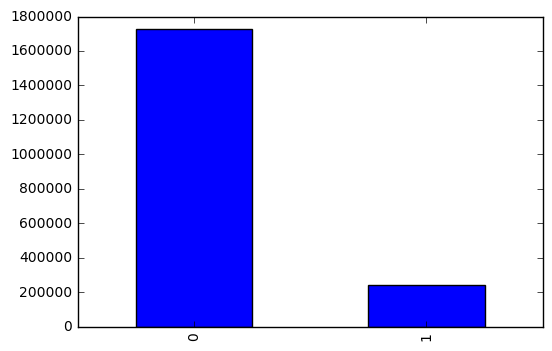

In [29]:
# 所有记录
show_attribute_detail(
    train_data04_merge_label_df,
    'TAG'
)

(2,)


0    576257
1     80025
Name: TAG, dtype: int64

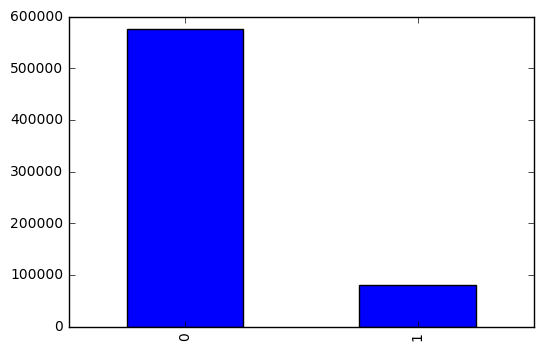

In [30]:
show_attribute_detail(
    train_data04_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    'TAG'
)

##### 和data01数据的用户列表比较

In [32]:
train_data01_data04_cust_no_tag_df = train_data01_a_worker_per_user.merge(
    train_data04_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 合并所有用户有：658374   ----  跟表1一样，即 表4中所有用户都在表1中
# 在data01数据中，而不在data08数据中的用户数有：0
# 在data08数据中，而不在data01数据中的用户数有：376222
print '合并所有用户有：%d'%train_data01_data04_cust_no_tag_df.shape[0]
print '在data04数据中，而不在data01数据中的用户数有：%d'%sum(train_data01_data04_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data04数据中的用户数有：%d'%sum(train_data01_data04_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：658374
在data04数据中，而不在data01数据中的用户数有：0
在data01数据中，而不在data04数据中的用户数有：2092


In [35]:
train_data04_merge_label_df.head()

,CONS_ID,CONS_NO,ELEC_ADDR,TRADE_CODE,ELEC_TYPE_CODE,CONTRACT_CAP,LODE_ATTR_CODE,HEC_INDUSTRY_CODE,STATUS_CODE,ORG_NO,CONS_SORT_CODE,URBAN_RURAL_FLAG,CUST_NO,TAG
0,17747484982,6023090135,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
1,17747484987,6023090140,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,6023090140,1
2,17747484992,6023090145,浙江省杭州市江干区九堡镇兴安社区九洲芳园2幢2****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
3,17694250067,6023084488,浙江省杭州市江干区九堡镇杨公社区江岸邻里小区8幢****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0
4,17851227583,6023107736,浙江省杭州市江干区彭埠镇建华社区建华家苑2幢3****,9910,202,8.0,3.0,NaN,0,33401010141,3,1.0,NaN,0


In [61]:
train_data04_merge_label_df['LODE_ATTR_CODE'].unique()

array([  3.,   2.,   1.,  nan])

In [62]:
train_data04_merge_label_df[['ORG_NO','LODE_ATTR_CODE']].drop_duplicates()

,ORG_NO,LODE_ATTR_CODE
0,33401010141,3.0
48,33401010129,3.0
51,33401010140,3.0
320,33401010141,2.0
592,33401010141,1.0
702,33401010140,NaN
1049,33401010140,2.0
1309,33401010128,NaN
1336,33401010129,NaN
2006,33401010130,NaN


In [66]:
show_attribute_detail(
    train_data04_merge_label_df,
    'LODE_ATTR_CODE',
    True,
    'URBAN_RURAL_FLAG'
)

TypeError: %d format: a number is required, not numpy.float64

> /home/jdwang/PycharmProjects/customerPortrait/semi-finals/data_util_func.py(166)show_attribute_detail()
    164         for tag_value in data[tag_name].unique():
    165             tag1 = data.loc[data[tag_name] == tag_value, attribute_name].value_counts().sort_index()
--> 166             temp['tag%d' % tag_value] = tag1
    167             temp['tag%d/total' % tag_value] = tag1 / total
    168             # print(tag_value)

ipdb> q


### 3-15 11表 运行电能信息表 11_C_METER

#### 2-1-1 训练集

##### 2-1-1-1  加载数据 train/11_c_meter.tsv

In [83]:
%%time
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data11_df = load_data(file_name = 'Data_Update/train/11_c_meter.tsv',
                                 converters={'CONS_ID':unicode}
                                )
# 记录数 25,807,825
print(train_data11_df.shape)
# 用户数 25,622,658
print(len(train_data11_df['CONS_ID'].unique()))

/usr/local/lib/python2.7/dist-packages/IPython/core/magic.py:188: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


(25807825, 6)
25622658
CPU times: user 50 s, sys: 4.45 s, total: 54.5 s
Wall time: 1min 17s


In [87]:
len(train_data04_merge_label_df['CONS_ID'].unique())

656282

##### 2-4-1-2 将数据连接上标签 

In [ ]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data11_merge_data04_df = train_data11_df.merge(
    train_data04_merge_label_df,
    how='left',
    left_on='CONS_ID',
    right_on='CONS_ID'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data11_merge_label_df['TAG'] = train_data11_merge_label_df['TAG'].fillna(0)
train_data11_merge_label_df['TAG'] = train_data11_merge_label_df['TAG'].astype(int)

In [84]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data11_merge_label_df = train_data11_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_ID',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data11_merge_label_df['TAG'] = train_data11_merge_label_df['TAG'].fillna(0)
train_data11_merge_label_df['TAG'] = train_data11_merge_label_df['TAG'].astype(int)

CPU times: user 19.6 s, sys: 4.31 s, total: 23.9 s
Wall time: 39.4 s


In [21]:
show_df_info(train_data11_merge_label_df)

     METER_ID     ORG_NO MEAS_BOX  SORT_CODE  TYPE_CODE      CONS_ID CUST_NO  \
0  3002822017  3340101.0      NaN          3       2418  12332601047     NaN   
1  3002821792  3340101.0      NaN          3       2418  12332601015     NaN   
2  3002741739  3340101.0      NaN          3       2418  12332601009     NaN   
3  3002741786  3340101.0      NaN          3       2418  12332601009     NaN   
4  2993895722    33401.0      NaN          3       2418  16531875042     NaN   

   TAG  
0    0  
1    0  
2    0  
3    0  
4    0  


MemoryError: 

> /usr/local/lib/python2.7/dist-packages/numpy/core/shape_base.py(230)vstack()
    228 
    229     """
--> 230     return _nx.concatenate([atleast_2d(_m) for _m in tup], 0)
    231 
    232 def hstack(tup):

ipdb> q


In [22]:
train_data11_merge_label_df.head()

,METER_ID,ORG_NO,MEAS_BOX,SORT_CODE,TYPE_CODE,CONS_ID,CUST_NO,TAG
0,3002822017,3340101.0,NaN,3,2418,12332601047,NaN,0
1,3002821792,3340101.0,NaN,3,2418,12332601015,NaN,0
2,3002741739,3340101.0,NaN,3,2418,12332601009,NaN,0
3,3002741786,3340101.0,NaN,3,2418,12332601009,NaN,0
4,2993895722,33401.0,NaN,3,2418,16531875042,NaN,0


In [15]:
len(train_data11_df['TYPE_CODE'].unique())

55

In [29]:
sum(train_data11_df['CONS_ID']=='12332601047')

84

In [25]:
train_data01_a_worker_per_user['CUST_NO'].head()

0    5720017228
1    7618031763
2    6010466106
3    1658156188
4    3168134368
Name: CUST_NO, dtype: object

In [16]:
train_data11_df['TYPE_CODE'].unique()

array([2418,   86, 2439, 2438, 2433,   85,   84, 2410, 2414,   24, 2429,
       2211,   83, 2412, 2101, 2431, 2417, 2425, 2405, 2415, 2426, 2413,
       1601,   21, 2437, 2210, 2401, 1301, 2202, 2201, 2420, 1101, 2451,
       2436, 2452, 2416, 2445, 2430,   87,   88, 2411, 2432, 2404, 2406,
       2428, 2424, 2103, 2440, 2421, 2434, 2419, 2409,   28, 2402, 2435])

In [ ]:
train_data11_df

(1,)


0    25807825
Name: TAG, dtype: int64

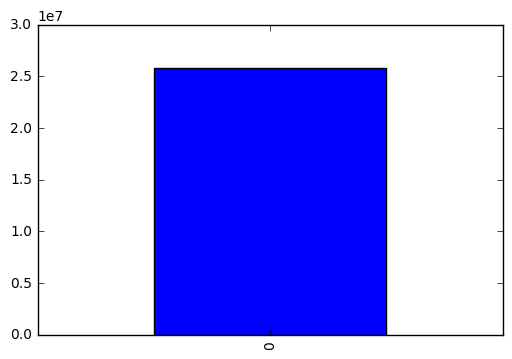

In [23]:
show_attribute_detail(
    train_data11_merge_label_df,
    'TAG',
)

### 3-16 12表 收费记录 12_A_PAY_FLOW

#### 2-1-1 训练集

##### 2-1-1-1  加载数据 train/11_c_meter.tsv

In [68]:
%%time
# 要特别注意 统一设置 converters={0:unicode}，
# 避免后面连接错误
train_data12_df = load_data(file_name = 'Data_Update/train/12_a_pay_flow.tsv',
                                 converters={'CONS_NO':unicode}
                                )
# 记录数 5483788
print(train_data12_df.shape)
# 用户数 431833
print(len(train_data12_df['CONS_NO'].unique()))

(5483788, 5)
431833
CPU times: user 10.4 s, sys: 704 ms, total: 11.1 s
Wall time: 12.6 s


##### 2-4-1-2 将数据连接上标签 

In [69]:
%%time
# 连接上的用户都是敏感的 ，置为1，有 542,218 个 data08记录， 45,659个用户
train_data12_merge_label_df = train_data12_df.merge(
    train_data_labels_df,
    how='left',
    left_on='CONS_NO',
    right_on='CUST_NO'
)
# 将没有连接上的工单设置为不敏感用户，  2,707,524 个 data08记录,236,493个用户
train_data12_merge_label_df['TAG'] = train_data12_merge_label_df['TAG'].fillna(0)
train_data12_merge_label_df['TAG'] = train_data12_merge_label_df['TAG'].astype(int)

CPU times: user 2.78 s, sys: 192 ms, total: 2.98 s
Wall time: 3.74 s


###### 统计 敏感和 不敏感 分布情况

(2,)


0    4624437
1     859351
Name: TAG, dtype: int64

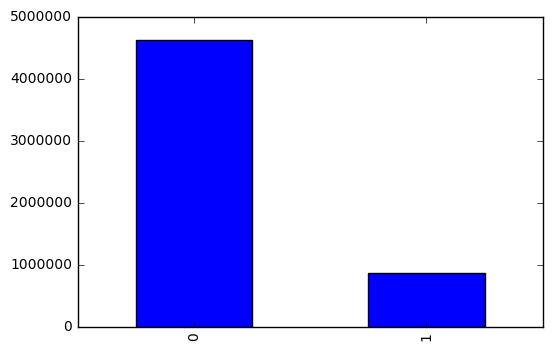

In [70]:
# 所有记录
show_attribute_detail(
    train_data12_merge_label_df,
    'TAG'
)

(2,)


0    366218
1     65615
Name: TAG, dtype: int64

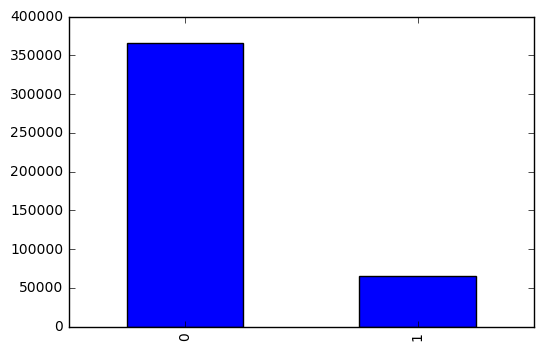

In [76]:
show_attribute_detail(
    train_data12_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    'TAG'
)

##### 和data01数据的用户列表比较

In [77]:
train_data01_data12_cust_no_tag_df = train_data01_a_worker_per_user.merge(
    train_data12_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 合并所有用户有：658374   ----  跟表1一样，即 表4中所有用户都在表1中
# 在data01数据中，而不在data08数据中的用户数有：0
# 在data08数据中，而不在data01数据中的用户数有：376222
print '合并所有用户有：%d'%train_data01_data12_cust_no_tag_df.shape[0]
print '在data12数据中，而不在data01数据中的用户数有：%d'%sum(train_data01_data12_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data12数据中的用户数有：%d'%sum(train_data01_data12_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：658374
在data12数据中，而不在data01数据中的用户数有：0
在data01数据中，而不在data12数据中的用户数有：226541


In [75]:
sum(train_data01_data12_cust_no_tag_df['CONS_NO'].isnull())

226541

In [81]:
train_data12_merge_label_df['PAY_MODE'].unique()

array([20271, 10101, 20311, 20108, 20101, 30201, 10301, 10601, 10106,
       20331, 20261])

(11, 5)


,total,tag0,tag0/total,tag1,tag1/total
10101,576918,472523,0.819047,104395,0.180953
10106,790,709,0.897468,81,0.102532
10301,14386,12645,0.878980,1741,0.121020
10601,432,355,0.821759,77,0.178241
20101,1359442,1107996,0.815037,251446,0.184963
20108,882857,717343,0.812525,165514,0.187475
20261,80979,65429,0.807975,15550,0.192025
20271,80243,61995,0.772591,18248,0.227409
20311,2033207,1796470,0.883565,236737,0.116435
20331,290576,254387,0.875458,36189,0.124542


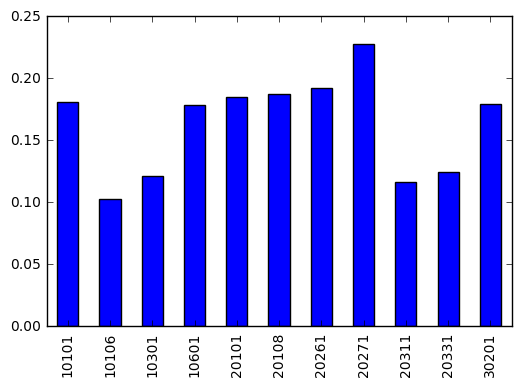

In [82]:
show_attribute_detail(
    train_data12_merge_label_df,
    'PAY_MODE',
    True,
    'TAG'
)

#### 测试集

In [79]:
test_data01_data12_cust_no_tag_df = test_data01_a_worker_per_user.merge(
    train_data12_merge_label_df[['CONS_NO','TAG']].drop_duplicates(),
    how='outer',
    left_on='CUST_NO',
    right_on='CONS_NO'
)
# 无测试集用户
print '合并所有用户有：%d'%test_data01_data12_cust_no_tag_df.shape[0]
print '在data12数据中，而不在data01数据中的用户数有：%d'%sum(test_data01_data12_cust_no_tag_df['CUST_NO'].isnull())
print '在data01数据中，而不在data12数据中的用户数有：%d'%sum(test_data01_data12_cust_no_tag_df['CONS_NO'].isnull())


合并所有用户有：802704
在data12数据中，而不在data01数据中的用户数有：431833
在data01数据中，而不在data12数据中的用户数有：370871


### 3-17 09表 缴费方式的研究

In [11]:
train_data09_merge_label_df.head()

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG
0,6010969031,201502,33401010130,10101.0,1869,1768.07,1768.07,1,0.00,0.00,NaN,1768.07,2.0,403.0,NaN,NaN,0
1,6010811670,201502,33401010130,10101.0,2791,2640.29,2640.29,1,0.00,0.00,NaN,2640.29,2.0,403.0,NaN,NaN,0
2,6010777305,201502,33401010130,20311.0,1883,1058.25,1058.25,1,2.12,2.12,NaN,1058.25,3.0,202.0,NaN,NaN,0
3,6010777296,201502,33401010130,20311.0,4279,3585.80,3585.80,1,0.00,0.00,NaN,3585.80,3.0,201.0,NaN,NaN,0
4,6010777190,201502,33401010130,20311.0,2514,1561.93,1561.93,1,0.00,0.00,NaN,1561.93,3.0,202.0,NaN,NaN,0


##### 统计缴费方式在所有记录下的分布情况

所有工单 - 缴费方式 PAY_MODE
(10, 5)


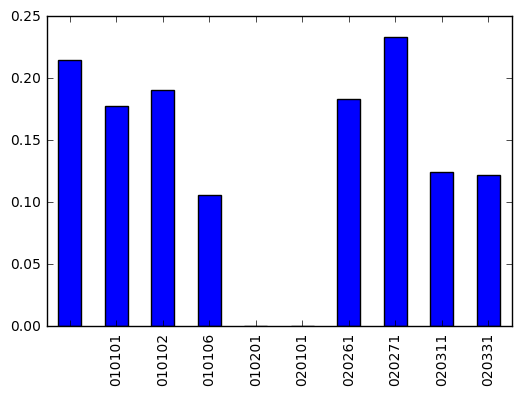

In [28]:
print '所有工单 - 缴费方式 PAY_MODE'
train_data09_pay_mode_count_df = show_attribute_detail(
    train_data09_merge_label_df,
    'PAY_MODE',
    True,
    'TAG'
)

所有工单 - 缴费方式 PAY_MODE
(8,)


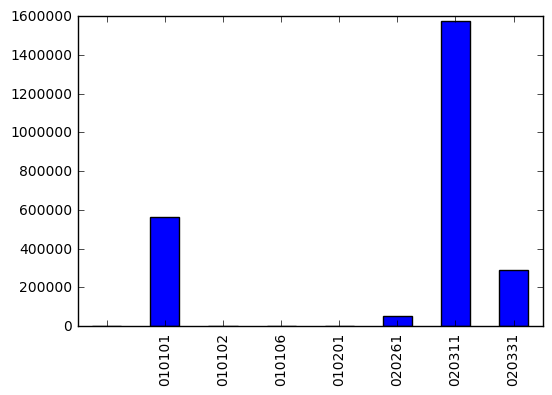

In [30]:
print '所有工单 - 缴费方式 PAY_MODE'
test_data09_pay_mode_count_df = show_attribute_detail(
    test_data09_merge_label_df,
    'PAY_MODE',
)

In [32]:
# 合并
temp = train_data09_pay_mode_count_df.join(
    test_data09_pay_mode_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['PAY_MODE']
temp = temp.drop(labels = [u'PAY_MODE'],axis=1)
print '所有记录 - 缴费方式 PAY_MODE'
print temp

代表工单 - 缴费方式 PAY_MODE
          total     tag0  tag0/total      tag1  tag1/total  test_total
020271    85040    65234    0.767098   19806.0    0.232902         0.0
             28       22    0.785714       6.0    0.214286         1.0
010102       63       51    0.809524      12.0    0.190476        18.0
020261   109152    89146    0.816714   20006.0    0.183286     50297.0
010101  2193015  1804004    0.822614  389011.0    0.177386    561957.0
020311  3540736  3099758    0.875456  440978.0    0.124544   1576987.0
020331   536279   470879    0.878049   65400.0    0.121951    289140.0
010106     2323     2077    0.894102     246.0    0.105898      1057.0
010201        5        5    1.000000       0.0    0.000000        12.0
020101       13       13    1.000000       0.0    0.000000         0.0


#### 用户使用过的支付方式的种类 NUM_OF_USED_PAY_MODE

In [12]:
# 比用户数多，说明有部分用户 是 有多种类型的 支付方式 
train_data09_merge_label_df[['CONS_NO','PAY_MODE','TAG']].drop_duplicates().shape

(610133, 3)

##### 训练集

In [10]:
%%time
train_data09_pay_mode_count_series = train_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x:len(set([item for item in x if len(x)!=0]))
)

CPU times: user 39.4 s, sys: 148 ms, total: 39.5 s
Wall time: 39.4 s


In [27]:
%%time
# 增加字段，使用过的 支付方式 样式
train_data01_a_worker_per_user['NUM_OF_USED_PAY_MODE'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_count_series)
print sum(train_data01_a_worker_per_user['NUM_OF_USED_PAY_MODE'].isnull())

102626
CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.32 s


(3, 5)


,total,tag0,tag0/total,tag1,tag1/total
1.0,501868,429320,0.855444,72548,0.144556
2.0,53375,45955,0.860984,7420,0.139016
3.0,505,448,0.887129,57,0.112871


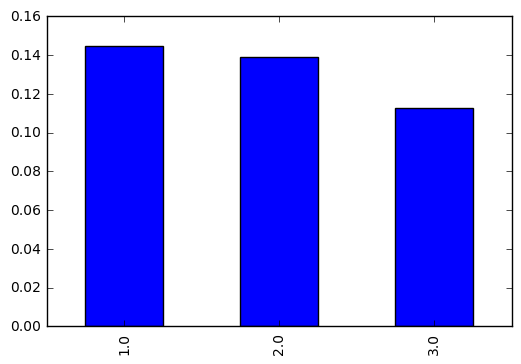

In [28]:
# 分布比较均匀，暂时发现不出价值
show_attribute_detail(
    train_data01_a_worker_per_user,
    'NUM_OF_USED_PAY_MODE',
    True,
    'TAG',
)


##### 测试集

In [33]:
%%time
test_data09_pay_mode_count_series = test_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x:len(set([item for item in x if len(x)!=0]))
)

CPU times: user 15.2 s, sys: 732 ms, total: 15.9 s
Wall time: 17.3 s


In [17]:
sum(train_data09_pay_mode_count_series<2)

501868

In [34]:
%%time
# 增加字段，使用过的 支付方式 样式
test_data01_a_worker_per_user['NUM_OF_USED_PAY_MODE'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_count_series)
print sum(test_data01_a_worker_per_user['NUM_OF_USED_PAY_MODE'].isnull())

169169
CPU times: user 1.25 s, sys: 52 ms, total: 1.3 s
Wall time: 1.44 s


(3,)


1.0    185047
2.0     16511
3.0       144
Name: NUM_OF_USED_PAY_MODE, dtype: int64

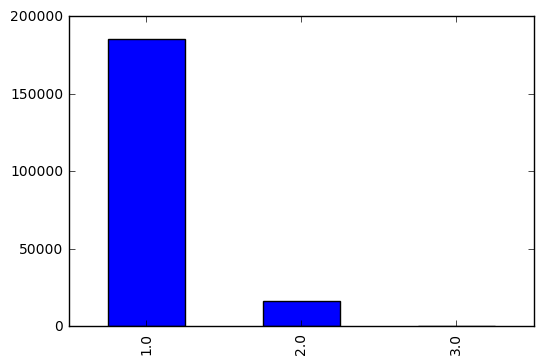

In [35]:
show_attribute_detail(
    test_data01_a_worker_per_user,
    'NUM_OF_USED_PAY_MODE',
)


#### 用户是否含有该 支付方式 010102等

In [49]:
# 支付方式列表 010101（）
# 0101-坐收    0101 01、0101 06、
train_data09_merge_label_df['PAY_MODE'].unique()

array([u'010101', u'020311', u'020271', u'020331', u'', u'010106',
       u'010102', u'020261', u'010201', u'020101'], dtype=object)

In [36]:
test_data09_merge_label_df[test_data09_merge_label_df['PAY_MODE']=='010201']

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO
331566,1701860262,201501,334030101,010201,243,104.98,104.98,1,0.0,0.0,NaN,104.98,3.0,202.0,NaN,1701860262
338714,1701860262,201502,334030101,010201,185,86.60,86.60,1,0.0,0.0,NaN,86.60,3.0,202.0,NaN,1701860262
340812,1701860262,201503,334030101,010201,135,61.28,61.28,1,0.0,0.0,NaN,61.28,3.0,202.0,NaN,1701860262
363434,1701860262,201504,334030101,010201,96,40.25,40.25,1,0.0,0.0,NaN,40.25,3.0,202.0,NaN,1701860262
364788,1701860262,201505,334030101,010201,76,31.13,31.13,1,0.0,0.0,NaN,31.13,3.0,202.0,NaN,1701860262
383436,1701860262,201506,334030101,010201,75,30.56,30.56,1,0.0,0.0,NaN,30.56,3.0,202.0,NaN,1701860262
387178,1701860262,201507,334030101,010201,119,51.63,51.63,1,0.0,0.0,NaN,51.63,3.0,202.0,NaN,1701860262
394362,1701860262,201508,334030101,010201,219,96.39,96.39,1,0.0,0.0,NaN,96.39,3.0,202.0,NaN,1701860262
405341,1701860262,201509,334030101,010201,238,105.78,105.78,1,0.0,0.0,NaN,105.78,3.0,202.0,NaN,1701860262
419114,1701860262,201510,334030101,010201,86,36.25,36.25,1,0.0,0.0,NaN,36.25,3.0,202.0,NaN,1701860262


(2,)


0    89146
1    20006
Name: TAG, dtype: int64

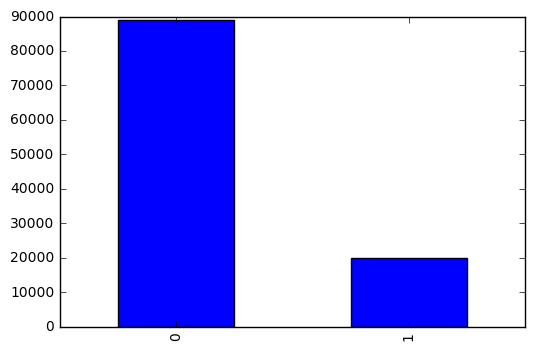

In [38]:
show_attribute_detail(
    train_data09_merge_label_df[train_data09_merge_label_df['PAY_MODE']=='020261'],
    'TAG'
)

#### 增加字段，是否包含支付方式 - 020311（代扣）

In [29]:
%%time
train_data09_pay_mode_contain020311_series = train_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('020311'))>0)
)

CPU times: user 2min 37s, sys: 696 ms, total: 2min 37s
Wall time: 2min 38s


In [39]:
%%time
# 增加字段，是否包含支付方式 - 020311
train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020311'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_contain020311_series)
print sum(train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020311'].isnull())

102626
CPU times: user 1.72 s, sys: 32 ms, total: 1.75 s
Wall time: 1.95 s


In [15]:
%%time
test_data09_pay_mode_contain020311_series = test_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('020311'))>0)
)

CPU times: user 45.6 s, sys: 196 ms, total: 45.8 s
Wall time: 45.8 s


In [40]:
%%time
# 增加字段，是否包含支付方式 - 020311
test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020311'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_contain020311_series)
print sum(test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020311'].isnull())

169169
CPU times: user 868 ms, sys: 292 ms, total: 1.16 s
Wall time: 3.25 s


(2, 5)


,total,tag0,tag0/total,tag1,tag1/total
0.0,228439,188896,0.826899,39543,0.173101
1.0,327309,286827,0.876319,40482,0.123681


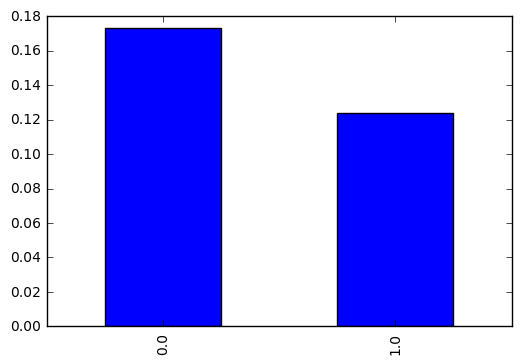

In [43]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'IS_PAY_MODE_CONTAINS_020311',
    True,
    'TAG'
)

#### 增加字段，是否包含支付方式 - 010101(坐收)

In [44]:
%%time
train_data09_pay_mode_contain010101_series = train_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('010101'))>0)
)

CPU times: user 2min 19s, sys: 716 ms, total: 2min 20s
Wall time: 2min 20s


In [45]:
%%time
# 增加字段，是否包含支付方式 - 010101
train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_010101'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_contain010101_series)
print sum(train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_010101'].isnull())

102626
CPU times: user 1.43 s, sys: 52 ms, total: 1.48 s
Wall time: 1.71 s


In [47]:
%%time
test_data09_pay_mode_contain010101_series = test_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('010101'))>0)
)

CPU times: user 53.7 s, sys: 296 ms, total: 54 s
Wall time: 55.4 s


In [48]:
%%time
# 增加字段，是否包含支付方式 - 010101
test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_010101'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_contain010101_series)
print sum(test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_010101'].isnull())

169169
CPU times: user 932 ms, sys: 4 ms, total: 936 ms
Wall time: 932 ms


(2, 5)


,total,tag0,tag0/total,tag1,tag1/total
0.0,327204,287051,0.877285,40153,0.122715
1.0,228544,188672,0.825539,39872,0.174461


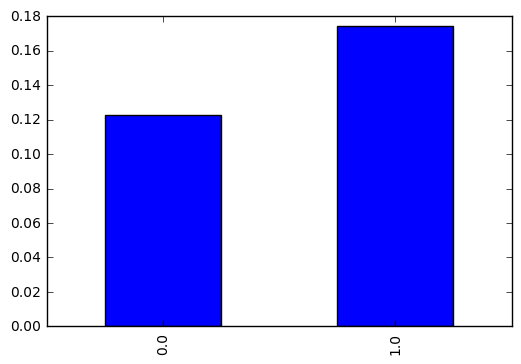

In [49]:
show_attribute_detail(
    train_data01_a_worker_per_user,
    'IS_PAY_MODE_CONTAINS_010101',
    True,
    'TAG'
)

#### 增加字段，是否包含支付方式 - 020261(委托特约)

In [50]:
%%time
train_data09_pay_mode_contain020261_series = train_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('020261'))>0)
)

CPU times: user 2min 21s, sys: 652 ms, total: 2min 22s
Wall time: 2min 21s


In [51]:
%%time
# 增加字段，是否包含支付方式 - 020261
train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020261'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_contain020261_series)
print sum(train_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020261'].isnull())

102626
CPU times: user 1.96 s, sys: 12 ms, total: 1.98 s
Wall time: 2.12 s


In [52]:
%%time
test_data09_pay_mode_contain020261_series = test_data09_merge_label_df.groupby('CONS_NO')['PAY_MODE'].apply(
    lambda x : int(sum(x.str.contains('020261'))>0)
)

CPU times: user 46.2 s, sys: 96 ms, total: 46.3 s
Wall time: 46.2 s


In [53]:
%%time
# 增加字段，是否包含支付方式 - 020261
test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020261'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_contain020261_series)
print sum(test_data01_a_worker_per_user['IS_PAY_MODE_CONTAINS_020261'].isnull())

169169
CPU times: user 944 ms, sys: 16 ms, total: 960 ms
Wall time: 1.01 s


(2, 5)
      total    tag0  tag0/total   tag1  tag1/total
0.0  549737  470790    0.856391  78947    0.143609
1.0    6011    4933    0.820662   1078    0.179338


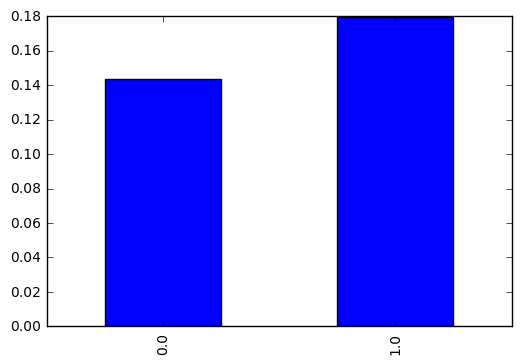

In [55]:
print show_attribute_detail(
    train_data01_a_worker_per_user,
    'IS_PAY_MODE_CONTAINS_020261',
    True,
    'TAG'
)

(2,)
0.0    198837
1.0      2865
Name: IS_PAY_MODE_CONTAINS_020261, dtype: int64


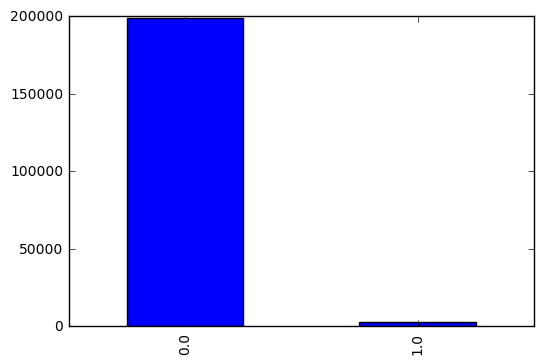

In [56]:
print show_attribute_detail(
    test_data01_a_worker_per_user,
    'IS_PAY_MODE_CONTAINS_020261',
)

#### 最后一个月的支付方式

##### 训练集

In [29]:
%%time
# 获取最后一个月 的缴费方式
def get_last_month_pay_mode(x):
    last_month_pay_mode = x.sort_values(by='RCVBL_YM')['PAY_MODE'].iloc[-1]
    return last_month_pay_mode

train_data09_last_month_pay_mode_series = \
    train_data09_merge_label_df.groupby('CONS_NO').apply(get_last_month_pay_mode)

CPU times: user 4min 57s, sys: 3.52 s, total: 5min
Wall time: 5min 15s


In [32]:
%%time
# 增加字段，最后一个月 的缴费方式
train_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_last_month_pay_mode_series)
print sum(train_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'].isnull())

102626
CPU times: user 1.92 s, sys: 16 ms, total: 1.94 s
Wall time: 2.07 s


##### 测试集

In [30]:
%%time
# 获取最后一个月 的缴费方式
def get_last_month_pay_mode(x):
    last_month_pay_mode = x.sort_values(by='RCVBL_YM')['PAY_MODE'].iloc[-1]
    return last_month_pay_mode

test_data09_last_month_pay_mode_series = \
    test_data09_merge_label_df.groupby('CONS_NO').apply(get_last_month_pay_mode)

CPU times: user 1min 58s, sys: 1.68 s, total: 1min 59s
Wall time: 2min 5s


In [34]:
%%time
# 增加字段，最后一个月 的缴费方式
test_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_last_month_pay_mode_series)
print sum(test_data01_a_worker_per_user['LAST_MONTH_PAY_MODE'].isnull())

169169
CPU times: user 964 ms, sys: 0 ns, total: 964 ms
Wall time: 963 ms


##### 统计结果

(9, 5)


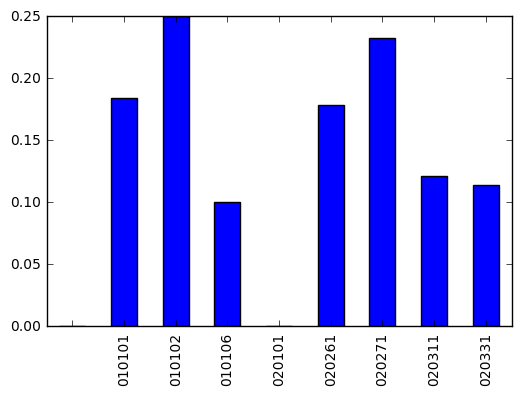

In [35]:
train_data09_last_month_pay_mode_count_df =  show_attribute_detail(
    train_data01_a_worker_per_user,
    'LAST_MONTH_PAY_MODE',
    True,
    'TAG'
)

(7,)


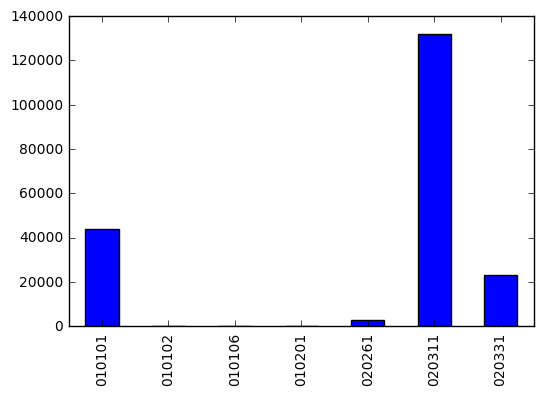

In [36]:
test_data09_last_month_pay_mode_count_df = show_attribute_detail(
    test_data01_a_worker_per_user,
    'LAST_MONTH_PAY_MODE',
)

In [38]:
# 合并
temp = train_data09_last_month_pay_mode_count_df.join(
    test_data09_last_month_pay_mode_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['LAST_MONTH_PAY_MODE']
temp = temp.drop(labels = [u'LAST_MONTH_PAY_MODE'],axis=1)
print '所有用户 - 最后一个缴费方式 PAY_MODE'
print temp

所有用户 - 最后一个缴费方式 PAY_MODE
           total      tag0  tag0/total     tag1  tag1/total  test_total
010102       4.0       3.0    0.750000      1.0    0.250000         1.0
020271    4857.0    3728.0    0.767552   1129.0    0.232448         0.0
010101  191966.0  156643.0    0.815993  35323.0    0.184007     43949.0
020261    5471.0    4493.0    0.821239    978.0    0.178761      2627.0
020311  312338.0  274416.0    0.878587  37922.0    0.121413    131989.0
020331   40960.0   36303.0    0.886304   4657.0    0.113696     23066.0
010106     150.0     135.0    0.900000     15.0    0.100000        69.0
             1.0       1.0    1.000000      0.0    0.000000         0.0
010201       0.0       0.0    0.000000      0.0    0.000000         1.0
020101       1.0       1.0    1.000000      0.0    0.000000         0.0


#### 支付方式的转变

In [54]:
%%time
# 缴费方式的变化线索
def get_pay_mode_change_clue(x):
    pay_mode_change_clue = '-'.join(x.sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values)
    return pay_mode_change_clue
    
train_data09_pay_mode_change_clue_series = \
    train_data09_merge_label_df.groupby('CONS_NO').apply(get_pay_mode_change_clue)

CPU times: user 11min 10s, sys: 4.64 s, total: 11min 15s
Wall time: 11min 32s


In [55]:
%%time
# 缴费方式的变化线索
def get_pay_mode_change_clue(x):
    pay_mode_change_clue = '-'.join(x.sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values)
    return pay_mode_change_clue
    
test_data09_pay_mode_change_clue_series = \
    test_data09_merge_label_df.groupby('CONS_NO').apply(get_pay_mode_change_clue)

CPU times: user 4min 31s, sys: 1.34 s, total: 4min 32s
Wall time: 4min 39s


In [56]:
train_data09_pay_mode_change_clue_series

CONS_NO
0002471802           020311
0002471815           020311
0002476706           010101
0002506278           020331
0002507444           020311
0002557351           020331
0002576549    010101-020331
0002581705    010101-020311
0002581851           010101
0002581877           020311
0002581949           010101
0002582056           020311
0002582098           010101
0002582160           010101
0002582199           010101
0002582232           010101
0002582258           020311
0002582261    020311-010101
0002582320           020311
0002582564           010101
0002583134           010101
0002583235           010101
0002583264           020311
0002583277           010101
0002583323           010101
0002583394           020311
0002583482    010101-020311
0002583538           010101
0002583541    010101-020311
0002583554           010101
                  ...      
9920038175           010101
9920038177    010101-020311
9920038179           010101
9920038180           010101
9920038210  

In [57]:
%%time
# 增加字段，缴费方式的转变路径
train_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_change_clue_series)
print sum(train_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'].isnull())

102626
CPU times: user 1.97 s, sys: 132 ms, total: 2.1 s
Wall time: 3.42 s


In [58]:
%%time
# 增加字段，缴费方式的转变路径
test_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_pay_mode_change_clue_series)
print sum(test_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'].isnull())

169169
CPU times: user 1.02 s, sys: 60 ms, total: 1.08 s
Wall time: 1.52 s


##### 统计结果

(57, 5)


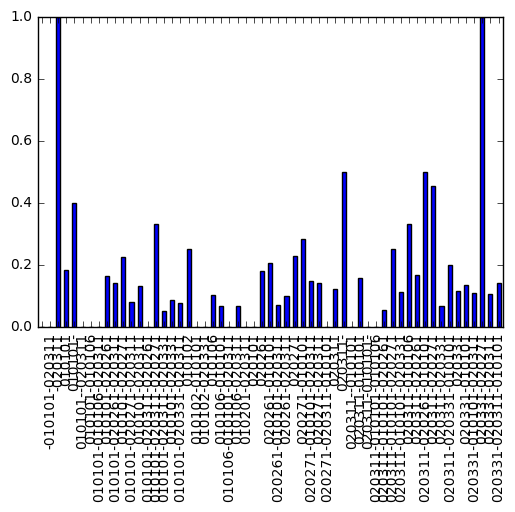

In [59]:
train_data09_pay_mode_change_clue_count_df =  show_attribute_detail(
    train_data01_a_worker_per_user,
    'PAY_MODE_CHANGE_CLUE',
    True,
    'TAG'
)

(35,)


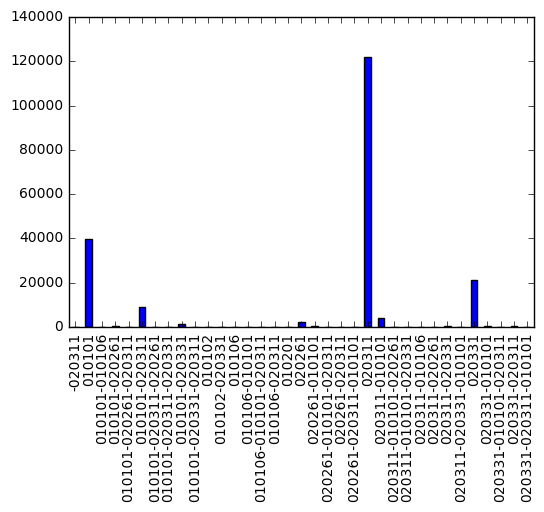

In [60]:
test_data09_pay_mode_change_clue_count_df = show_attribute_detail(
    test_data01_a_worker_per_user,
    'PAY_MODE_CHANGE_CLUE',
)

In [62]:
# 合并
temp = train_data09_pay_mode_change_clue_count_df.join(
    test_data09_pay_mode_change_clue_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['PAY_MODE_CHANGE_CLUE']
temp = temp.drop(labels = [u'PAY_MODE_CHANGE_CLUE'],axis=1)
print '所有用户 - 缴费方式的转变线索 PAY_MODE_CHANGE_CLUE'
print temp
# 数据太多了，输出分析
save_data(
    temp,
    'train&test_data09_pay_mode_change_clue_count_df.csv',
    index=True
)

所有用户 - 缴费方式的转变线索 PAY_MODE_CHANGE_CLUE
                         total      tag0  tag0/total     tag1  tag1/total  \
-020311                    1.0       0.0    0.000000      1.0    1.000000   
020331-020271              1.0       0.0    0.000000      1.0    1.000000   
020311-                    2.0       1.0    0.500000      1.0    0.500000   
020311-020261-010101       4.0       2.0    0.500000      2.0    0.500000   
020311-020271             11.0       6.0    0.545455      5.0    0.454545   
010101-                    5.0       3.0    0.600000      2.0    0.400000   
010101-020311-020271       3.0       2.0    0.666667      1.0    0.333333   
020311-010106              3.0       2.0    0.666667      1.0    0.333333   
020271-010101            344.0     246.0    0.715116     98.0    0.284884   
020311-010101-020271       4.0       3.0    0.750000      1.0    0.250000   
010102                     4.0       3.0    0.750000      1.0    0.250000   
020271                  4304.0    3322

#### 支付方式（只取前4位）的转变

In [83]:
train_data01_a_worker_per_user[train_data01_a_worker_per_user['CUST_NO']=='1040110018']

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,IS_EXCEEDING_RCVBL_YM_GE_1MON,IS_CONNECT_TO_06TABLE,CONT_TYPE,MAX_NUM_MONTH_SEARCH_ACTION,NUM_OF_USED_PAY_MODE,IS_PAY_MODE_CONTAINS_020311,IS_PAY_MODE_CONTAINS_010101,IS_PAY_MODE_CONTAINS_020261,LAST_MONTH_PAY_MODE,PAY_MODE_CHANGE_CLUE
1242,2015100579171054,1000000521504770,1,2.0,3340550,2015/10/5 16:28:38,【一户无电】客户报修非居民一户停电，经指导客户检查，怀疑为供电资产表计故障，请现场查处。,NaN,1663649.0,100.0,...,2.0,0,NaN,0.0,2.0,0.0,1.0,1.0,010101,020261-010101


In [80]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='1040110018'].sort_values(by='RCVBL_YM')

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG
4873219,1040110018,201501,33405500104,020261,68130,119463.81,119463.81,1,0.0,0.0,NaN,119463.81,1.0,100.0,NaN,NaN,0
4893440,1040110018,201501,33405500104,020261,188760,155473.62,155473.62,1,0.0,0.0,NaN,155473.62,1.0,100.0,NaN,NaN,0
4899361,1040110018,201502,33405500104,020261,195090,160847.61,160847.61,1,0.0,0.0,NaN,160847.61,1.0,100.0,NaN,NaN,0
4919622,1040110018,201502,33405500104,020261,29610,86705.42,86705.42,1,0.0,0.0,NaN,86705.42,1.0,100.0,NaN,NaN,0
4918066,1040110018,201503,33405500104,020261,69600,120061.37,120061.37,1,0.0,0.0,NaN,120061.37,1.0,100.0,NaN,NaN,0
4918090,1040110018,201503,33405500104,020261,101670,81885.45,81885.45,1,0.0,0.0,NaN,81885.45,1.0,100.0,NaN,NaN,0
4942934,1040110018,201504,33405500104,020261,185310,150941.49,150941.49,1,0.0,0.0,NaN,150941.49,1.0,100.0,NaN,NaN,0
4929016,1040110018,201504,33405500104,020261,66600,114788.35,114788.35,1,0.0,0.0,NaN,114788.35,1.0,100.0,NaN,NaN,0
4932230,1040110018,201505,33405500104,020261,49770,101603.44,101603.44,1,0.0,0.0,NaN,101603.44,1.0,100.0,NaN,NaN,0
4929088,1040110018,201505,33405500104,020261,145920,111806.65,111806.65,1,0.0,0.0,NaN,111806.65,1.0,100.0,NaN,NaN,0


In [98]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='3260016270'].sort_values(by='RCVBL_YM')

,CONS_NO,RCVBL_YM,ORG_NO,PAY_MODE,T_PQ,RCVBL_AMT,RCVED_AMT,STATUS_CODE,RCVBL_PENALTY,RCVED_PENALTY,RISK_LEVEL_CODE,OWE_AMT,CONS_SORT_CODE,ELEC_TYPE_CODE,CTL_MODE,CUST_NO,TAG
2585461,3260016270,201501,334024001,020311,734,828.72,828.72,1,0.0,0.0,NaN,828.72,1.0,403.0,NaN,NaN,0
2585463,3260016270,201501,334024001,020311,4825,4715.81,4715.81,1,0.0,0.0,NaN,4715.81,1.0,403.0,NaN,NaN,0
2599619,3260016270,201501,334024001,020311,2404,2344.94,2344.94,1,0.0,0.0,NaN,2344.94,1.0,403.0,NaN,NaN,0
2626849,3260016270,201502,334024001,020311,6279,6134.40,6134.40,1,0.0,0.0,NaN,6134.40,1.0,403.0,NaN,NaN,0
2622064,3260016270,201502,334024001,020311,2714,2654.49,2654.49,1,0.0,0.0,NaN,2654.49,1.0,403.0,NaN,NaN,0
2628428,3260016270,201502,334024001,020311,945,968.85,968.85,1,0.0,0.0,NaN,968.85,1.0,403.0,NaN,NaN,0
2623820,3260016270,201503,334024001,020331,267,251.46,251.46,1,0.0,0.0,NaN,251.46,1.0,403.0,NaN,NaN,0
2623819,3260016270,201503,334024001,020311,2227,2172.63,2172.63,1,0.0,0.0,NaN,2172.63,1.0,403.0,NaN,NaN,0
2622211,3260016270,201503,334024001,010101,560,798.39,798.39,1,0.0,0.0,NaN,798.39,1.0,403.0,NaN,NaN,0
2611095,3260016270,201503,334024001,020311,1930,1868.29,1868.29,1,0.0,0.0,NaN,1868.29,1.0,403.0,NaN,NaN,0


In [46]:
train_data09_merge_label_df[train_data09_merge_label_df['CONS_NO']=='3002096443'].sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values

array([u'020311', u'010101', u'020331'], dtype=object)

(9, 5)


,total,tag1,tag1/total,tag0,tag0/total
,1,0.0,0.000000,1,1.000000
010101,191966,35323.0,0.184007,156643,0.815993
010102,4,1.0,0.250000,3,0.750000
010106,150,15.0,0.100000,135,0.900000
020101,1,0.0,0.000000,1,1.000000
020261,5471,978.0,0.178761,4493,0.821239
020271,4857,1129.0,0.232448,3728,0.767552
020311,312338,37922.0,0.121413,274416,0.878587
020331,40960,4657.0,0.113696,36303,0.886304


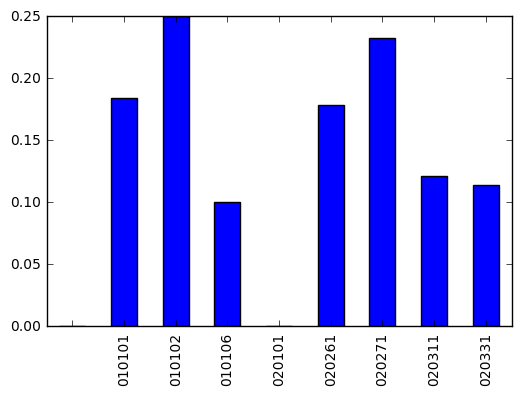

In [90]:
show_attribute_detail(
    train_data01_a_worker_per_user[train_data01_a_worker_per_user['IS_CONNECT_TO_09TABLE']==1],
    'LAST_MONTH_PAY_MODE',
    True,
    'TAG'
)

In [94]:
%%time
temp = \
    train_data09_merge_label_df.groupby(['CONS_NO','RCVBL_YM'],as_index=False)['PAY_MODE'].apply(lambda x:len(set(x)))

CPU times: user 5min 37s, sys: 3.34 s, total: 5min 40s
Wall time: 5min 39s


In [97]:
temp[temp>2]

CONS_NO     RCVBL_YM
3260016270  201503      3
3516008756  201502      3
3516026593  201502      3
Name: PAY_MODE, dtype: int64

In [54]:
%%time
# 缴费方式的变化线索
def get_short_pay_mode_change_clue(x):
    pay_mode_change_clue = '-'.join(
        [item[:4] for item in x.sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values]
    )
    return pay_mode_change_clue
    
train_data09_short_pay_mode_change_clue_series = \
    train_data09_merge_label_df.groupby('CONS_NO').apply(get_short_pay_mode_change_clue)

CPU times: user 11min 10s, sys: 4.64 s, total: 11min 15s
Wall time: 11min 32s


In [68]:
%%time
# 缴费方式的变化线索
def get_short_pay_mode_change_clue(x):
    pay_mode_change_clue = '-'.join(
        [item[:4] for item in x.sort_values(by='RCVBL_YM')['PAY_MODE'].drop_duplicates().values]
    )
    return pay_mode_change_clue
    
test_data09_short_pay_mode_change_clue_series = \
    test_data09_merge_label_df.groupby('CONS_NO').apply(get_short_pay_mode_change_clue)

CPU times: user 4min 5s, sys: 796 ms, total: 4min 5s
Wall time: 4min 8s


In [72]:
test_data09_short_pay_mode_change_clue_series[test_data09_short_pay_mode_change_clue_series=='0203-0203-0101']

CONS_NO
3315570506    0203-0203-0101
3318096796    0203-0203-0101
3318135859    0203-0203-0101
3318137151    0203-0203-0101
3330047031    0203-0203-0101
3330090717    0203-0203-0101
3330128826    0203-0203-0101
4510300057    0203-0203-0101
4511400405    0203-0203-0101
4515049897    0203-0203-0101
4520037095    0203-0203-0101
dtype: object

In [57]:
%%time
# 增加字段，缴费方式的转变路径
train_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'] = \
    train_data01_a_worker_per_user['CUST_NO'].map(train_data09_pay_mode_change_clue_series)
print sum(train_data01_a_worker_per_user['PAY_MODE_CHANGE_CLUE'].isnull())

102626
CPU times: user 1.97 s, sys: 132 ms, total: 2.1 s
Wall time: 3.42 s


In [70]:
%%time
# 增加字段，缴费方式的转变路径
test_data01_a_worker_per_user['ShORT_PAY_MODE_CHANGE_CLUE'] = \
    test_data01_a_worker_per_user['CUST_NO'].map(test_data09_short_pay_mode_change_clue_series)
print sum(test_data01_a_worker_per_user['ShORT_PAY_MODE_CHANGE_CLUE'].isnull())

169169
CPU times: user 1.01 s, sys: 36 ms, total: 1.04 s
Wall time: 1.39 s


##### 统计结果

(57, 5)


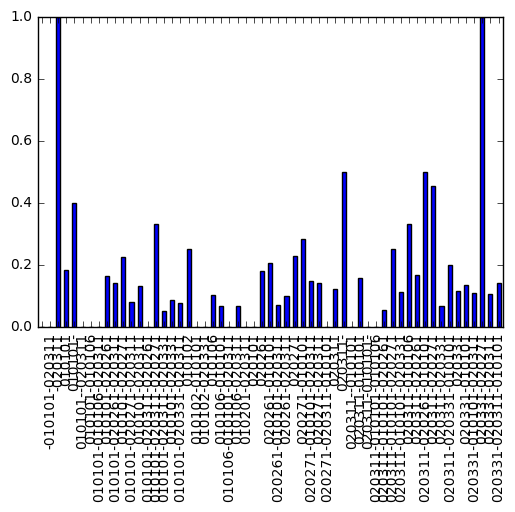

In [59]:
train_data09_pay_mode_change_clue_count_df =  show_attribute_detail(
    train_data01_a_worker_per_user,
    'PAY_MODE_CHANGE_CLUE',
    True,
    'TAG'
)

(22,)


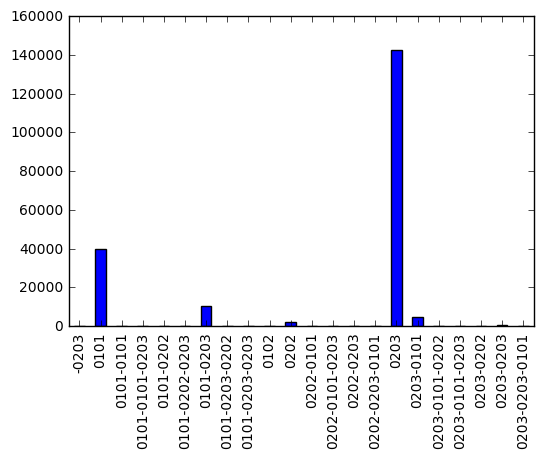

In [71]:
test_data09_pay_mode_change_clue_count_df = show_attribute_detail(
    test_data01_a_worker_per_user,
    'ShORT_PAY_MODE_CHANGE_CLUE',
)

In [62]:
# 合并
temp = train_data09_pay_mode_change_clue_count_df.join(
    test_data09_pay_mode_change_clue_count_df,
    how='outer'
).fillna(0).sort_values(by='tag1/total',ascending=False)
temp['test_total'] = temp['PAY_MODE_CHANGE_CLUE']
temp = temp.drop(labels = [u'PAY_MODE_CHANGE_CLUE'],axis=1)
print '所有用户 - 缴费方式的转变线索 PAY_MODE_CHANGE_CLUE'
print temp
# 数据太多了，输出分析
save_data(
    temp,
    'train&test_data09_pay_mode_change_clue_count_df.csv',
    index=True
)

所有用户 - 缴费方式的转变线索 PAY_MODE_CHANGE_CLUE
                         total      tag0  tag0/total     tag1  tag1/total  \
-020311                    1.0       0.0    0.000000      1.0    1.000000   
020331-020271              1.0       0.0    0.000000      1.0    1.000000   
020311-                    2.0       1.0    0.500000      1.0    0.500000   
020311-020261-010101       4.0       2.0    0.500000      2.0    0.500000   
020311-020271             11.0       6.0    0.545455      5.0    0.454545   
010101-                    5.0       3.0    0.600000      2.0    0.400000   
010101-020311-020271       3.0       2.0    0.666667      1.0    0.333333   
020311-010106              3.0       2.0    0.666667      1.0    0.333333   
020271-010101            344.0     246.0    0.715116     98.0    0.284884   
020311-010101-020271       4.0       3.0    0.750000      1.0    0.250000   
010102                     4.0       3.0    0.750000      1.0    0.250000   
020271                  4304.0    3322

------
## 4 数据缓存和恢复

### 4-1 保存

#### 4-1-1 训练集

#### data01

In [63]:
%%time
save_data(
    train_data01_a_worker_per_user,
    'train_data01_a_worker_per_user.csv',
)
print train_data01_a_worker_per_user.shape

(658374, 54)
CPU times: user 58.5 s, sys: 1.3 s, total: 59.8 s
Wall time: 1min 7s


In [62]:
train_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,ORG_NO_7bit,AVERAGE_RCVBL_AMT,IS_EXCEEDING_RCVBL_YM_GE_1MON,IS_CONNECT_TO_06TABLE,CONT_TYPE,MAX_NUM_MONTH_SEARCH_ACTION,NUM_OF_USED_PAY_MODE,IS_PAY_MODE_CONTAINS_020311,IS_PAY_MODE_CONTAINS_010101,IS_PAY_MODE_CONTAINS_020261
0,2015101280016722,1000000527203612,3,2.0,3341020,2015/10/12 7:31:50,【银行代扣】客户咨询银行代扣事宜,NaN,1196922.0,202.0,...,NaN,NaN,2.0,0,NaN,0.0,NaN,NaN,NaN,NaN
1,2015101280031388,1000000527304861,3,1.0,3340901,2015/10/12 9:14:03,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1005636.0,NaN,...,NaN,NaN,2.0,0,NaN,0.0,NaN,NaN,NaN,NaN
2,2015101280031424,1000000527305097,3,2.0,33401,2015/10/12 9:14:16,【查询电费】客户查询电费，已告知。,NaN,1007513.0,405.0,...,3340101.0,1652.304167,0.0,0,NaN,3.0,1.0,0.0,0.0,0.0
3,2015101280031680,1000000527300870,3,2.0,334020106,2015/10/12 9:11:37,【咨询总户号】通过地址（户名）查询户号信息。,NaN,1073266.0,202.0,...,3340201.0,51.961667,0.0,0,NaN,0.0,1.0,0.0,0.0,0.0
4,2015101280032506,1000000527305664,3,1.0,3340101,2015/10/12 9:14:48,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1433592.0,NaN,...,3340150.0,121.936250,0.0,0,NaN,0.0,1.0,1.0,0.0,0.0


In [19]:
%%time
save_data(
    train_data_toclassify[
        [
            'TAG','NUM_OF_WORKER','NUM_OF_SEARCH_ACTION','BUSI_TYPE_CODE',
            'ACCEPT_CONTENT_TYPE','ELEC_TYPE','URBAN_RURAL_FLAG','HANDLE_MONTH',
            'NUM_OF_IN_SEASON4','RCA_FLAG','CONT_TYPE',
            'AVERAGE_RCVBL_AMT','ORG_NO_7bit','IS_PENALTY','NUM_OF_RCVBL_PENALTY',
        ]
    ],
    'features-20161208.csv',
)
# print train_data01_a_worker_per_user.shape

CPU times: user 6.69 s, sys: 32 ms, total: 6.72 s
Wall time: 6.72 s


In [65]:
train_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,IS_EXCEEDING_RCVBL_YM_GE_1MON,IS_CONNECT_TO_06TABLE,CONT_TYPE,MAX_NUM_MONTH_SEARCH_ACTION,NUM_OF_USED_PAY_MODE,IS_PAY_MODE_CONTAINS_020311,IS_PAY_MODE_CONTAINS_010101,IS_PAY_MODE_CONTAINS_020261,LAST_MONTH_PAY_MODE,PAY_MODE_CHANGE_CLUE
0,2015101280016722,1000000527203612,3,2.0,3341020,2015/10/12 7:31:50,【银行代扣】客户咨询银行代扣事宜,NaN,1196922.0,202.0,...,2.0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015101280031388,1000000527304861,3,1.0,3340901,2015/10/12 9:14:03,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1005636.0,NaN,...,2.0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015101280031424,1000000527305097,3,2.0,33401,2015/10/12 9:14:16,【查询电费】客户查询电费，已告知。,NaN,1007513.0,405.0,...,0.0,0,NaN,3.0,1.0,0.0,0.0,0.0,020271,020271
3,2015101280031680,1000000527300870,3,2.0,334020106,2015/10/12 9:11:37,【咨询总户号】通过地址（户名）查询户号信息。,NaN,1073266.0,202.0,...,0.0,0,NaN,0.0,1.0,0.0,0.0,0.0,020331,020331
4,2015101280032506,1000000527305664,3,1.0,3340101,2015/10/12 9:14:48,【咨询总户号】通过地址（户名、表号）查询户号信息，已告知,NaN,1433592.0,NaN,...,0.0,0,NaN,0.0,1.0,1.0,0.0,0.0,020311,020311


In [64]:
train_data01_a_worker_per_user.shape,test_data01_a_worker_per_user.shape

((658374, 54), (370871, 53))

#### data09

In [94]:
%%time
save_data(
    train_data09_merge_label_df,
    'train_data09_merge_label_df.csv',
)
print train_data09_merge_label_df.shape

(6466654, 18)
CPU times: user 2min 27s, sys: 712 ms, total: 2min 28s
Wall time: 2min 28s


#### 4-1-2 测试集

#### data01

In [66]:
%%time
save_data(
    test_data01_a_worker_per_user,
    'test_data01_a_worker_per_user.csv'
)
print test_data01_a_worker_per_user.shape

(370871, 53)
CPU times: user 34.6 s, sys: 604 ms, total: 35.2 s
Wall time: 38.7 s


In [89]:
test_data01_a_worker_per_user.head()

,APP_NO,ID,BUSI_TYPE_CODE,URBAN_RURAL_FLAG,ORG_NO,HANDLE_TIME,ACCEPT_CONTENT,HANDLE_OPINION,CALLING_NO,ELEC_TYPE,...,NUM_OF_RCVBL_PENALTY,IS_CONNECT_TO_07TABLE,CONS_STATUS,RCA_FLAG,ORG_NO_7bit,AVERAGE_RCVBL_AMT,IS_EXCEEDING_RCVBL_YM_GE_1MON,IS_CONNECT_TO_06TABLE,CONT_TYPE,MAX_NUM_MONTH_SEARCH_ACTION
0,2015101280019632,1000000527215943,3,1.0,3340780,2015/10/12 7:58:04,【客户咨询一户无电】建议先自行联系有资质电工排查是否为内部故障，客户接受并表示有其他情况再致电。,NaN,1628699.0,202.0,...,0.0,0,NaN,NaN,3340780.0,68.573333,0.0,0,NaN,0.0
1,2015101280019648,1000000527216033,10,2.0,334066001,2015/10/12 7:58:26,【退订】#2061584501；【退订】#2061584602；【退订】#406091928...,NaN,1260775.0,201.0,...,0.0,0,NaN,NaN,3340660.0,34.745833,0.0,0,NaN,0.0
2,2015101280019680,1000000527216202,3,2.0,3340690,2015/10/12 7:58:52,【查询电费】客户查询本月电费，已告知。,NaN,1536321.0,201.0,...,0.0,0,NaN,NaN,3340690.0,207.431667,0.0,0,NaN,1.0
3,2015101280019873,1000000527218491,3,1.0,3340810,2015/10/12 8:02:53,【咨询总户号】通过地址、户名查询户号信息，已告知,NaN,1576698.0,NaN,...,0.0,0,NaN,NaN,3340801.0,20.694444,0.0,0,NaN,0.0
4,2015101280020130,1000000527221199,1,1.0,3340501,2015/10/12 8:07:10,【设备故障】客户报修此处线路打火，请处理。客户只能提供此地址，烦请电话联系057486581...,NaN,1089990.0,201.0,...,NaN,0,NaN,NaN,NaN,NaN,2.0,0,NaN,0.0


#### data09

In [95]:
%%time
save_data(
    test_data09_merge_label_df,
    'test_data09_merge_label_df.csv',
)
print train_data09_merge_label_df.shape

(6466654, 18)
CPU times: user 1min, sys: 296 ms, total: 1min 1s
Wall time: 1min 1s


### 4-2 恢复

#### 4-2-1 训练集

#### data01

In [25]:
%%time
train_data01_a_worker_per_user = load_data('train_data01_a_worker_per_user.csv',
                                               encoding='utf8',
                                               converters={
                                                   'CUST_NO': unicode,
                                                   'LAST_MONTH_PAY_MODE': unicode,
                                               })
print train_data01_a_worker_per_user.shape

(658374, 54)
CPU times: user 13.2 s, sys: 1.14 s, total: 14.4 s
Wall time: 17.4 s


#### data09

In [2]:
%%time
train_data09_merge_label_df = load_data('train_data09_merge_label_df.csv',
                                           encoding='utf8',
                                           converters={'CONS_NO':unicode}
                                          )
print train_data09_merge_label_df.shape

(6466654, 18)
CPU times: user 15.8 s, sys: 816 ms, total: 16.6 s
Wall time: 17.2 s


#### 4-2-2 测试集

#### data01

In [26]:
%%time
%%time
test_data01_a_worker_per_user = load_data('test_data01_a_worker_per_user.csv',
                                              encoding='utf8',
                                              converters={
                                                  'CUST_NO': unicode,
                                                  'LAST_MONTH_PAY_MODE': unicode,
                                              }
                                         )
print test_data01_a_worker_per_user.shape

(370871, 53)
CPU times: user 6.22 s, sys: 452 ms, total: 6.68 s
Wall time: 6.9 s
CPU times: user 6.22 s, sys: 456 ms, total: 6.68 s
Wall time: 6.91 s


#### data09

In [41]:
%%time
test_data09_merge_label_df = load_data('test_data09_merge_label_df.csv',
                                           encoding='utf8',
                                           converters={'CONS_NO':unicode}
                                          )
print test_data09_merge_label_df.shape

(2479469, 17)
CPU times: user 5.97 s, sys: 768 ms, total: 6.74 s
Wall time: 6.97 s


## 5 准备数据和模型构建

### 5-1 数据细分
    - 规则匹配 - 根据 工单内容 的类型不敏感度 过滤掉 部分不敏感 用户 ,或者直接判定部分用户为 敏感用户等
    - 交于分类器处理

#### 5-1-1 训练集

In [6]:
train_data_toclassify, train_data_sensitive = seperate_data_to_classifier(
    train_data01_a_worker_per_user,
    plan_type=PLAN_TYPE
)

total: 658374
is_connect_to_09table == 1 : 555748
is_connect_to_09table == 0 : 102626
剩下: 555748(敏感：80025,不敏感：475723，比例：5.944680)
根据 用电类别 ELEC_TYPE 进行过滤
ELEC_TYPE_IS_NONSENSITIVE: 6(敏感：0,不敏感：6)
剩下: 555742
剩下: 555742(敏感：80025,不敏感：475717，比例：5.944605)
CONS_STATUS==3: 12 ——> 规则直接判为非敏感(敏感：0,不敏感：12)
CONT_TYPE==2: 28 ——> 规则直接判为非敏感(敏感：1,不敏感：27)
剩下: 555702(敏感：80024,不敏感：475678，比例：5.944192)
data_connect_to_09table 进一步根据total和tag1/total过滤...
tag1/total == 1 ——> 规则直接判为敏感: 122(敏感：122,不敏感：0)
tag1/total < 0.01 ——> 规则直接判为非敏感: 174472(敏感：436,不敏感：174036)
剩下: 380542(敏感：79395,不敏感：301147，比例：3.793022)


(2,)


0    262531
1     77574
Name: TAG, dtype: int64

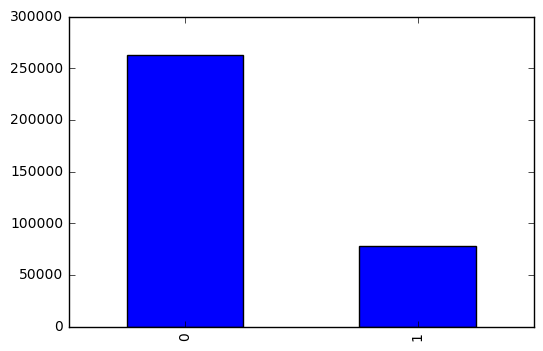

In [53]:
show_attribute_detail(
    train_data_toclassify,
    attribute_name='TAG', 
)

#### 5-1-2 测试集

In [29]:
test_data_toclassify, test_data_sensitive = seperate_data_to_classifier(
    test_data01_a_worker_per_user,
    type='test',
    plan_type=PLAN_TYPE
)

total: 370871
is_connect_to_09table == 1 : 201702
is_connect_to_09table == 0 : 169169
data_connect_to_09table 进一步根据total和tag1/total过滤...
tag1/total == 1 ——> 规则直接判为敏感: 9
tag1/total < 0.01 ——> 规则直接判为非敏感: 85830
剩下: 115863
根据 用电类别 ELEC_TYPE 进行过滤
ELEC_TYPE_IS_NONSENSITIVE: 1
剩下: 115862
CONS_STATUS==3: 1 ——> 规则直接判为非敏感
CONT_TYPE==2: 8 ——> 规则直接判为非敏感
剩下: 115853


#### 5-1-3 小结
- 目前总共使用了两个版本的过滤规则，详细看 (含线下F值计算)train&test_accept_content_type.xlsx

### 5-2 特征编码

#### 5-2-1 训练集

##### 5-2-1-1 onehot 编码

In [22]:
%%time
train_data_features = data_feature_encoder.fit_transform(
    train_data_toclassify,
)
print train_data_features.shape

工单数 1
查询电费次数 1
第四季度记录数 1
应收违约金的次数 1
平均电费 1
是否连接上06表 1
是否连接上07表 1
是否连接上08表 1
是否连接上09表 1
是否违约 1
是否违约超出1个月以上 1
代表工单月份 1
城乡标志 3
用电类型 12
小工单类型 169
CONT_TYPE 1
STATUS 2
CONS_STATUS 2
RCA_FLAG 2
ORG_NO_7bit_09TABLE 59
(340098, 262)
CPU times: user 5.74 s, sys: 7.61 s, total: 13.4 s
Wall time: 16.5 s


In [21]:
train_data_features.head()

,NUM_OF_WORKER,NUM_OF_SEARCH_ACTION,NUM_OF_IN_SEASON4,NUM_OF_RCVBL_PENALTY,AVERAGE_RCVBL_AMT,IS_CONNECT_TO_06TABLE,IS_CONNECT_TO_07TABLE,IS_CONNECT_TO_08TABLE,IS_CONNECT_TO_09TABLE,IS_PENALTY,...,ORG_NO_7bit_3341020.0,ORG_NO_7bit_3341030.0,ORG_NO_7bit_3341040.0,ORG_NO_7bit_3341050.0,ORG_NO_7bit_3341060.0,ORG_NO_7bit_3341070.0,ORG_NO_7bit_3341080.0,ORG_NO_7bit_3341101.0,ORG_NO_7bit_3341110.0,ORG_NO_7bit_3341120.0
2,7,6.0,2,0.0,-0.025468,0,0,1,1,False,...,0,0,0,0,0,0,0,0,0,0
3,1,0.0,1,0.0,-0.033391,0,0,1,1,False,...,0,0,0,0,0,0,0,0,0,0
4,2,0.0,2,0.0,-0.033044,0,0,1,1,False,...,0,0,0,0,0,0,0,0,0,0
7,1,0.0,1,0.0,-0.023399,0,0,1,1,False,...,0,0,0,0,0,0,0,0,0,0
8,1,1.0,1,0.0,-0.032673,0,0,0,1,False,...,0,0,0,0,0,0,0,0,0,0


In [23]:
train_X = train_data_features.as_matrix()
train_y = train_data_toclassify['TAG'].as_matrix().flatten()
# u'IS_CONNECT_TO_09TABLE
# train_is_connect_to_09table = train_data_toclassify['IS_CONNECT_TO_09TABLE'].as_matrix().flatten()

print train_X.shape,train_y.shape

train_X = np.random.RandomState(1).permutation(train_X)
train_y = np.random.RandomState(1).permutation(train_y)
# train_is_connect_to_09table = np.random.RandomState(1).permutation(train_is_connect_to_09table)

(340098, 262) (340098,)


In [24]:
index = int(0.7 * len(train_y))

train_X_dev  = train_X[:index]
train_y_dev  = train_y[:index]
train_X_val = train_X[index:]
train_y_val = train_y[index:]
# train_is_connect_to_09table_val = train_is_connect_to_09table[index:]

In [12]:
print sum(train_y_dev==1)
print sum(train_y_dev==0)
print sum(train_y_val==1)
print sum(train_y_val==0)

54304
183774
23266
78768


In [20]:
sum(train_y==0)/(sum(train_y==1)*1.0)

5.8935482658850935

##### 5-2-1-2 扩大正例数据 3/5倍，使得数据平衡

###### 全部训练验证数据

In [25]:
if PLAN_TYPE in [1,3]:
    n= 3
elif PLAN_TYPE in[2]:
    n=5
n=5
print n

train_X_dev_3,train_y_dev_3 = extend_train_data(train_X_dev,train_y_dev,n=n)

5


In [27]:
train_X_dev_3.shape, train_y_dev_3.shape

((346862, 46), (346862,))

###### 全部训练数据

In [26]:
if PLAN_TYPE in [1,3]:
    n= 3
elif PLAN_TYPE in[2]:
    n=5
n=5
print n
train_X_3,train_y_3 = extend_train_data(train_X,train_y,n=n)

5


#### 5-2-2 测试集

##### 5-2-2-1 onehot 编码

In [27]:
%%time
test_data_features = data_feature_encoder.transform(
    test_data_toclassify,
)

工单数 1
查询电费次数 1
第四季度记录数 1
应收违约金的次数 1
平均电费 1
是否连接上06表 1
是否连接上07表 1
是否连接上08表 1
是否连接上09表 1
是否违约 1
是否违约超出1个月以上 1
代表工单月份 1
城乡标志 3
用电类型 12
小工单类型 169
CONT_TYPE 1
STATUS 2
CONS_STATUS 2
RCA_FLAG 2
ORG_NO_7bit_09TABLE 59
CPU times: user 3.09 s, sys: 2.8 s, total: 5.89 s
Wall time: 9.18 s


In [16]:
test_data_features.head()

,NUM_OF_WORKER,URBAN_RURAL_FLAG_1.0,URBAN_RURAL_FLAG_2.0,URBAN_RURAL_FLAG_3.0,ELEC_TYPE_100.0,ELEC_TYPE_200.0,ELEC_TYPE_201.0,ELEC_TYPE_202.0,ELEC_TYPE_203.0,ELEC_TYPE_300.0,...,ACCEPT_CONTENT_TYPE_电费账单寄送,ACCEPT_CONTENT_TYPE_电量异常,ACCEPT_CONTENT_TYPE_短信变更,ACCEPT_CONTENT_TYPE_短信订阅,ACCEPT_CONTENT_TYPE_缴费方式,ACCEPT_CONTENT_TYPE_补充信息,ACCEPT_CONTENT_TYPE_表箱故障,ACCEPT_CONTENT_TYPE_表计信息,ACCEPT_CONTENT_TYPE_阶梯电价,ACCEPT_CONTENT_TYPE_验表
2,2,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
test_X = test_data_features.as_matrix()
test_X.shape

(163019, 262)

### 5-3 模型分类

#### 5-3-1 随机森林

##### 5-3-1-1     7/3验证

In [29]:
%%time
rf_model = model_train(
    model_name='rf',
    train_X = train_X_dev_3,
    train_y = list(train_y_dev_3)
)
print rf_model

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

> /usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py(54)_assert_all_finite()
     52             and not np.isfinite(X).all()):
     53         raise ValueError("Input contains NaN, infinity"
---> 54                          " or a value too large for %r." % X.dtype)
     55 
     56 

ipdb> q


In [ ]:
%%time
y_predict = model_predict(rf_model,train_X_val,train_y_val)

In [98]:
get_metrics(train_y_val,y_predict)

total:102030
TP:18851,FP:11879,TN:66980,FN:4320
f1_score:0.699468
precision_score:0.613440
recall_score:0.813560
accu:0.841233
预测为敏感：30730，不敏感：71300


###### 5-3-1-2 最终测试集

In [11]:
%%time
rf_model_total = model_train(
    model_name='rf',
    train_X = train_X_3,
    train_y = list(train_y_3)
)
print rf_model_total

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
CPU times: user 27min 39s, sys: 19.3 s, total: 27min 58s
Wall time: 10min 42s


In [18]:
pickle.dump(rf_model_total,open('rf_model_total-56features-20161205-001.pkl','w'))

In [ ]:
rf_model_total = pickle.load(open('rf_model_total-56features-20161205-001.pkl','r'))

In [12]:
y_predict_total = model_predict(rf_model_total,test_X,[1]*len(test_X))

total:193371
TP:11449,FP:0,TN:0,FN:181922
f1_score:0.111796
precision_score:1.000000
recall_score:0.059207
accu:0.059207
预测为敏感：11449，不敏感：181922


#### 5-3-3 保存结果

In [13]:
sum(y_predict_total==1),len(y_predict_total==1)

(11449, 193371)

In [14]:
test_data_sensitive.shape

(9, 47)

In [15]:
test_data_toclassify.loc[:,'TAG']=y_predict_total

(2, 5)
   total   tag0  tag0/total   tag1  tag1/total
0  66241  56841    0.858094   9400    0.141906
1  96778  82741    0.854957  14037    0.145043


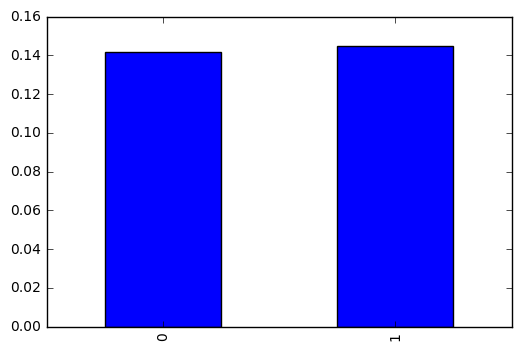

In [77]:
# print test_data_toclassify[test_data_toclassify['TAG']==1].shape
print show_attribute_detail(
    test_data_toclassify,
    'IS_CONNECT_TO_09TABLE',
    split_by_tag=True,
    tag_name='TAG', 
    show_pic=True
)


In [16]:
temp = test_data_toclassify[test_data_toclassify['TAG']==1]
# 使用09表 是否连接上 作为规则 过滤用户
# temp = temp[temp['IS_CONNECT_TO_09TABLE']==1]
temp = pd.concat([temp,test_data_sensitive])
temp.shape

(11458, 50)

In [17]:
save_data(
    temp['CUST_NO'],
    'rf_result-48features+09re-20161206.csv',
    header=None
)